In [1]:
import sys
# Adjust the path to point to the directory containing 'src'
sys.path.append('../')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

from src.visualizations import plot_target_variable, plot_categorical_features, plot_numerical_features, categorical_vs_target, numerical_vs_target, plot_correlation_heatmap
import shap
from src.evaluation import plot_confusion_matrix
from src.modeling import get_models
from src.feature_engineering import bin_age, features_engineering_extraction, encode_categorical_columns
from src.data_preprocessing import load_data, rename_columns, impute_missing_values, analyze_categorical,standardize_gender


In [2]:
# --- Data Loading ---
df = load_data(filepath='../data/mental-heath-in-tech-2016.csv')
print('Dataset loaded')

Data loaded successfully from: ../data/mental-heath-in-tech-2016.csv
Dataset loaded


In [3]:
df.describe()

Are you self-employed?  \
count             1433.000000   
mean                 0.200279   
std                  0.400349   
min                  0.000000   
25%                  0.000000   
50%                  0.000000   
75%                  0.000000   
max                  1.000000   

       Is your employer primarily a tech company/organization?  \
count                                        1146.000000         
mean                                            0.770506         
std                                             0.420691         
min                                             0.000000         
25%                                             1.000000         
50%                                             1.000000         
75%                                             1.000000         
max                                             1.000000         

       Is your primary role within your company related to tech/IT?  \
count                                         263.000000              
mean                                            0.942966              
std                                             0.232350              
min                                             0.000000              
25%                                             1.000000              
50%                                             1.000000              
75%                                             1.000000              
max                                             1.000000              

       Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?  \
count                                         287.000000                                                                       
mean                                            0.644599                                                                       
std                                             0.479471                                                                       
min                                             0.000000                                                                       
25%                                             0.000000                                                                       
50%                                             1.000000                                                                       
75%                                             1.000000                                                                       
max                                             1.000000                                                                       

       Do you have previous employers?  \
count                      1433.000000   
mean                          0.882066   
std                           0.322643   
min                           0.000000   
25%                           1.000000   
50%                           1.000000   
75%                           1.000000   
max                           1.000000   

       Have you ever sought treatment for a mental health issue from a mental health professional?  \
count                                        1433.000000                                             
mean                                            0.585485                                             
std                                             0.492810                                             
min                                             0.000000                                             
25%                                             0.000000                                             
50%                                             1.000000                                             
75%                                             1.000000                                             
max                                             1.000000                                             

       What is your age

In [4]:
df.describe(include='all')

Are you self-employed?  \
count              1433.000000   
unique                     NaN   
top                        NaN   
freq                       NaN   
mean                  0.200279   
std                   0.400349   
min                   0.000000   
25%                   0.000000   
50%                   0.000000   
75%                   0.000000   
max                   1.000000   

       How many employees does your company or organization have?  \
count                                                1146           
unique                                                  6           
top                                                26-100           
freq                                                  292           
mean                                                  NaN           
std                                                   NaN           
min                                                   NaN           
25%                                                   NaN           
50%                                                   NaN           
75%                                                   NaN           
max                                                   NaN           

        Is your employer primarily a tech company/organization?  \
count                                         1146.000000         
unique                                                NaN         
top                                                   NaN         
freq                                                  NaN         
mean                                             0.770506         
std                                              0.420691         
min                                              0.000000         
25%                                              1.000000         
50%                                              1.000000         
75%                                              1.000000         
max                                              1.000000         

        Is your primary role within your company related to tech/IT?  \
count                                          263.000000              
unique                                                NaN              
top                                                   NaN              
freq                                                  NaN              
mean                                             0.942966              
std                                              0.232350              
min                                              0.000000              
25%                                              1.000000              
50%                                              1.000000              
75%                                              1.000000              
max                                              1.000000              

       Does your employer provide mental health benefits as part of healthcare coverage?  \
count                                                1146                                  
unique                                                  4                                  
top                                                   Yes                                  
freq                                                  531                                  
mean                                                  NaN                                  
std                                                   NaN                                  
min                                                   NaN                                  
25%                                                   NaN                                  
50%                                                   NaN                                  
75%                                                   NaN                                  
max                                                   NaN                               

In [5]:
df.shape

(1433, 63)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

In [7]:

# --- Data Preprocessing ---
print("\n--- Data Preprocessing ---")

column_new_name = ["SelfEmployed", "EmployeeCount", "TechCompany", "TechRole", "EmployerMHBenefits",
                   "MHBenefitsAwareness", "EmployerMHDiscussion", "EmployerMHResources", "EmployerMHAnonymity",
                   "MHLeaveDifficulty", "MHDiscussionEmployerNegative", "PhysicalDiscussionEmployerNegative",
                   "MHDiscussionCoworkerComfort", "MHDiscussionSupervisorComfort", "EmployerMHVsPhysical",
                   "MHNegativeObserved", "PersonalnsuranceMHCoverage", "MHResourceAwareness", "MHDisclosureClients",
                   "MHDisclosureClientsNegative", "MHDisclosureCoworkers", "MHDisclosureCoworkersNegative",
                   "MHProductivityImpact", "MHProductivityPercent", "PreviousEmployers",
                   "PreviousEmployerMHBenefits", "PreviousEmployerMHBenefitsAwareness",
                   "PreviousEmployerMHDiscussion", "PreviousEmployerMHResources", "PreviousEmployerMHAnonymity",
                   "PreviousEmployerMHDiscussionNegative", "PreviousEmployerPhysicalDiscussionNegative",
                   "PreviousMHDiscussionCoworkerComfort", "PreviousMHDiscussionSupervisorComfort",
                   "PreviousEmployerMHVsPhysical", "PreviousMHNegativeObserved", "PhysicalInterviewDisclosure",
                   "PhysicalInterviewDisclosureReason", "MHInterviewDisclosure", "MHInterviewDisclosureReason",
                   "MHCareerImpact", "MHStigmaCoworker", "MHDisclosureFamilyFriends", "MHUnsupportiveResponse",
                   "MHDisclosureInfluenced", "FamilyMHHistory", "PastMHDisorder", "CurrentMHDisorder",
                   "CurrentMHDisorderConditions", "MHSelfDiagnosis", "ProfessionalMHDiagnosis",
                   "ProfessionalMHDiagnosisDetails", "MHTreatmentSought", "MHTreatmentEffectiveWorkImpact",
                   "MHTreatmentIneffectiveWorkImpact", "Age", "Gender", "CountryLive", "StateLive", "CountryWork",
                   "StateWork", "WorkPosition", "RemoteWork"]



--- Data Preprocessing ---


In [8]:

# Renaming columns
df_rename = rename_columns(df=df, renamed_columns=column_new_name)

# df.rename(columns=dict(zip(columns, renamed_columns)), inplace=True)
print("Columns renamed.")

Columns renamed.


In [9]:
# Feature engineering
print("\n--- Feature Engineering ---")

# Binning age
df_bin = bin_age(df=df_rename)



--- Feature Engineering ---
Age feature binned.


In [10]:

# Gender Feature Standardizationa

analyze_categorical(df=df_bin)

df_gender_cleaned = standardize_gender(df=df_bin)



Column 'CountryLive' has 53 unique values: ['United Kingdom' 'United States of America' 'Canada' 'Germany'
 'Netherlands' 'Czech Republic' 'Lithuania' 'Australia' 'France'
 'Venezuela' 'Poland' 'Belgium' 'Brazil' 'Denmark' 'Sweden' 'Russia'
 'Spain' 'India' 'Mexico' 'Switzerland' 'Norway' 'Argentina' 'Ireland'
 'Italy' 'Finland' 'Colombia' 'Costa Rica' 'Vietnam' 'Bulgaria'
 'New Zealand' 'South Africa' 'Slovakia' 'Austria' 'Bangladesh' 'Algeria'
 'Pakistan' 'Afghanistan' 'Greece' 'Romania' 'Other' 'Brunei' 'Japan'
 'Iran' 'Hungary' 'Israel' 'Ecuador' 'Bosnia and Herzegovina' 'China'
 'Chile' 'Guatemala' 'Taiwan' 'Serbia' 'Estonia']
Column 'CountryWork' has 53 unique values: ['United Kingdom' 'United States of America' 'Canada' 'Germany'
 'Netherlands' 'Czech Republic' 'Lithuania' 'Australia' 'France'
 'Venezuela' 'Poland' 'Belgium' 'Brazil' 'Denmark' 'Sweden' 'Russia'
 'Spain' 'India' 'United Arab Emirates' 'Mexico' 'Switzerland' 'Norway'
 'Argentina' 'Ireland' 'Italy' 'Finland' 'Turke

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\data_preprocessing.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].replace(to_replace=replacements,


In [11]:
print(f'Gender features cleaned unique values: {df_gender_cleaned.Gender.unique()}')


Gender features cleaned unique values: ['Male' 'Female' 'Others' nan]


In [12]:

# More Feature Engineering
df_feature_eng = features_engineering_extraction(df=df_gender_cleaned)

print("Employment features engineered.")


Employment features engineered.


In [13]:
df_feature_eng.head()

Age Age_group               CountryLive               CountryWork  \
0   39     30-39            United Kingdom            United Kingdom   
1   29     18-29  United States of America  United States of America   
2   38     30-39            United Kingdom            United Kingdom   
3   43     40-49            United Kingdom            United Kingdom   
4   43     40-49  United States of America  United States of America   

  CurrentMHDisorder                        CurrentMHDisorderConditions  \
0                No                                                NaN   
1               Yes  Anxiety Disorder (Generalized, Social, Phobia,...   
2                No                                                NaN   
3               Yes  Anxiety Disorder (Generalized, Social, Phobia,...   
4               Yes  Anxiety Disorder (Generalized, Social, Phobia,...   

  EmployeeCount EmployerMHAnonymity               EmployerMHBenefits  \
0        26-100        I don't know  Not eligible for coverage / N/A   
1          2-25                 Yes                               No   
2          2-25        I don't know                               No   
3           NaN                 NaN                              NaN   
4          2-25                  No                              Yes   

  EmployerMHDiscussion  ... StateLive StateWork TechCompany TechRole  \
0                   No  ...       NaN       NaN         1.0      NaN   
1                  Yes  ...  Illinois  Illinois         1.0      NaN   
2                   No  ...       NaN       NaN         1.0      NaN   
3                  NaN  ...       NaN       NaN         NaN      NaN   
4                   No  ...  Illinois  Illinois         0.0      1.0   

                                        WorkPosition  \
0                                 Back-end Developer   
1             Back-end Developer|Front-end Developer   
2                                 Back-end Developer   
3                               Supervisor/Team Lead   
4  Executive Leadership|Supervisor/Team Lead|Dev ...   

  CurrentMHDisorderConditions_count MHSelfDiagnosisConditions_count  \
0                                 0                               0   
1                                 2                               0   
2                                 0                               0   
3                                 2                               0   
4                                 2                               0   

  MHPHDiagnosisConditions_count role_count         EmploymentCompanySize  
0                             1          1  Tech Employee Medium Company  
1                             2          2   Tech Employee Small Company  
2                             0          1   Tech Employee Small Company  
3                             2          1                         Other  
4                             1          7                     Tech-Role  

[5 rows x 69 columns]

In [14]:
len(df_feature_eng.columns.to_list())

69

In [15]:

# Dropping Unnecessary Columns
dropped_cols = ['Age', 'CurrentMHDisorderConditions', 'EmployeeCount', 'MHInterviewDisclosureReason',
                'MHResourceAwareness', 'MHProductivityImpact', 'MHProductivityPercent',
                'MHSelfDiagnosis', 'PersonalnsuranceMHCoverage', 'SelfEmployed', 'TechCompany',
                'TechRole', 'WorkPosition', 
                'PhysicalInterviewDisclosureReason','role_count',
                'PreviousEmployerMHAnonymity', 'PreviousEmployerMHBenefits',
                'PreviousEmployerMHBenefitsAwareness', 'PreviousEmployerMHDiscussion',
                'PreviousEmployerMHDiscussionNegative', 'PreviousEmployerMHResources',
                'PreviousEmployerMHVsPhysical', 'PreviousEmployerPhysicalDiscussionNegative',
                'PreviousEmployers', 'PreviousMHDiscussionCoworkerComfort',
                'PreviousMHDiscussionSupervisorComfort']
df_feature_eng = df_feature_eng.drop(columns=dropped_cols, errors='ignore')
print("Unnecessary columns dropped.")

Unnecessary columns dropped.


In [16]:
len(df_feature_eng.columns.to_list())

43

In [17]:
# Missing values imputation
df_cleaned = impute_missing_values(df_feature_eng)
print("Missing values imputed.")

Missing values imputed.


In [18]:
df_cleaned.columns.to_list()

['Age_group',
 'CountryLive',
 'CountryWork',
 'CurrentMHDisorder',
 'EmployerMHAnonymity',
 'EmployerMHBenefits',
 'EmployerMHDiscussion',
 'EmployerMHResources',
 'EmployerMHVsPhysical',
 'FamilyMHHistory',
 'Gender',
 'MHBenefitsAwareness',
 'MHCareerImpact',
 'MHDisclosureClients',
 'MHDisclosureClientsNegative',
 'MHDisclosureCoworkers',
 'MHDisclosureCoworkersNegative',
 'MHDisclosureFamilyFriends',
 'MHDisclosureInfluenced',
 'MHDiscussionCoworkerComfort',
 'MHDiscussionEmployerNegative',
 'MHDiscussionSupervisorComfort',
 'MHInterviewDisclosure',
 'MHLeaveDifficulty',
 'MHNegativeObserved',
 'MHStigmaCoworker',
 'MHTreatmentEffectiveWorkImpact',
 'MHTreatmentIneffectiveWorkImpact',
 'MHTreatmentSought',
 'MHUnsupportiveResponse',
 'PastMHDisorder',
 'PhysicalDiscussionEmployerNegative',
 'PhysicalInterviewDisclosure',
 'PreviousMHNegativeObserved',
 'ProfessionalMHDiagnosis',
 'ProfessionalMHDiagnosisDetails',
 'RemoteWork',
 'StateLive',
 'StateWork',
 'CurrentMHDisorderCondit

In [19]:
# --- Exploratory Data Analysis ---
print("\n--- Exploratory Data Analysis started ---")



--- Exploratory Data Analysis started ---


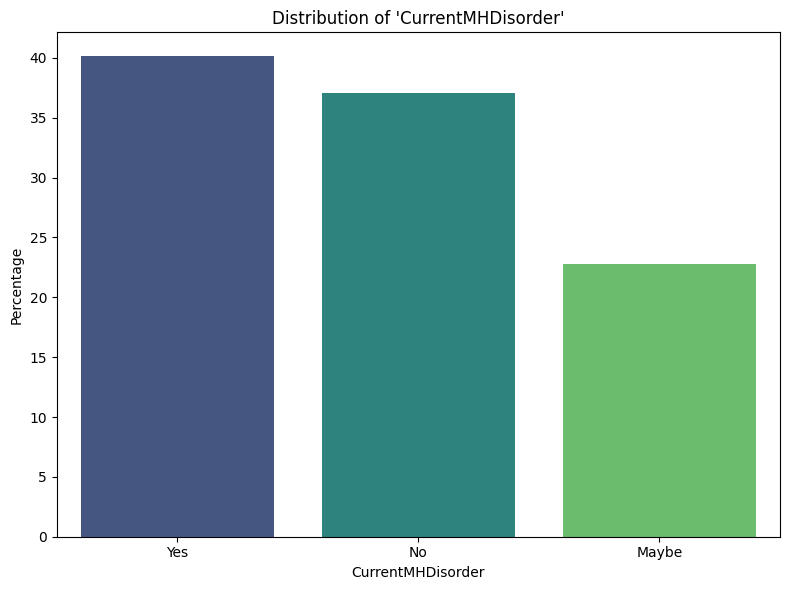

In [20]:
plot_target_variable(df_cleaned)

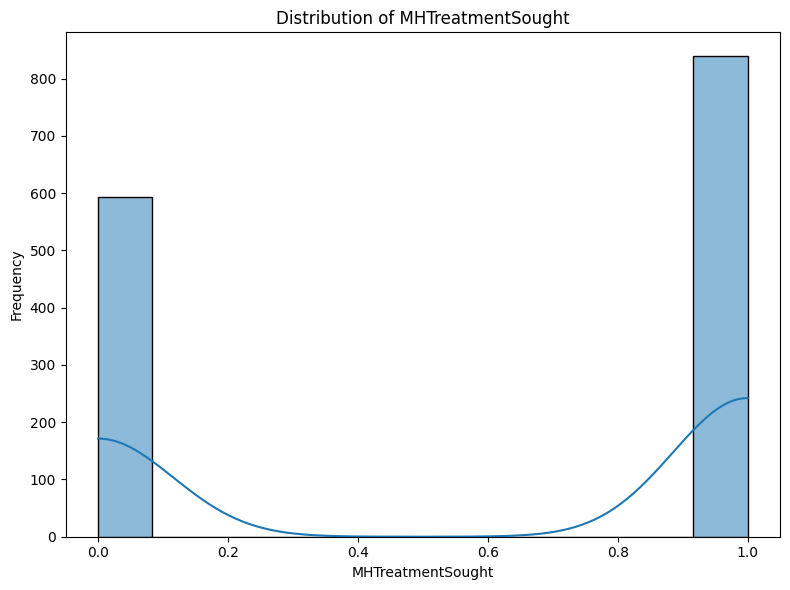

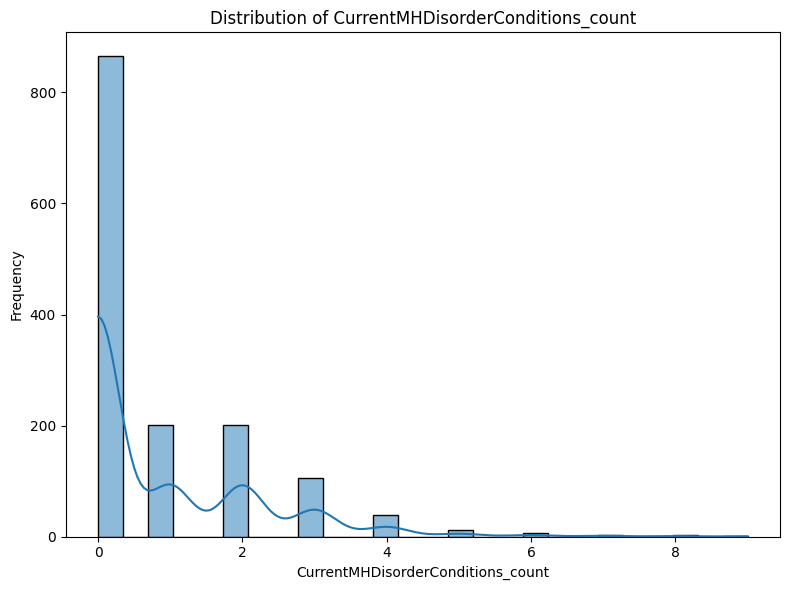

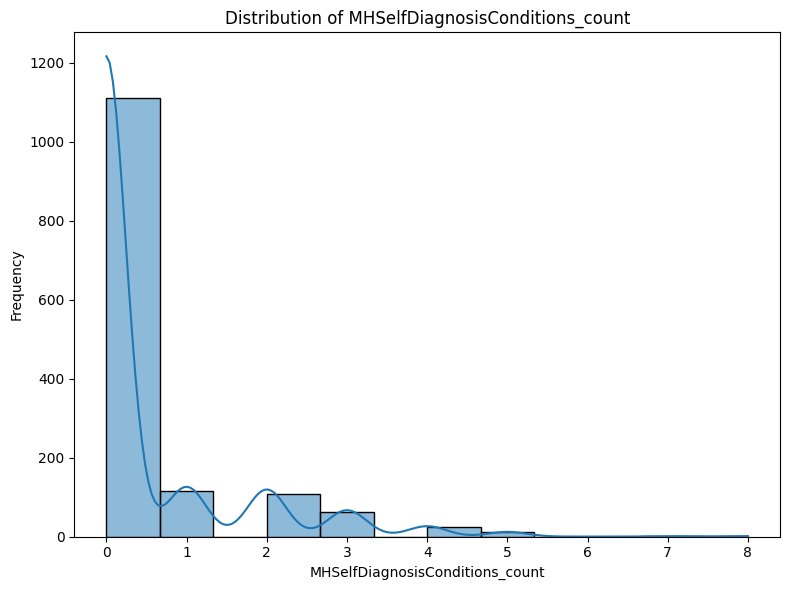

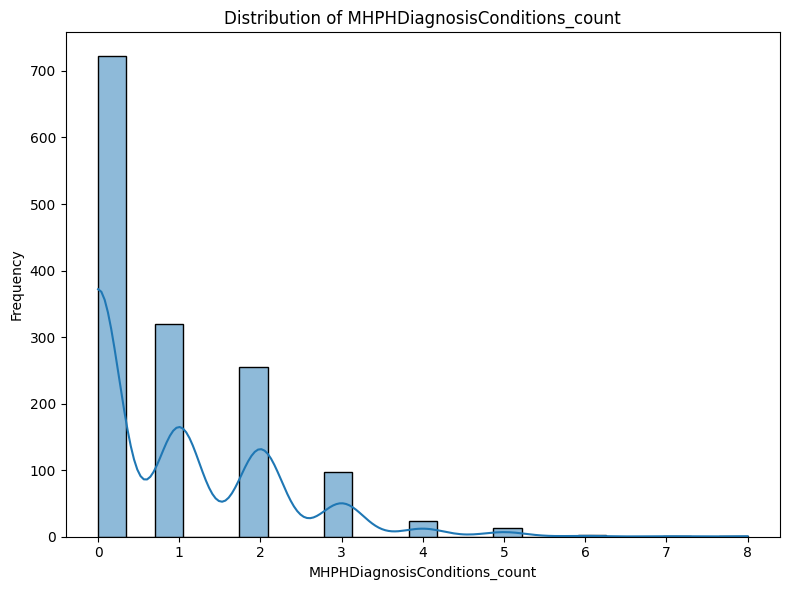

In [21]:
plot_numerical_features(df_cleaned)


In [22]:
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
exclude_cols = ['CountryLive', 'CountryWork', 'StateLive', 'StateWork','ProfessionMHDiagnosisDetails',]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

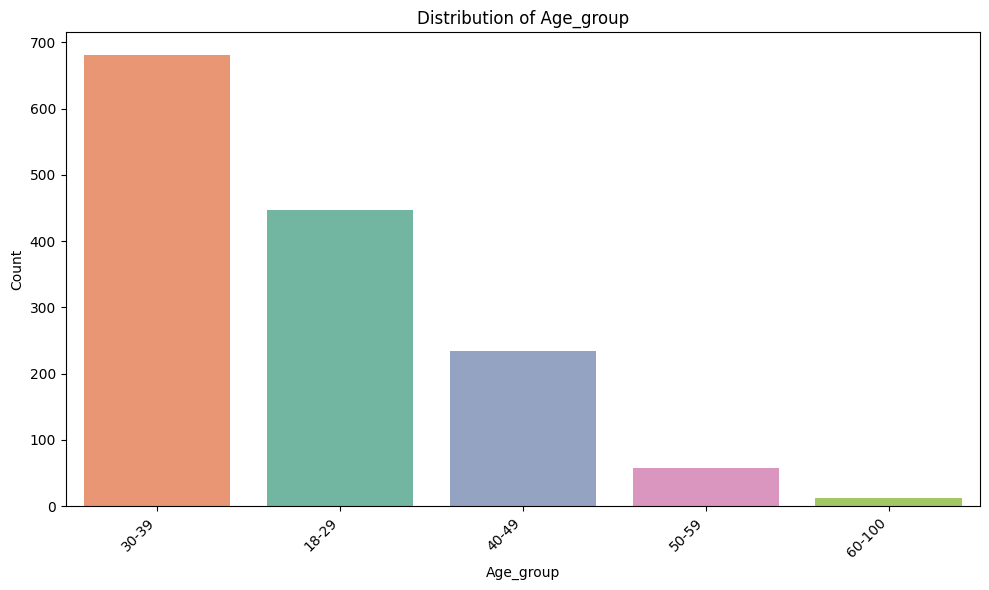

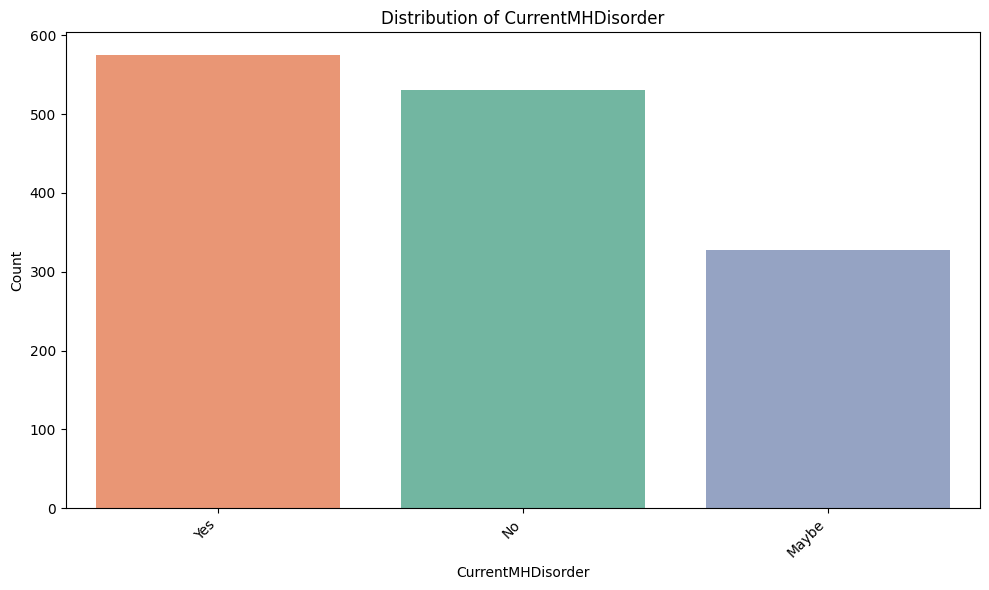

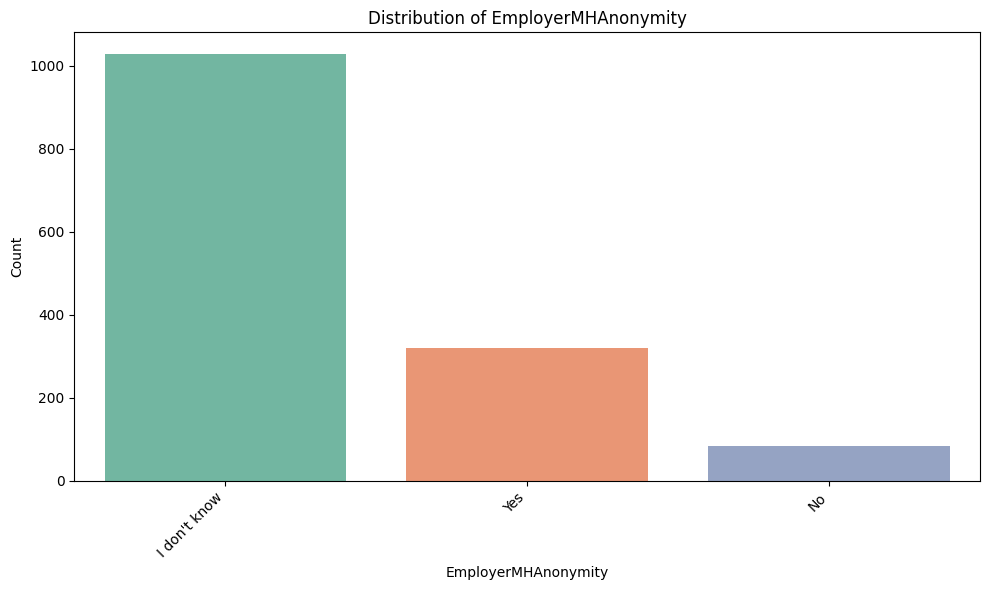

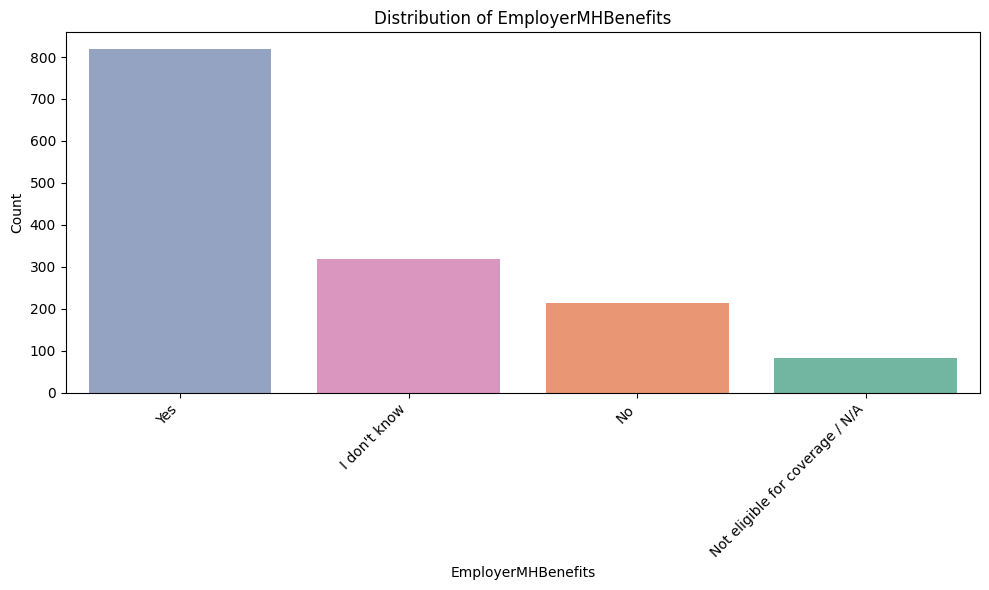

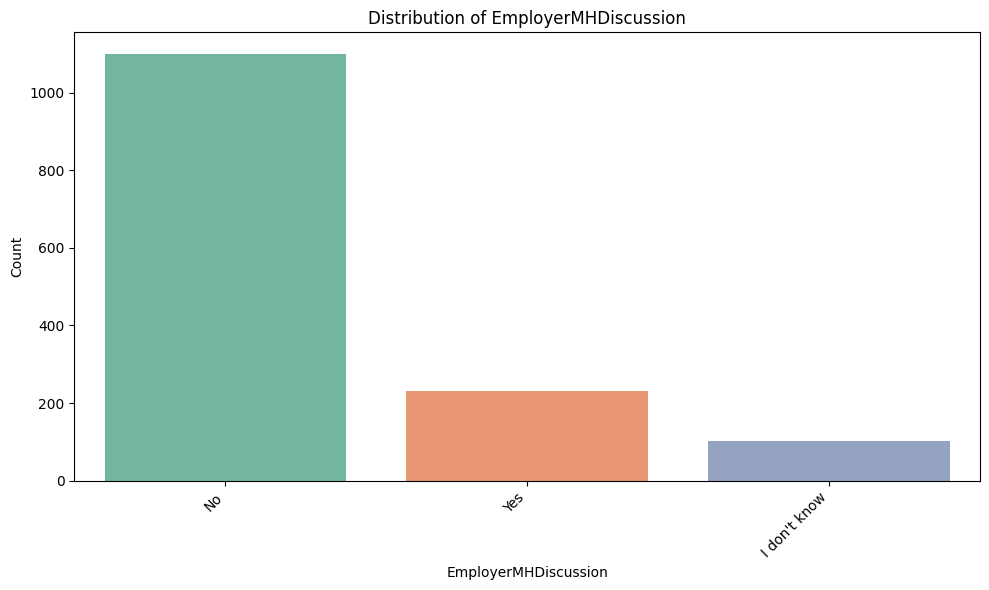

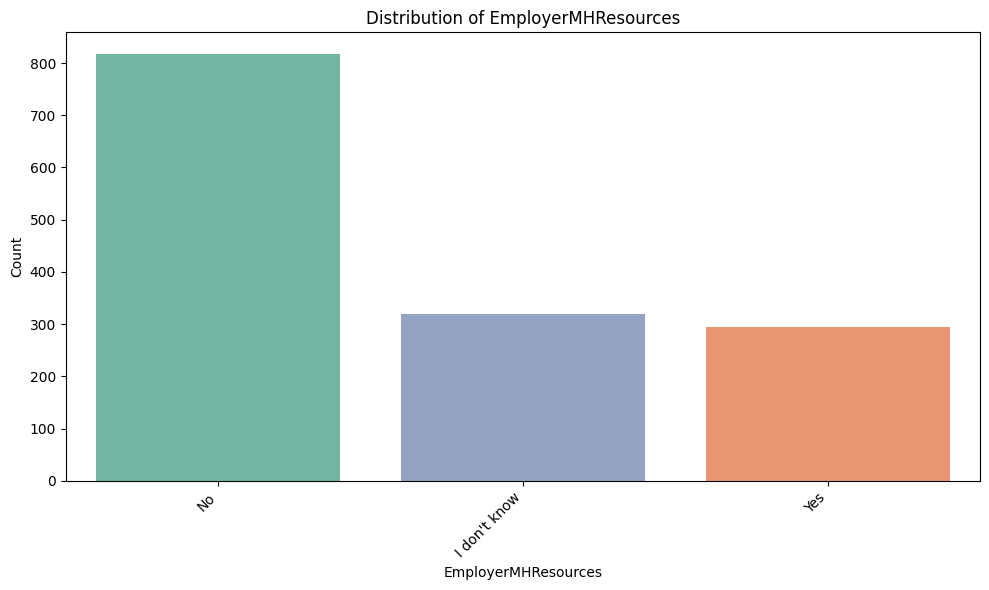

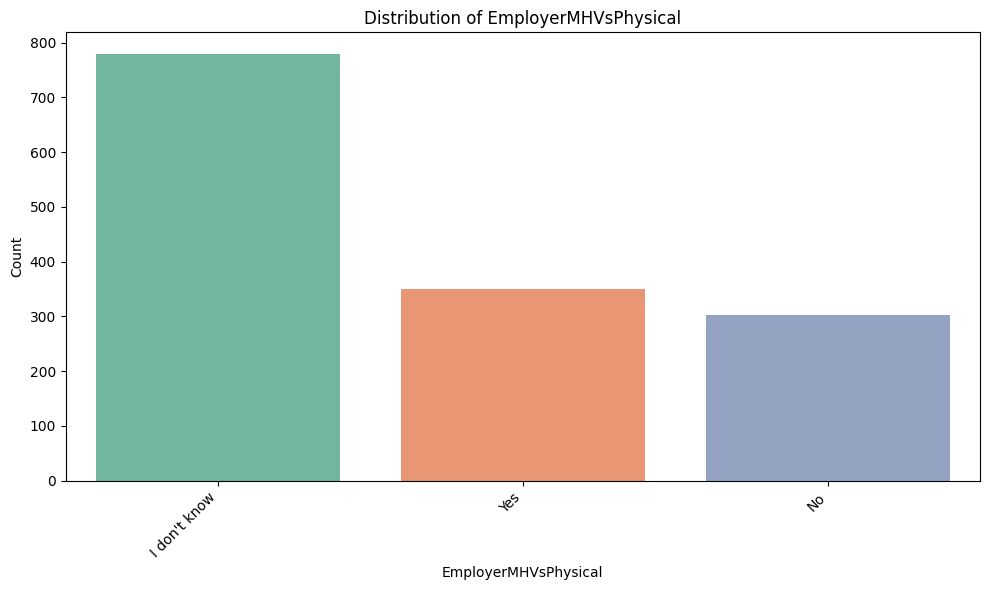

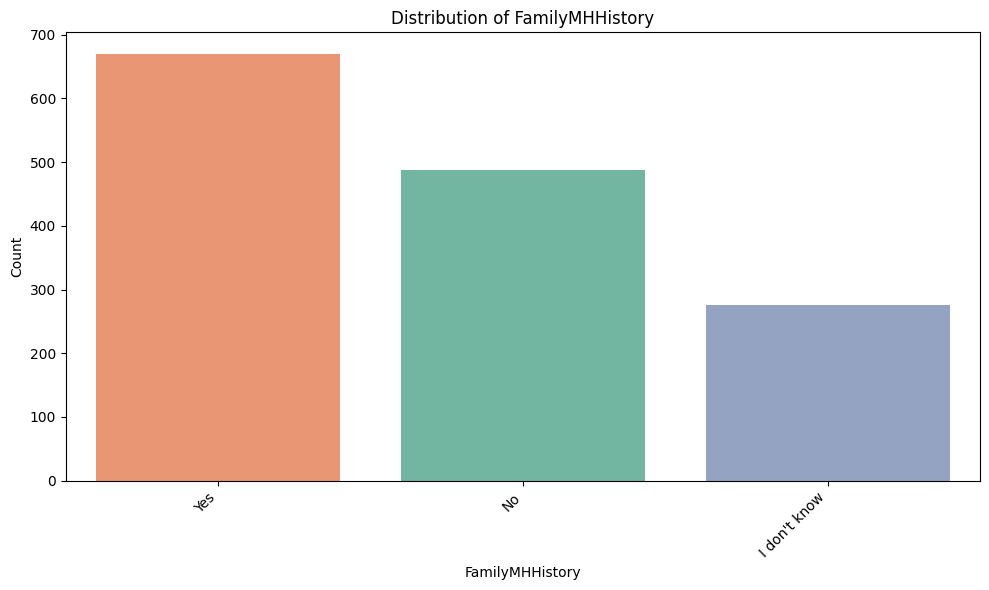

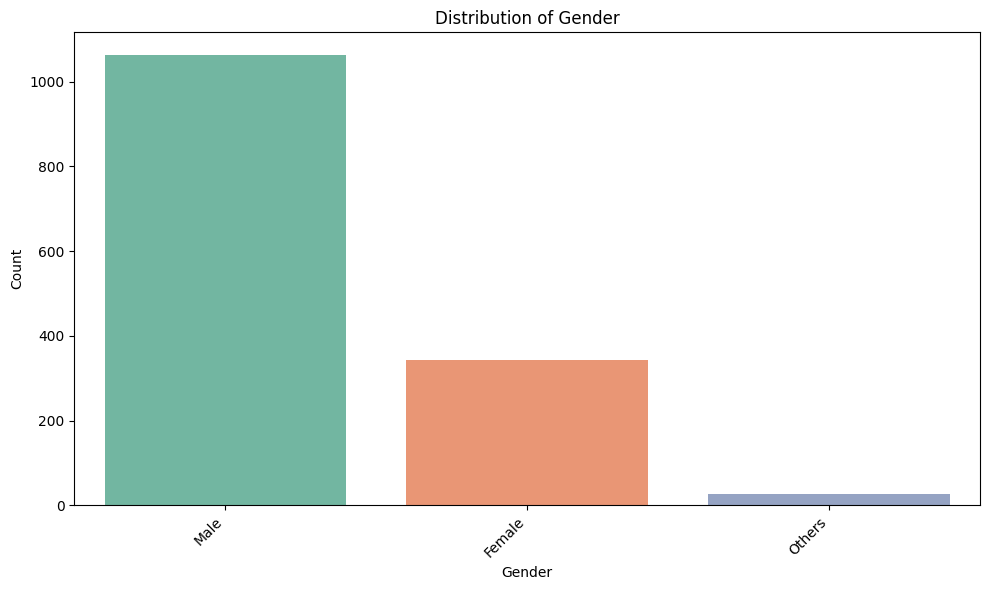

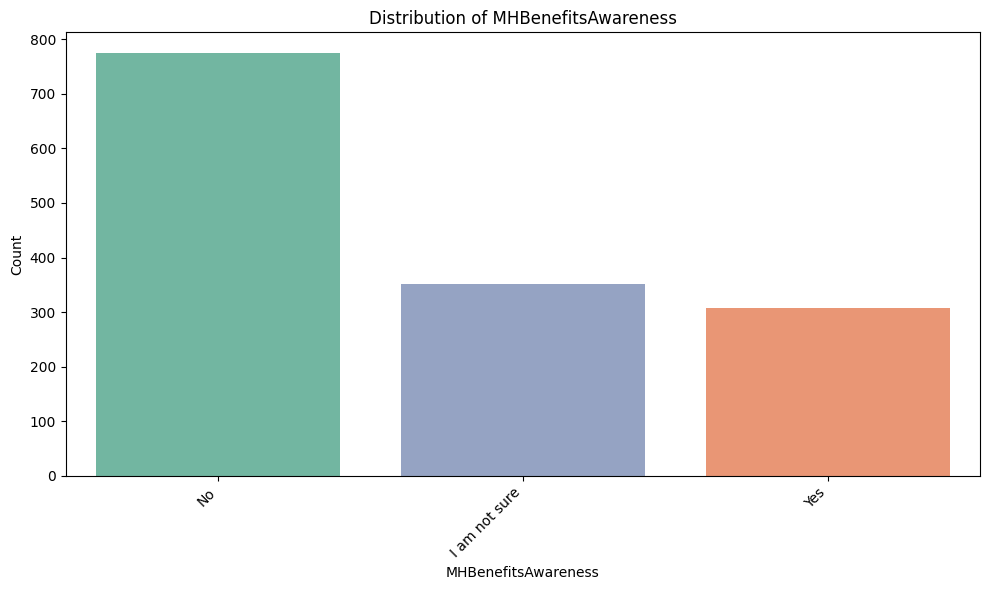

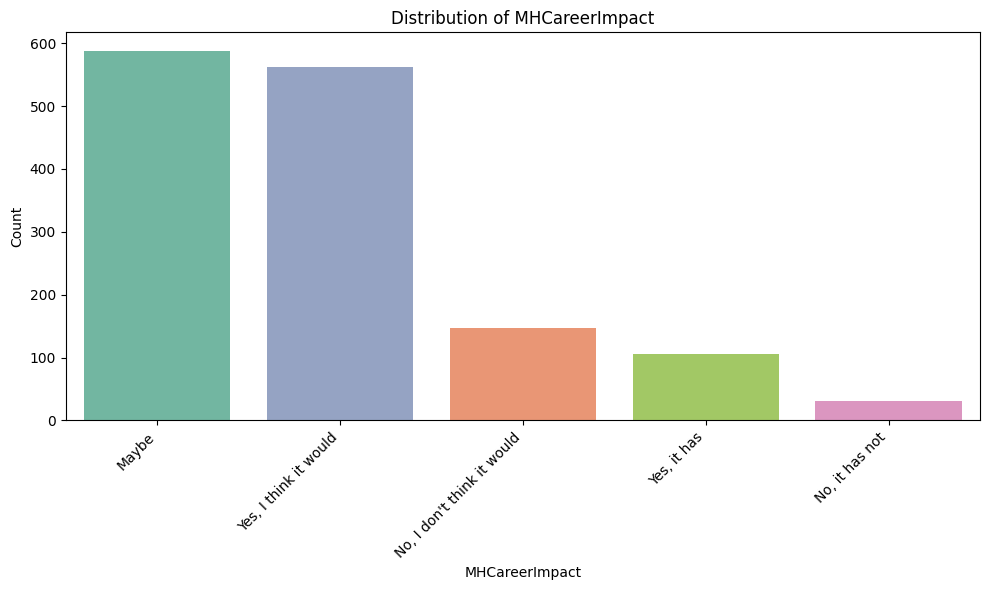

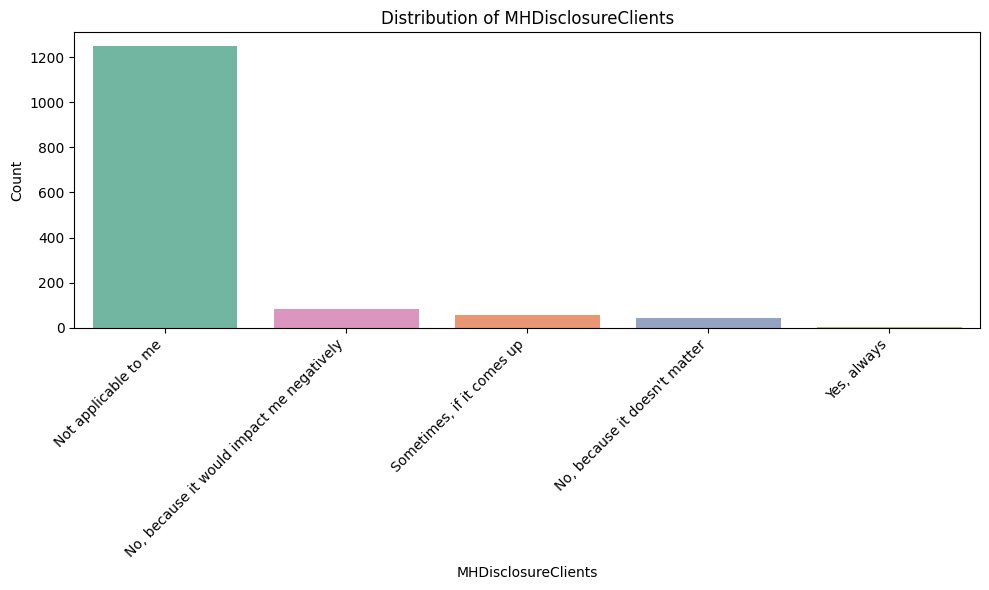

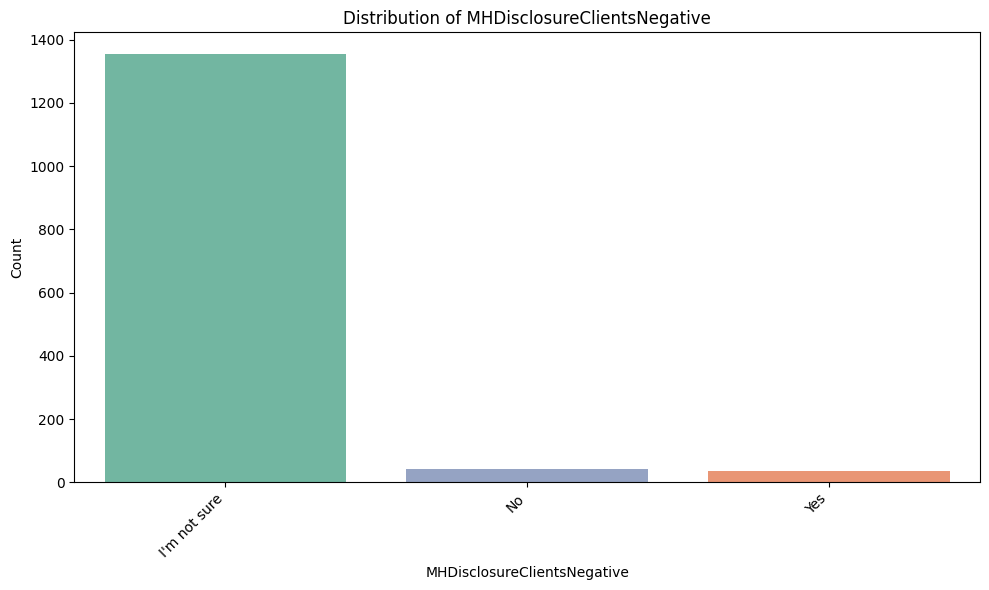

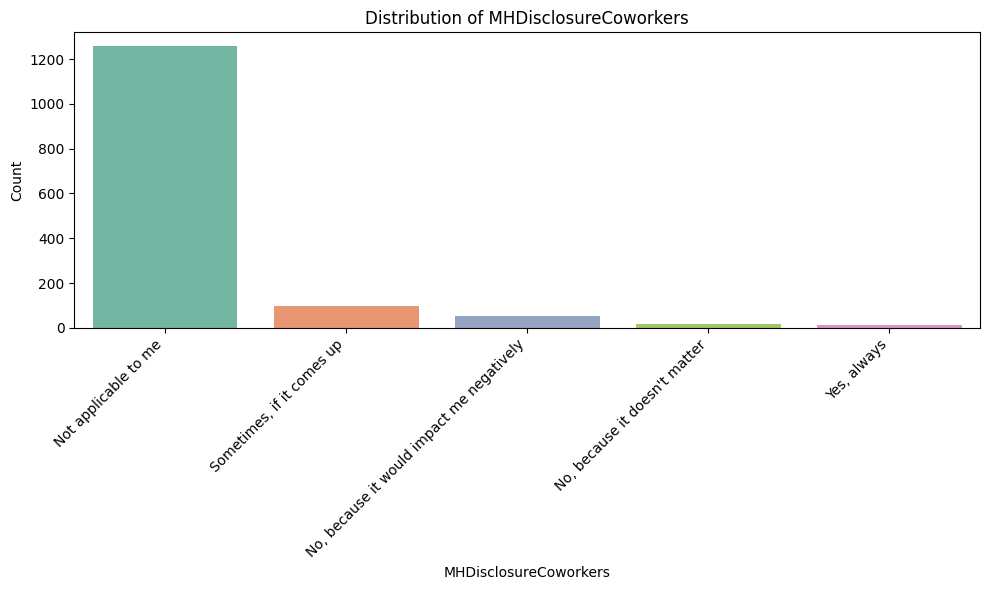

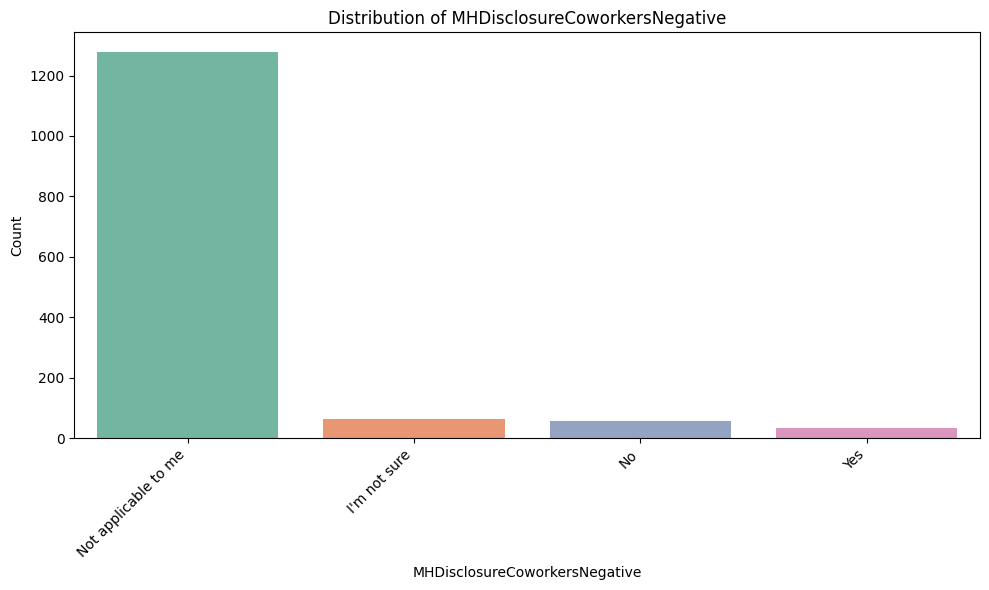

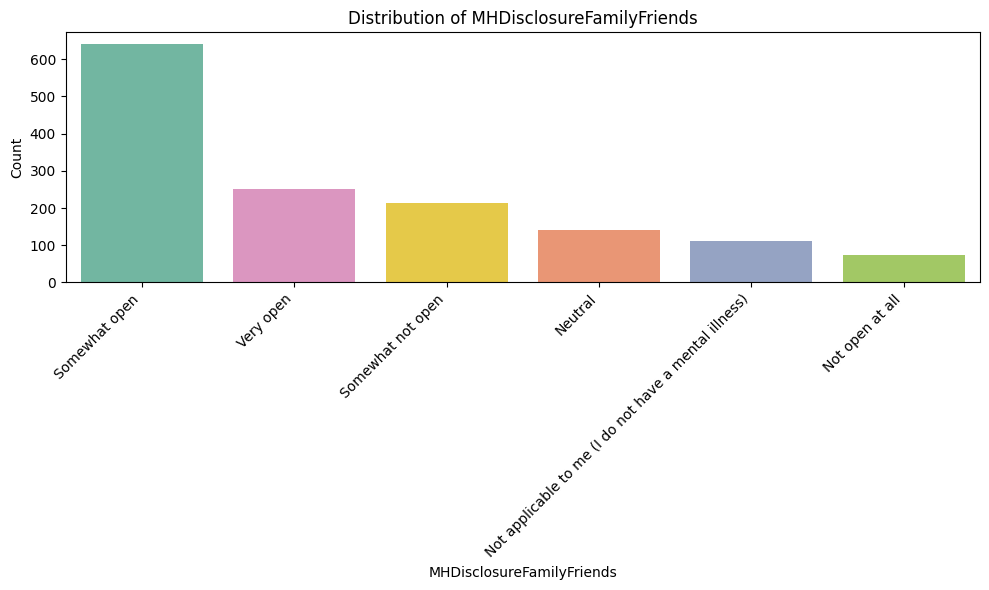

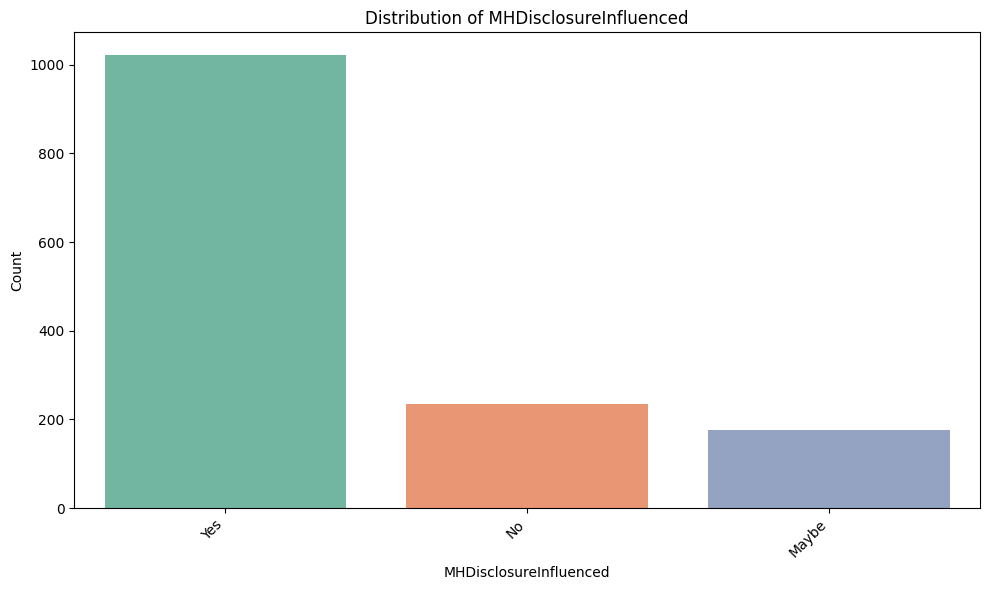

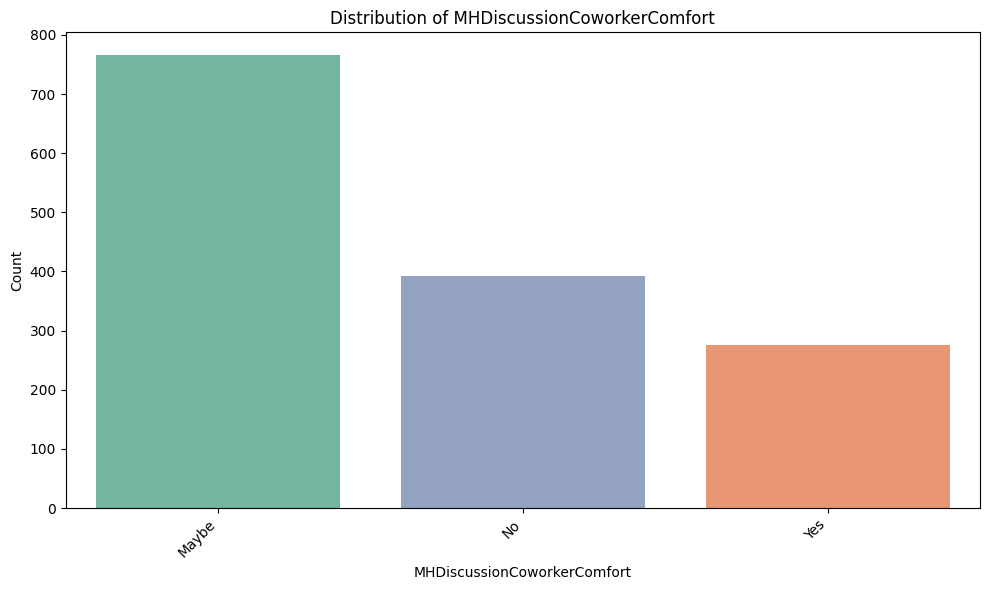

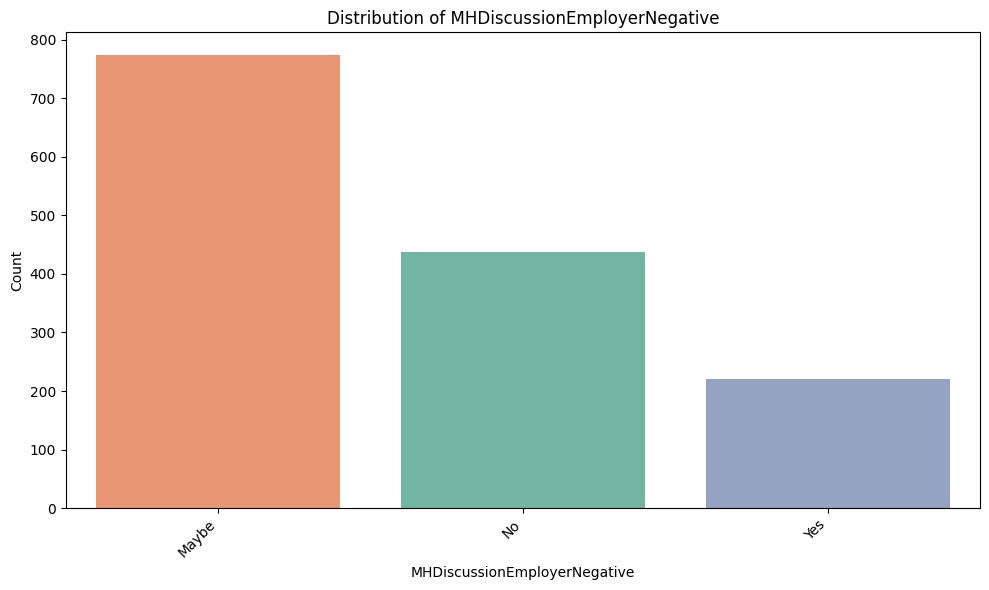

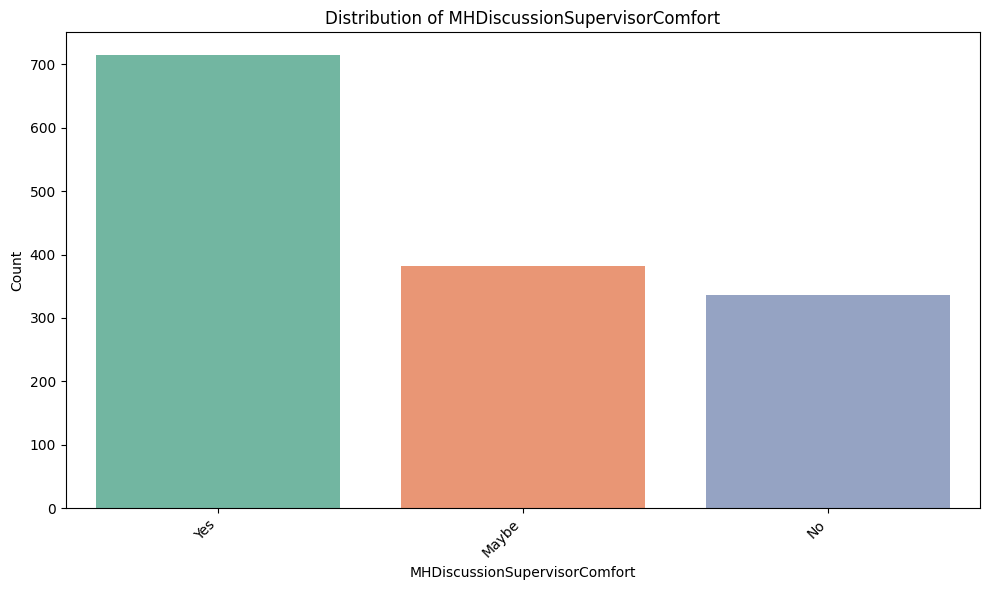

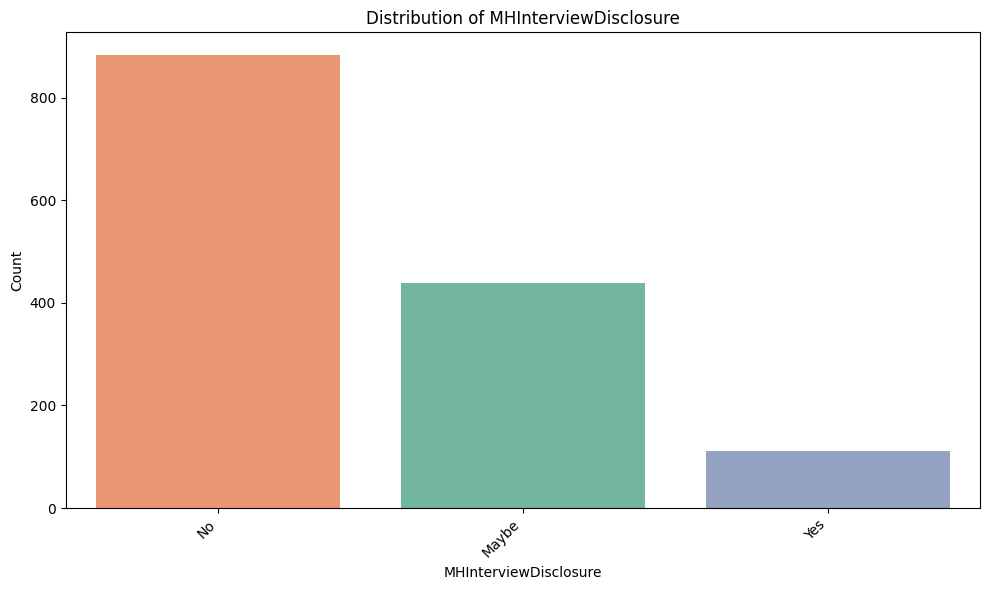

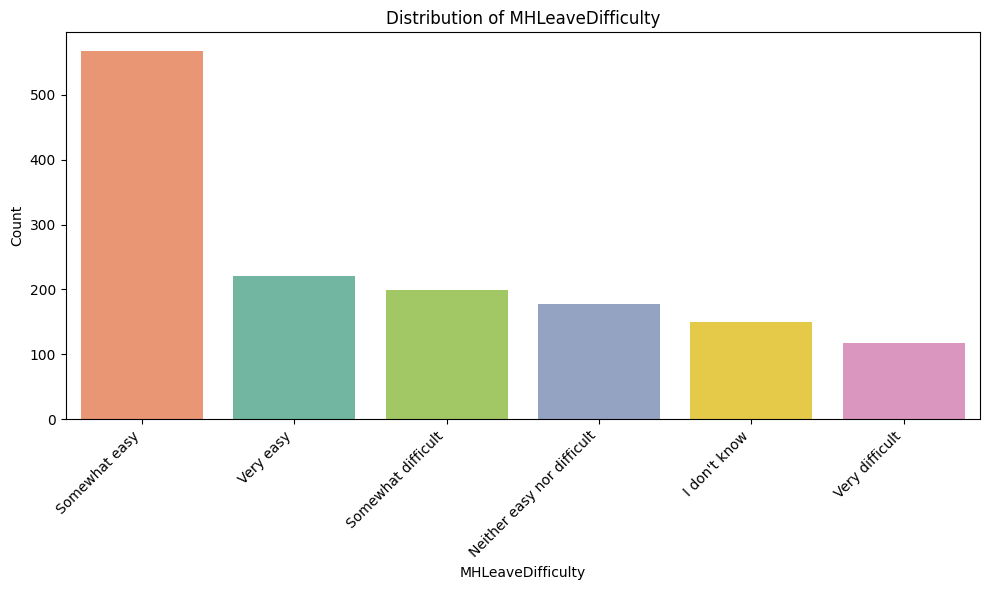

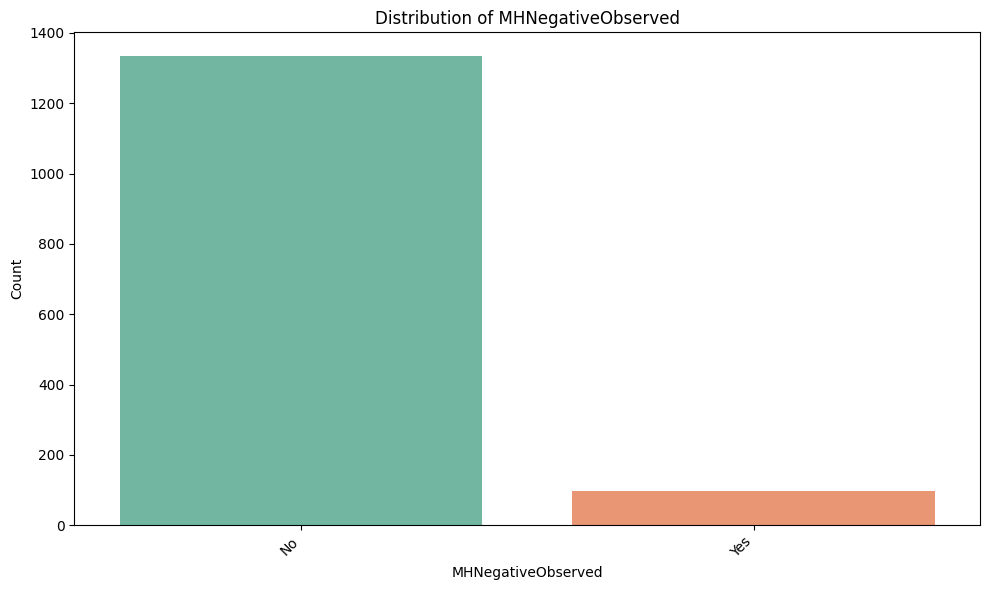

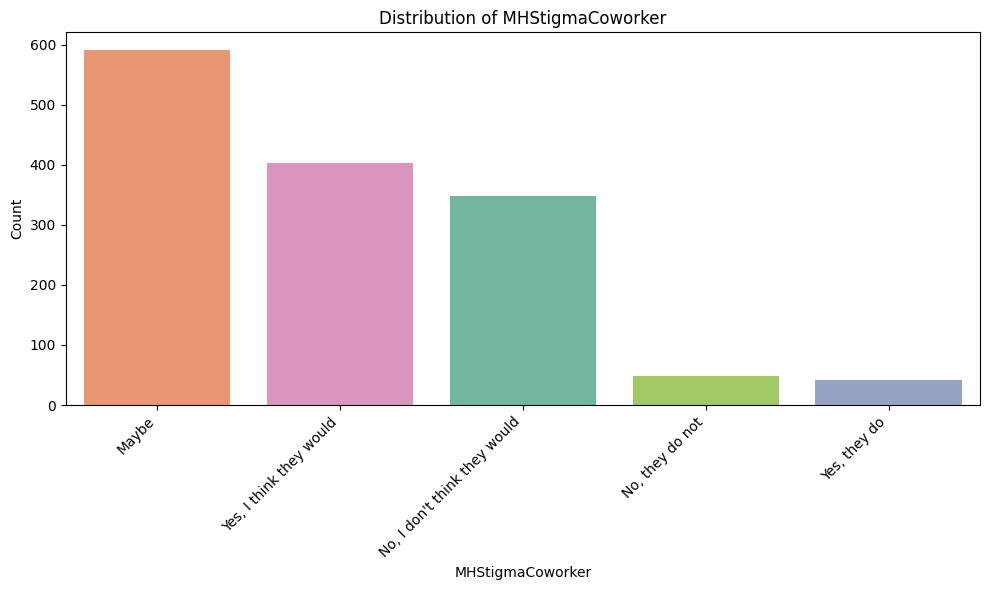

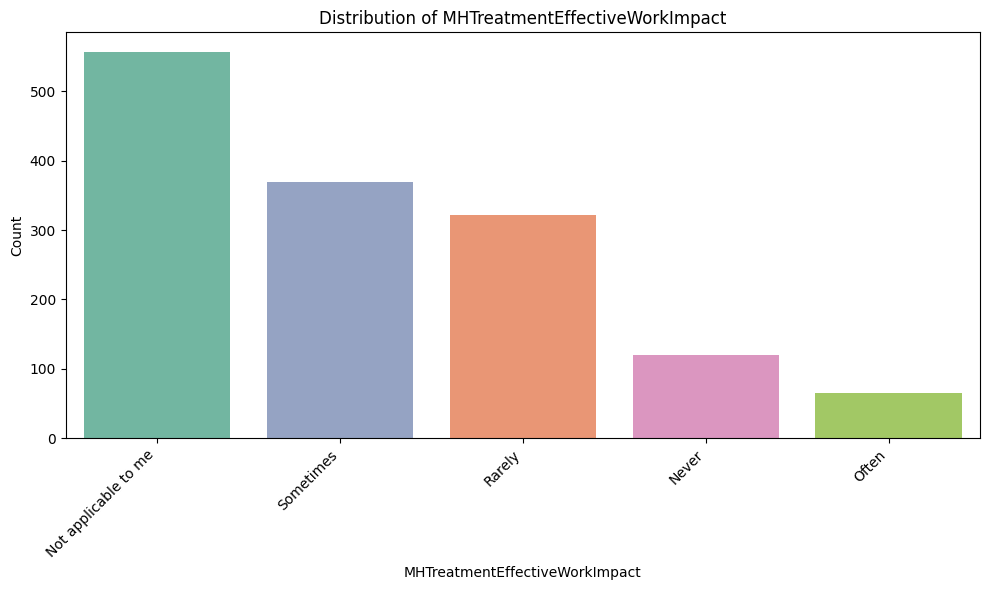

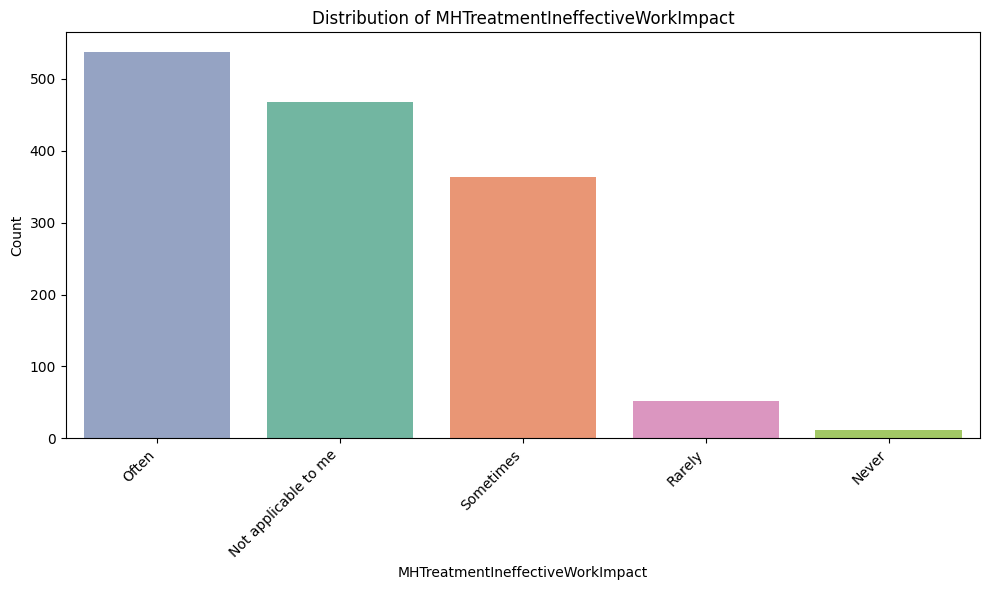

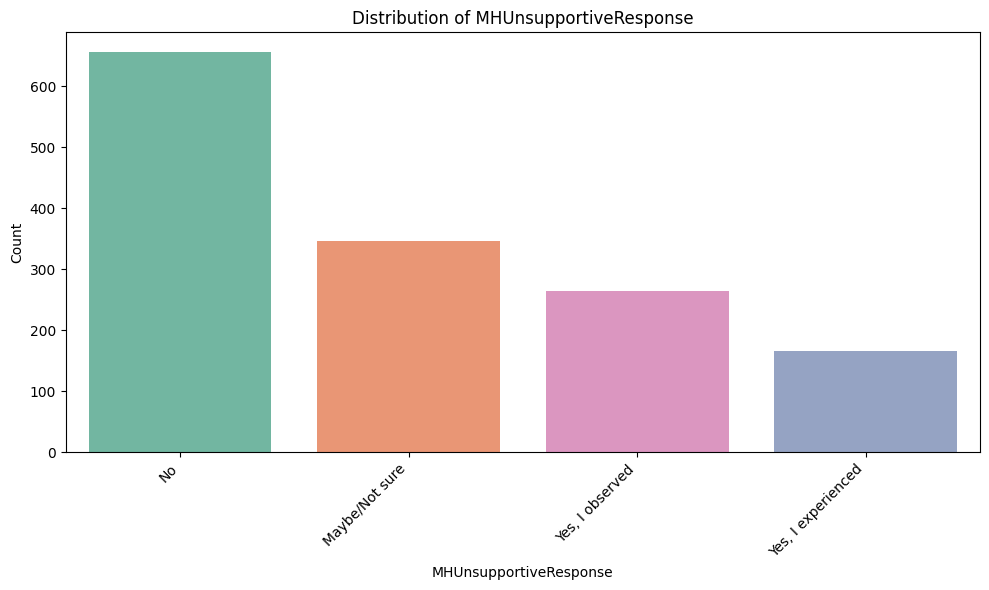

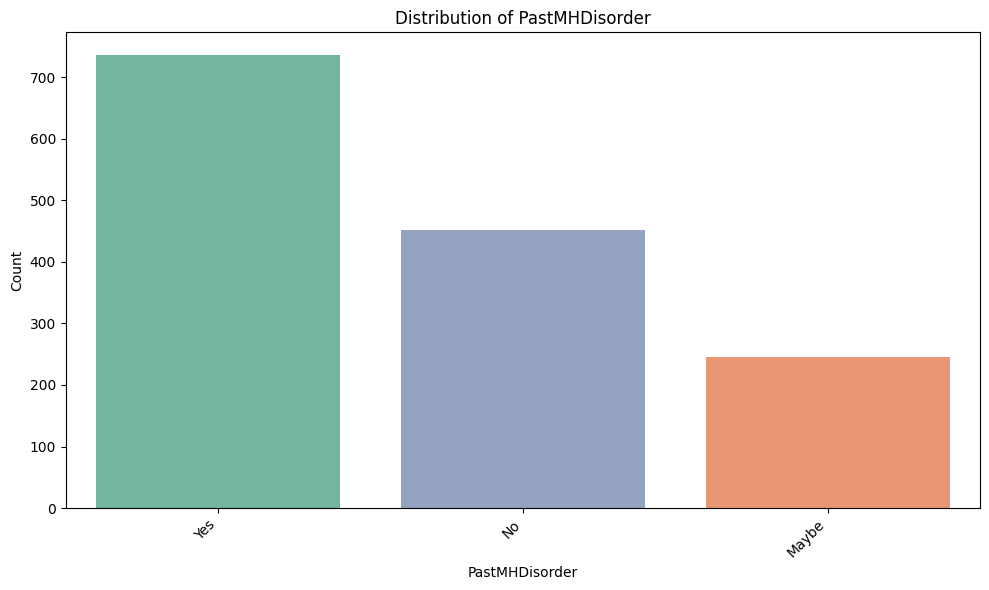

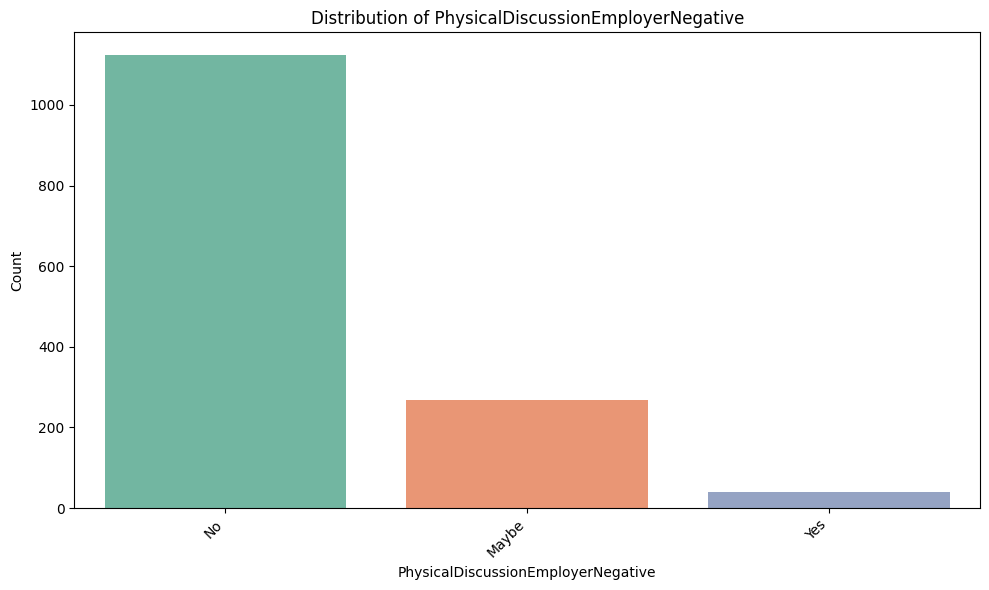

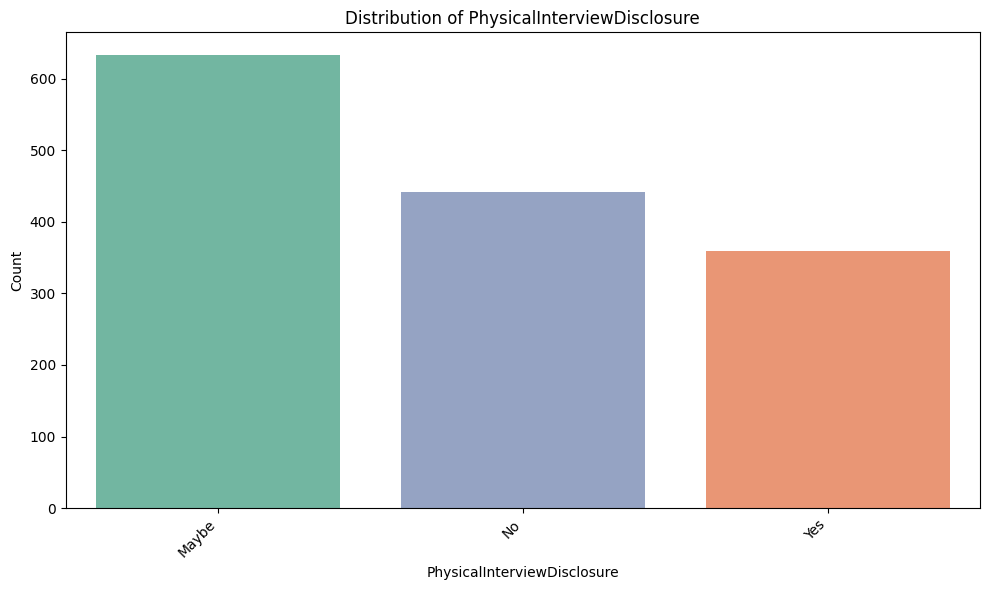

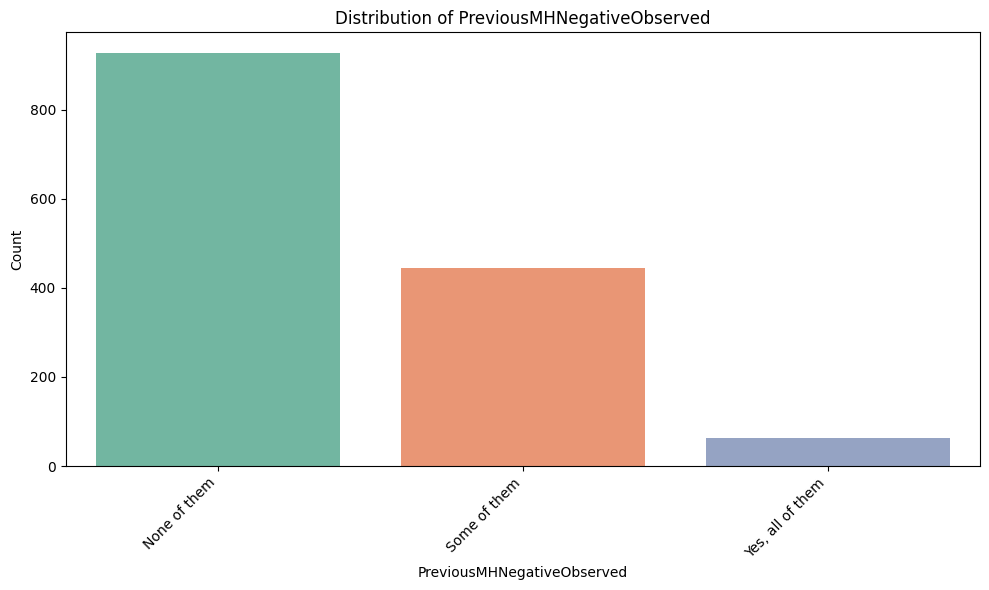

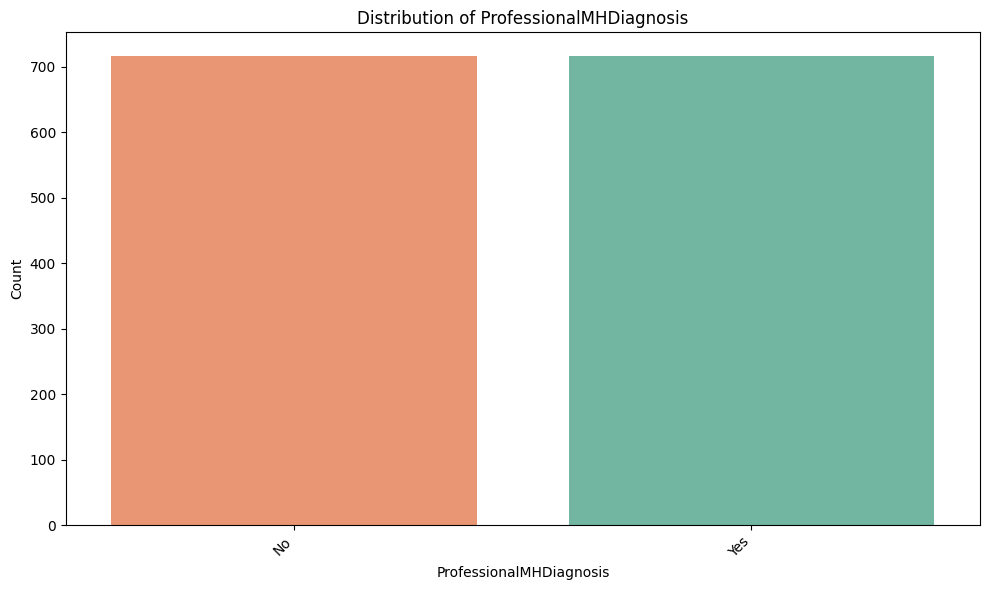

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


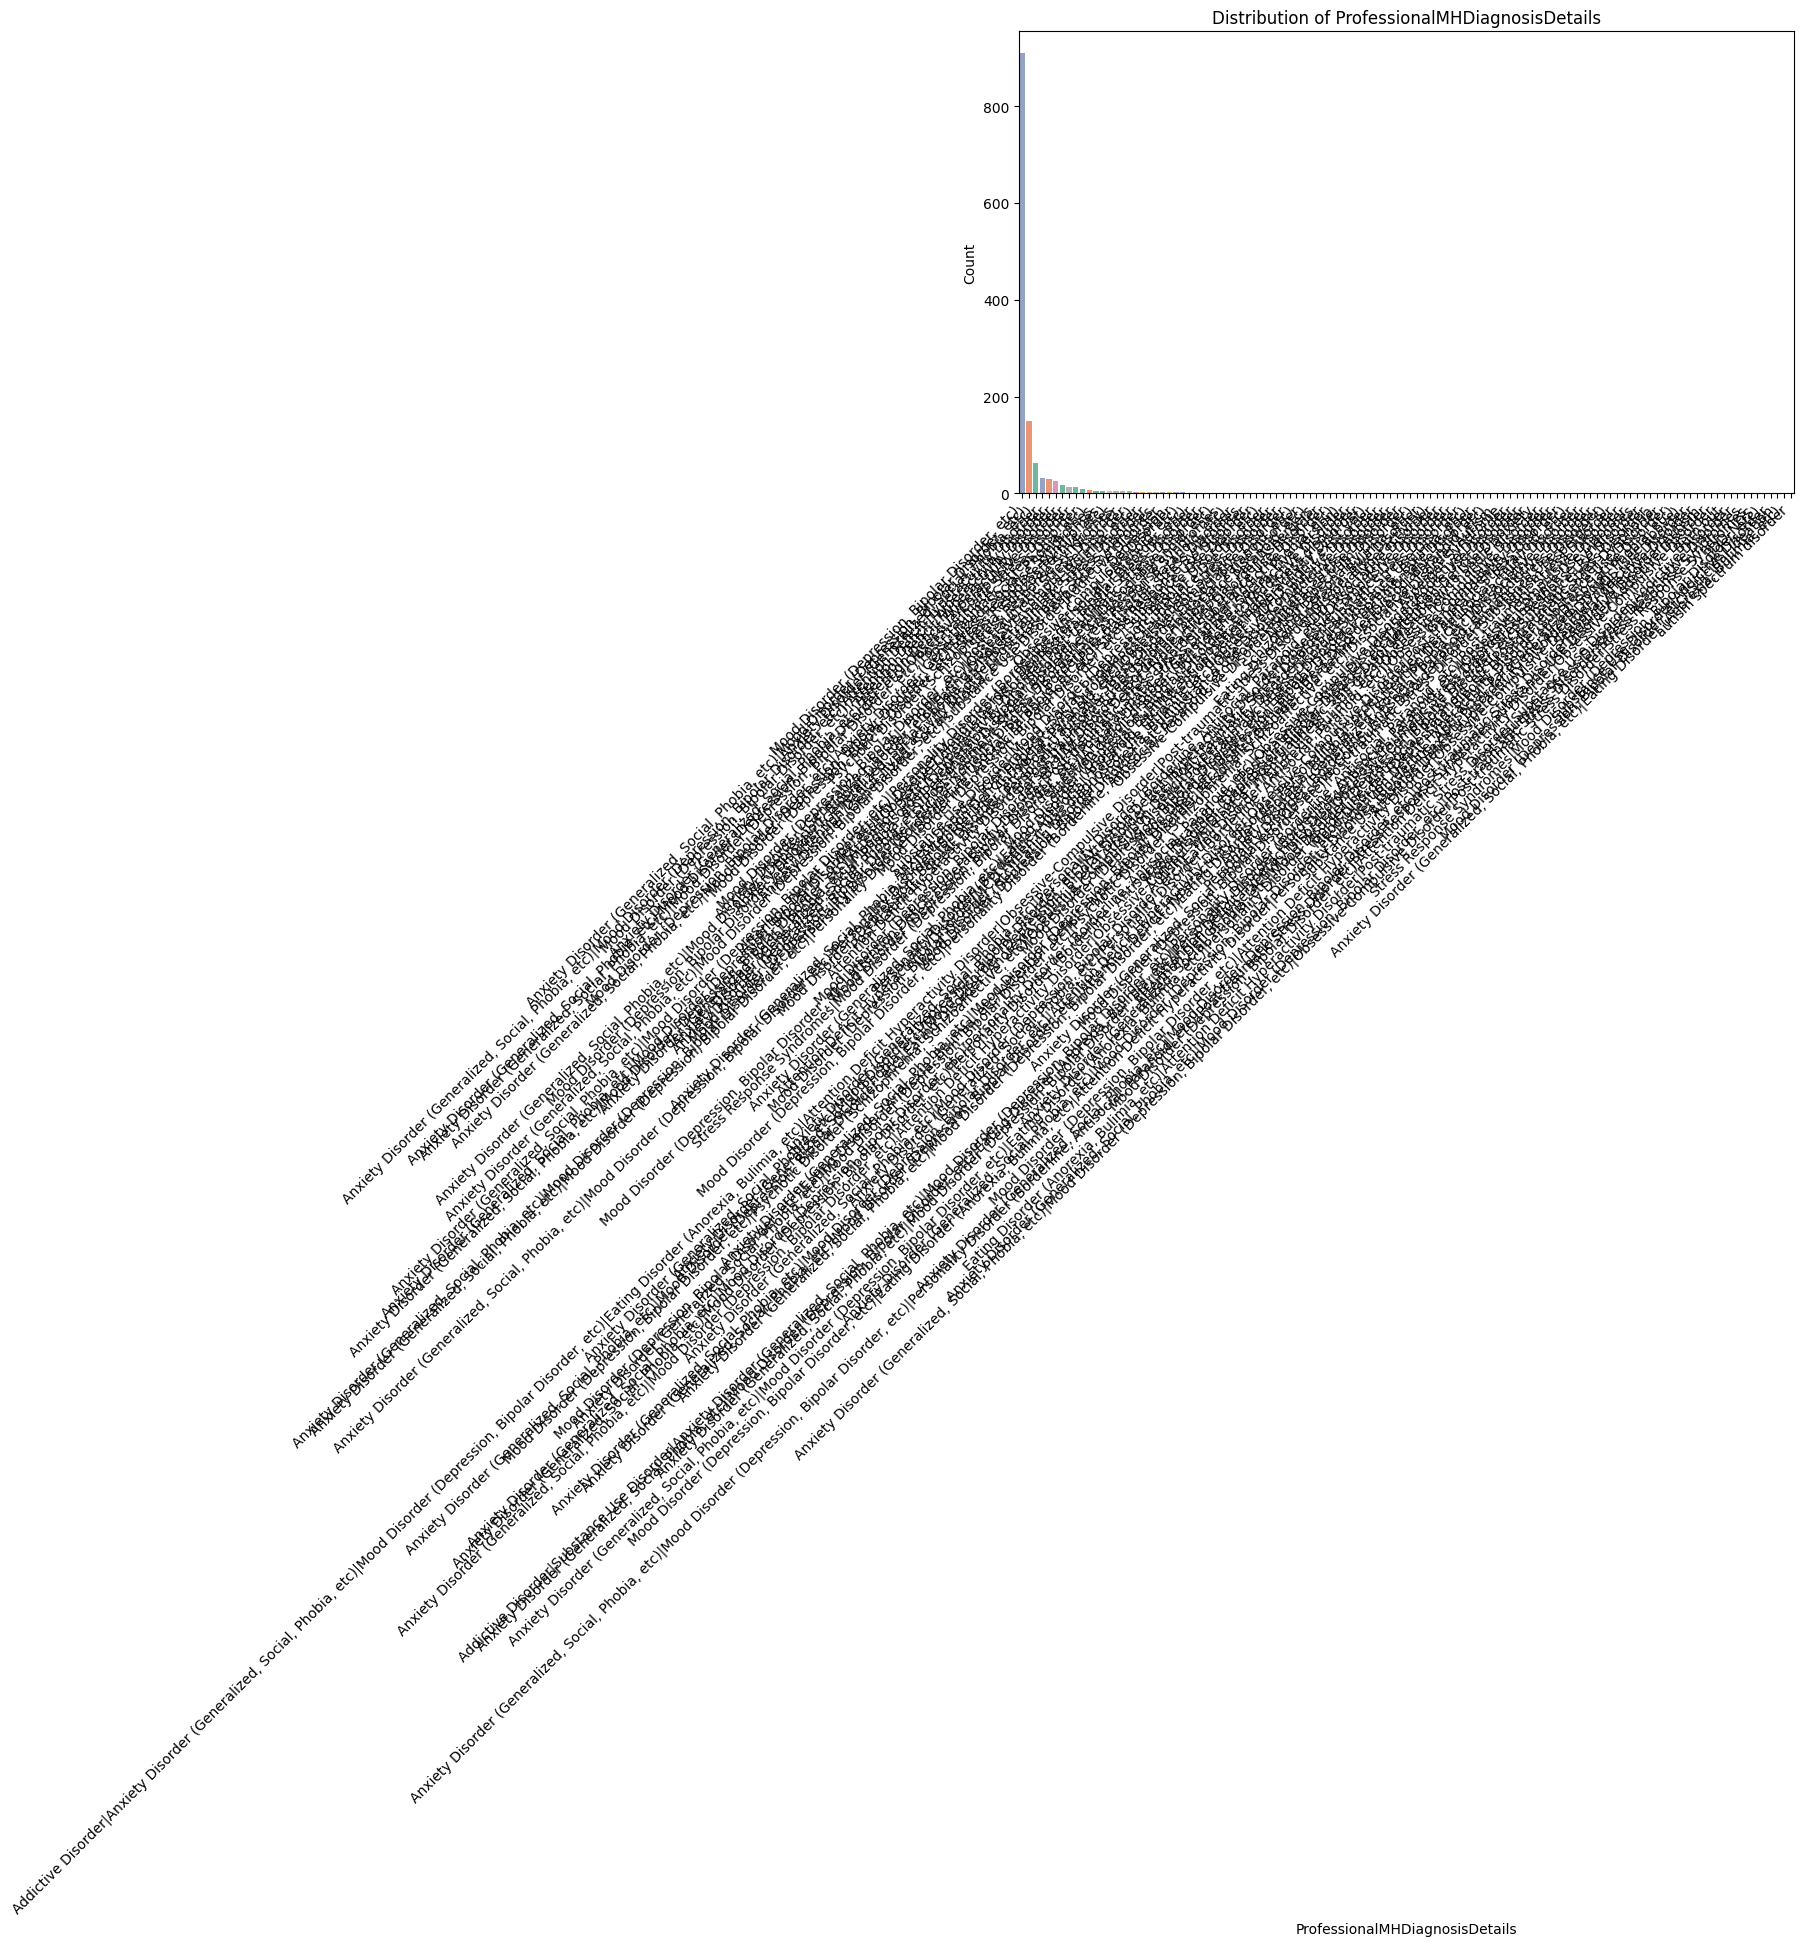

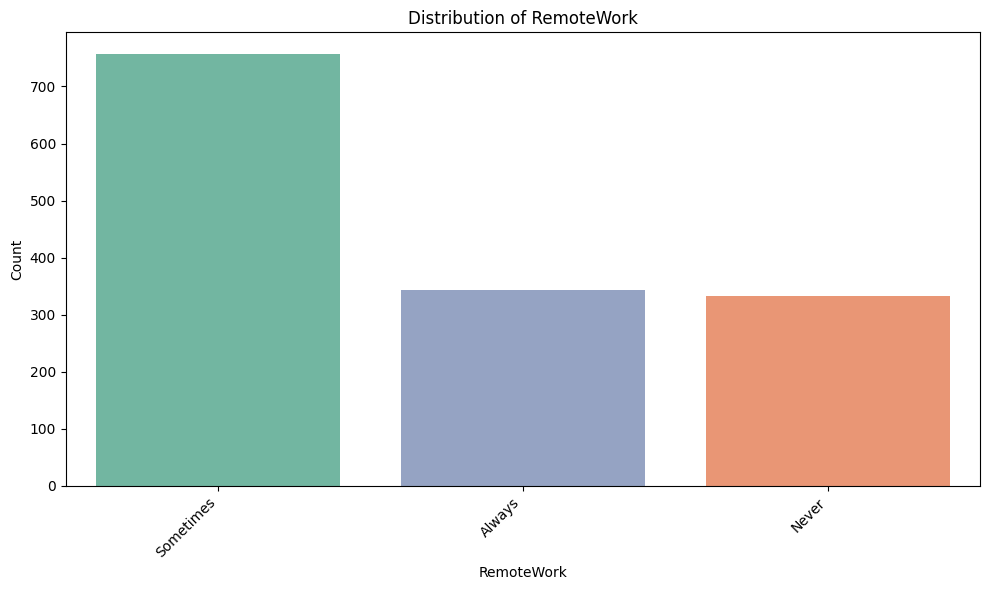

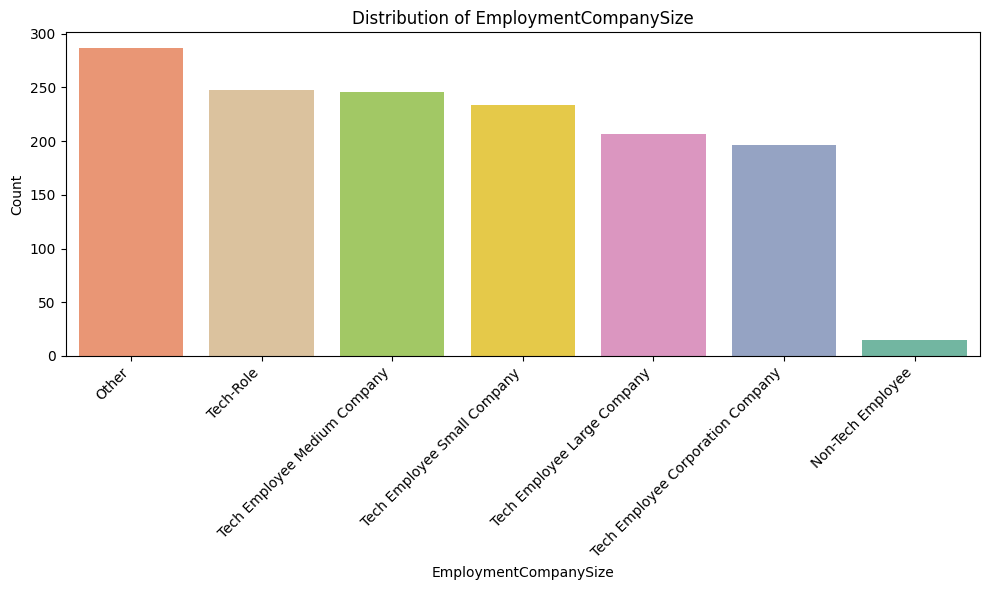

In [23]:
plot_categorical_features(df_cleaned, categorical_cols=categorical_cols)

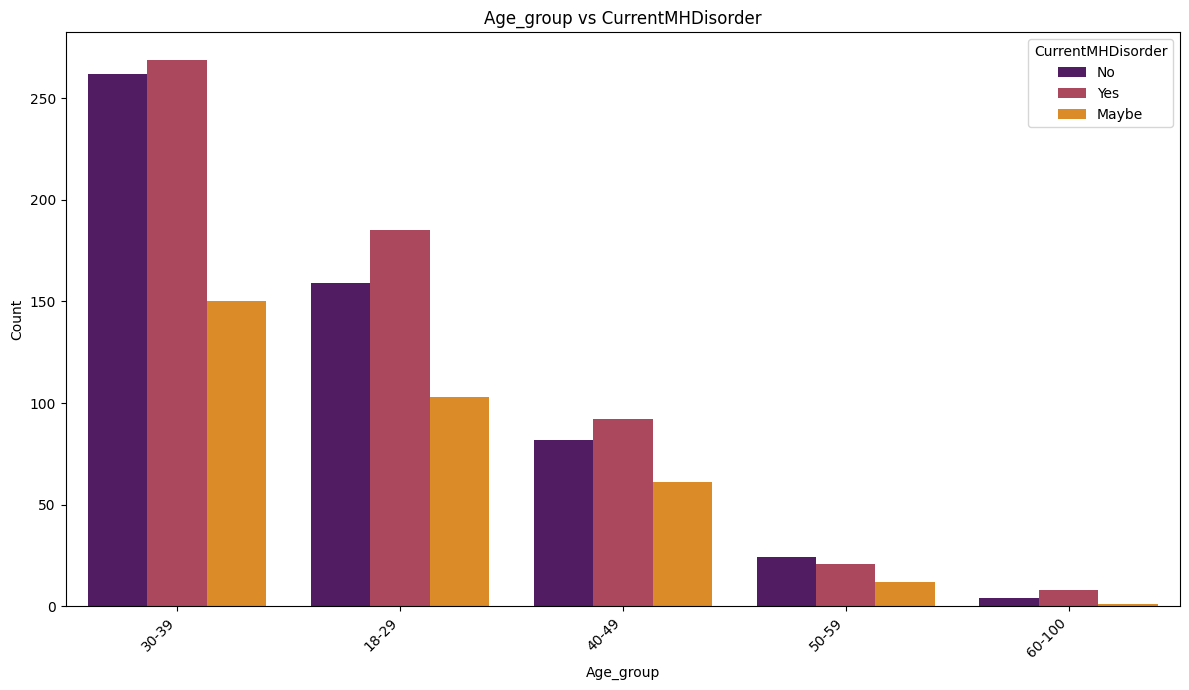

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_variable_name)


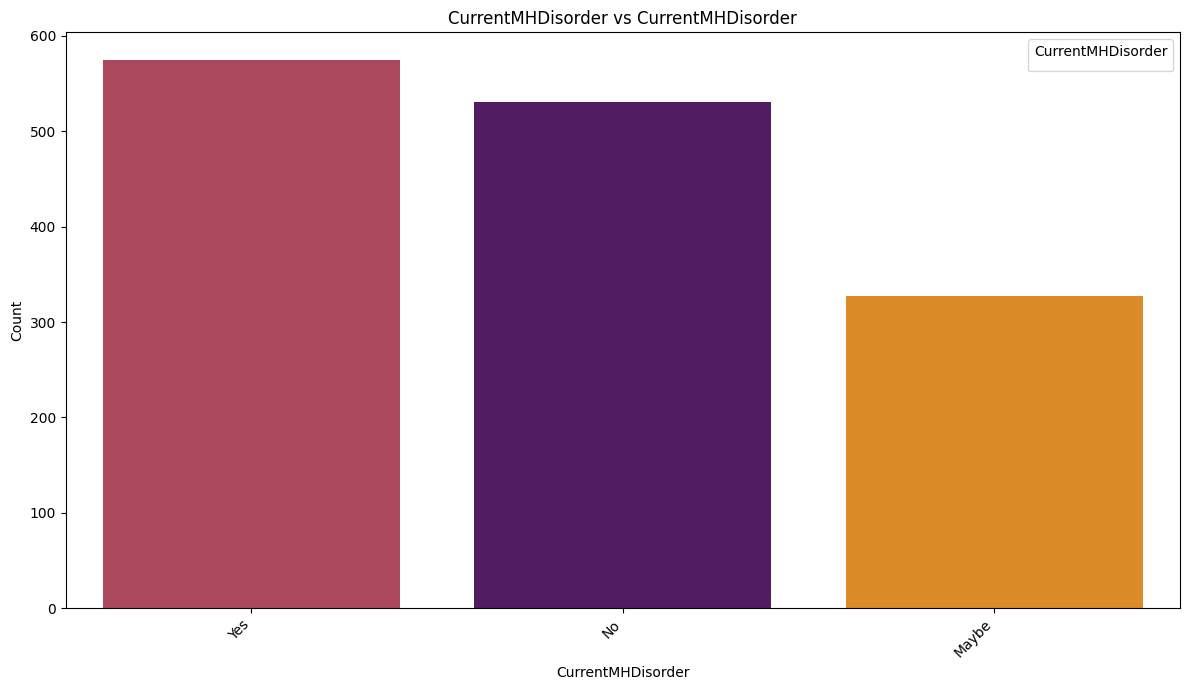

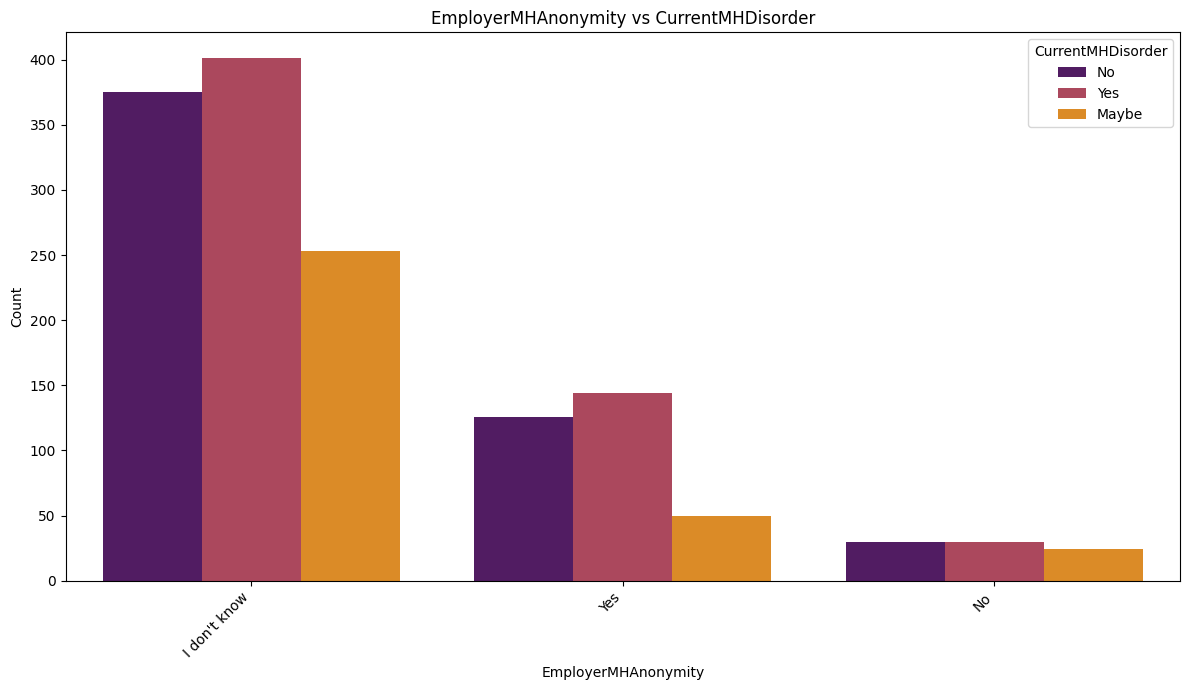

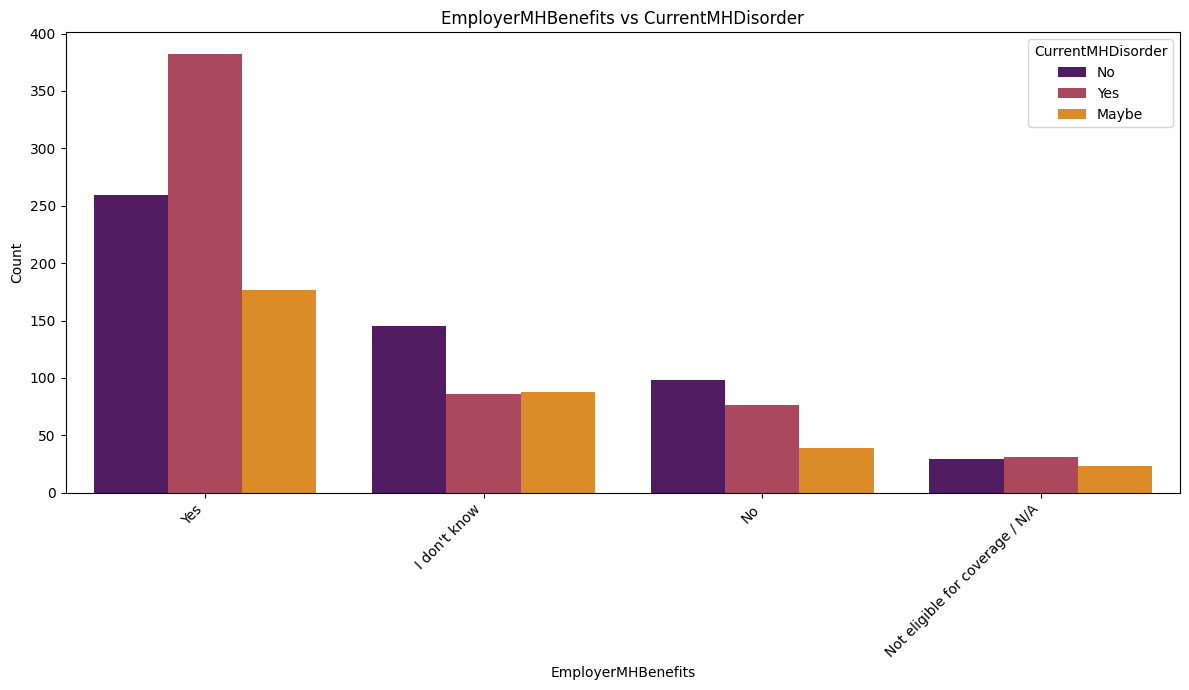

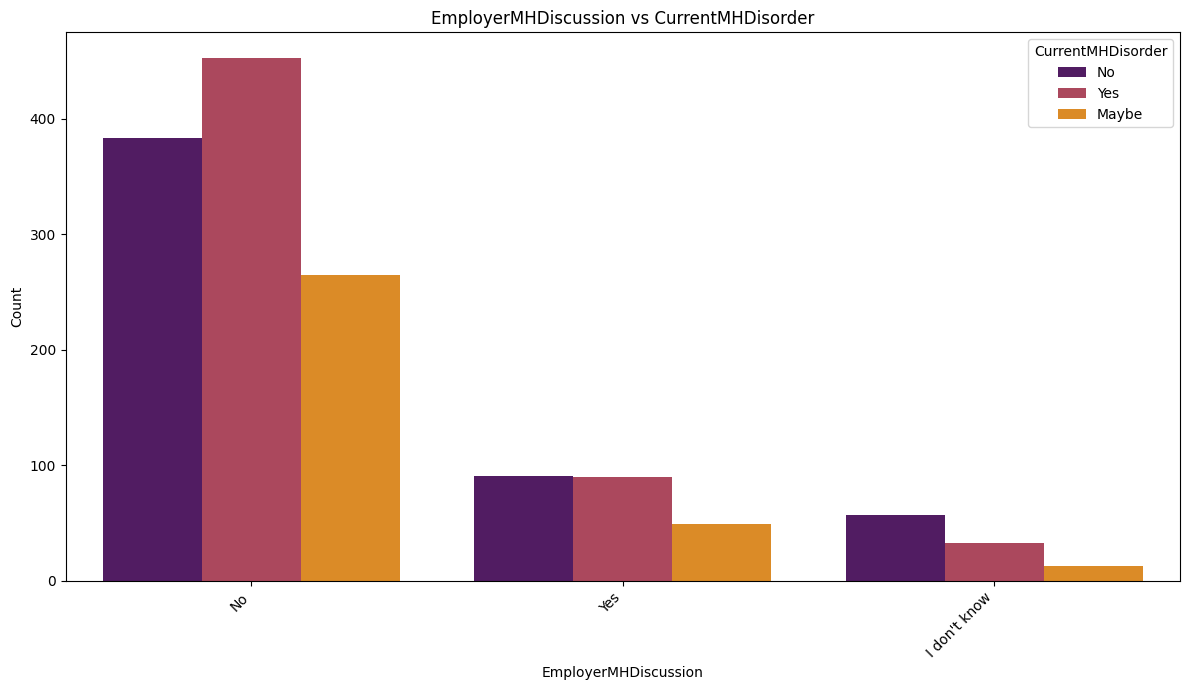

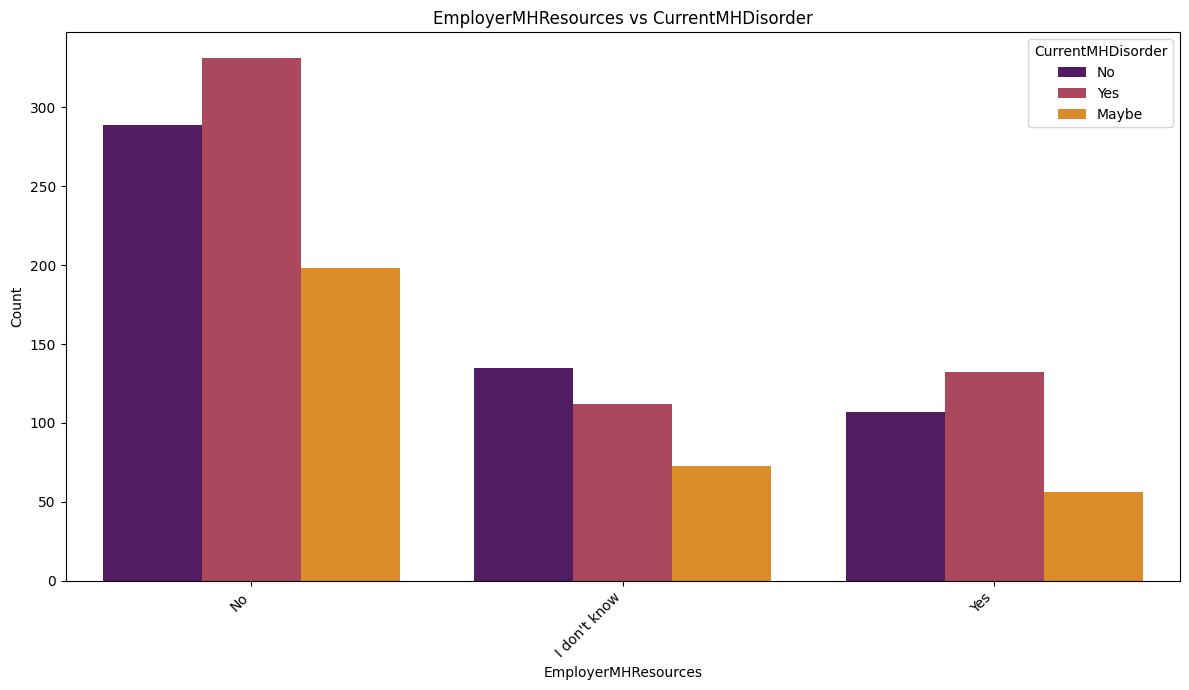

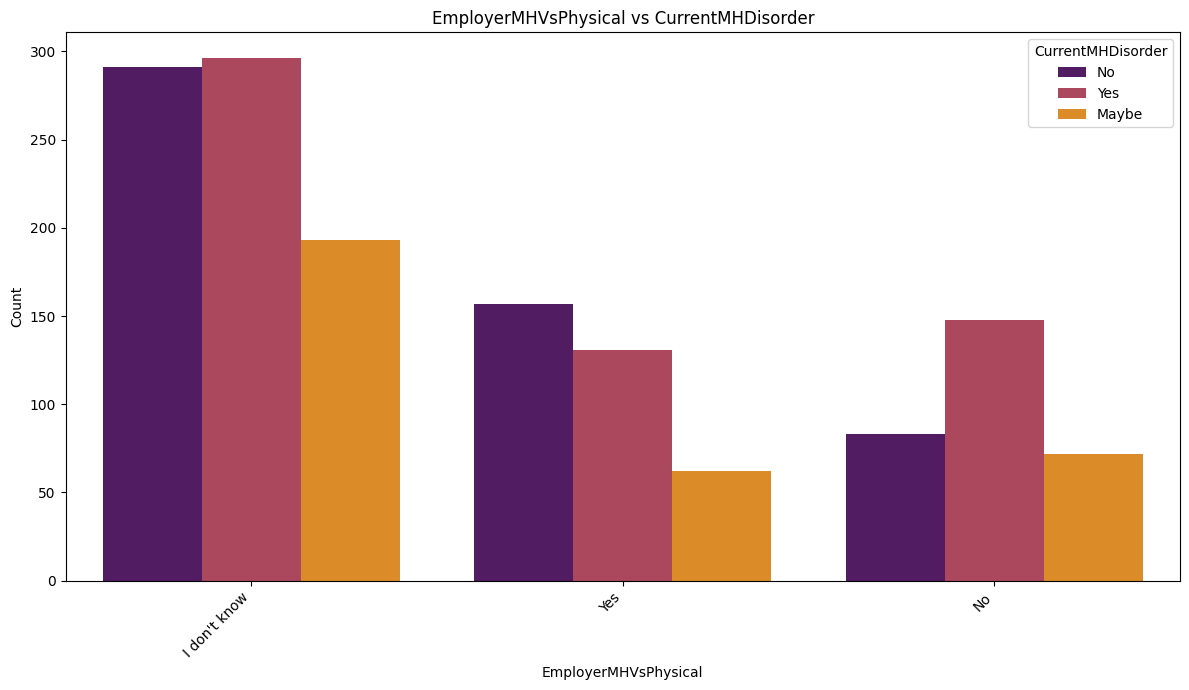

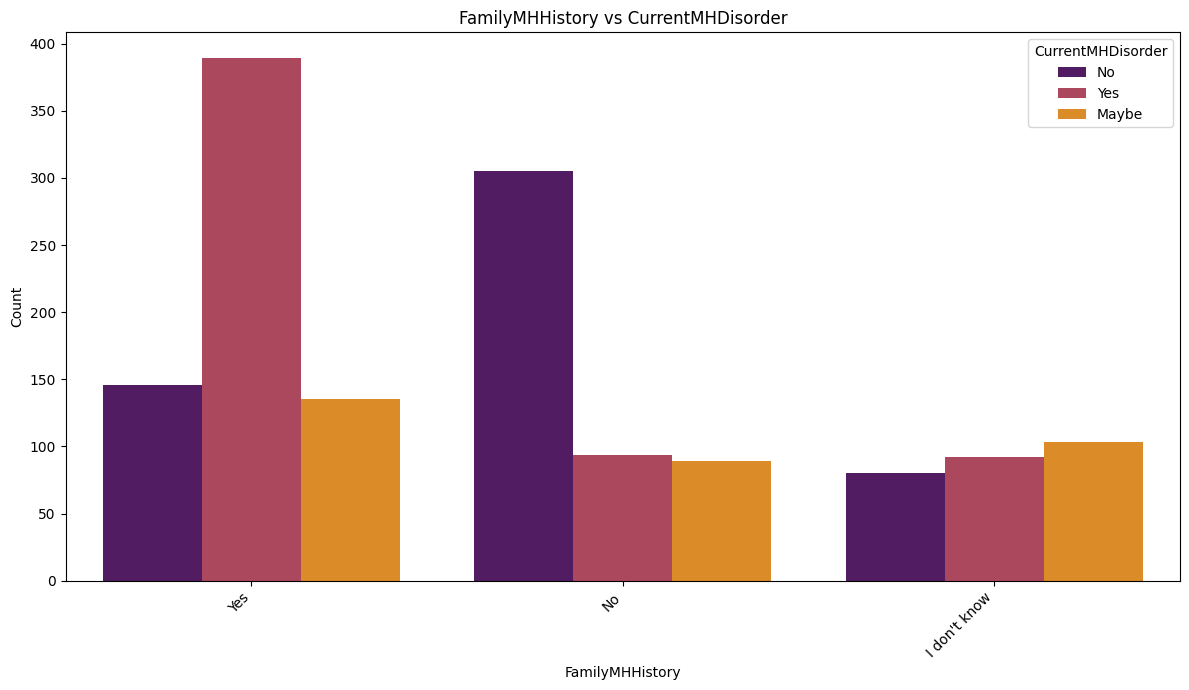

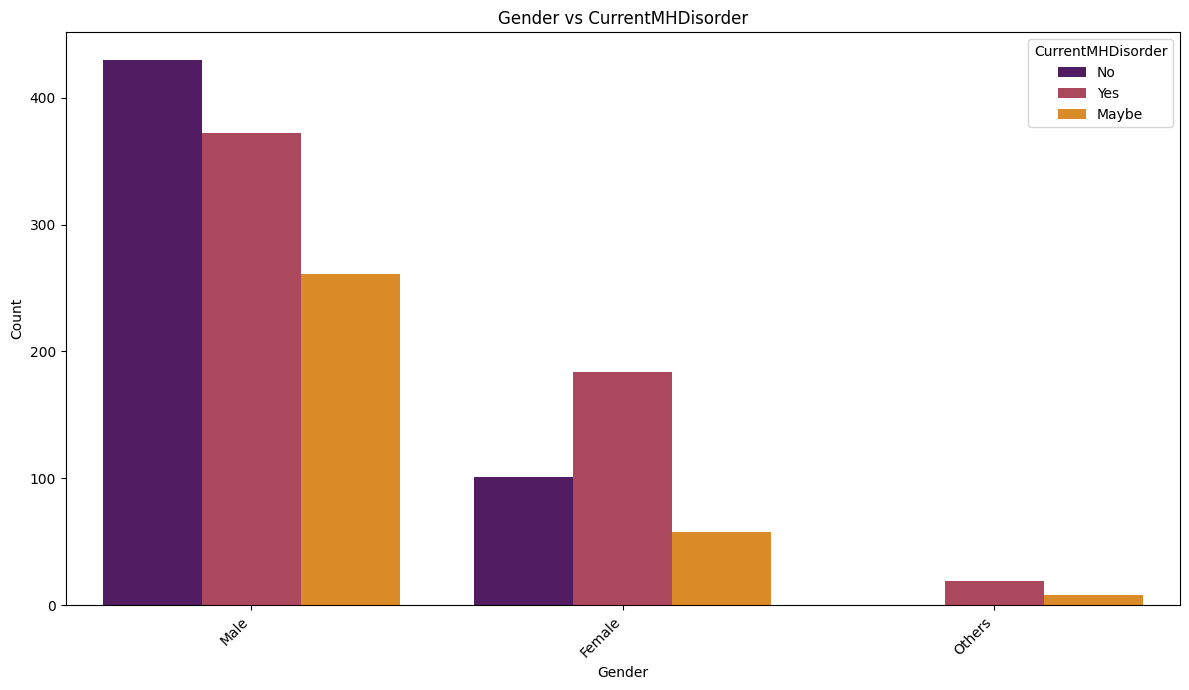

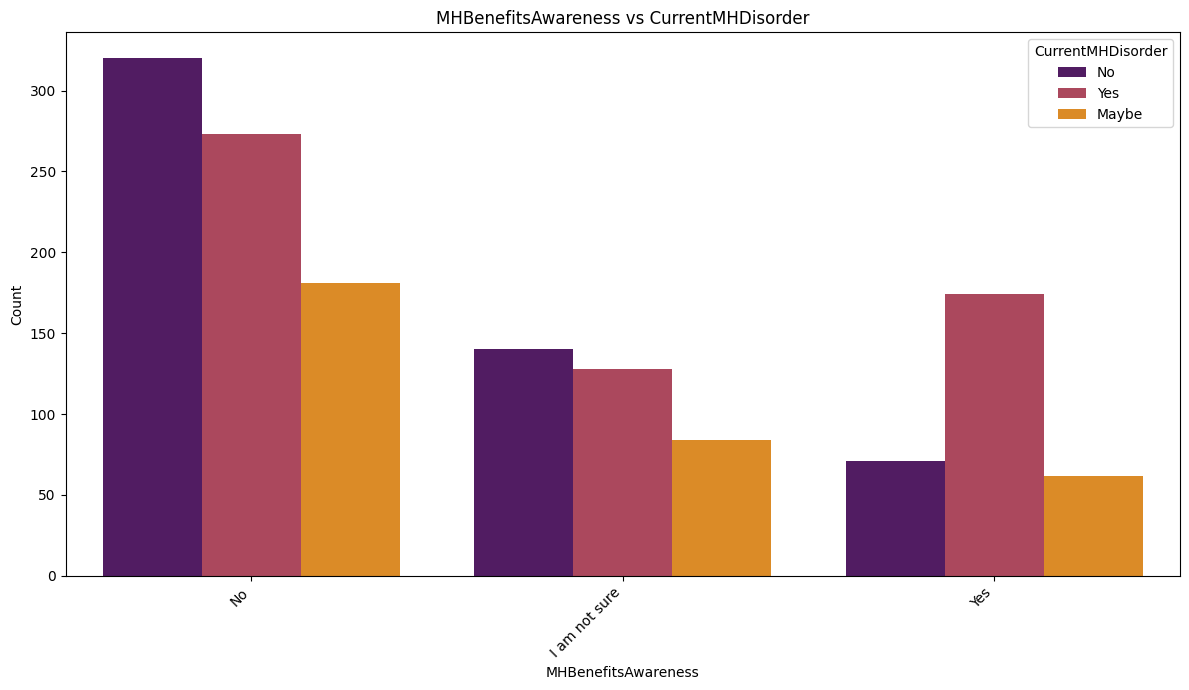

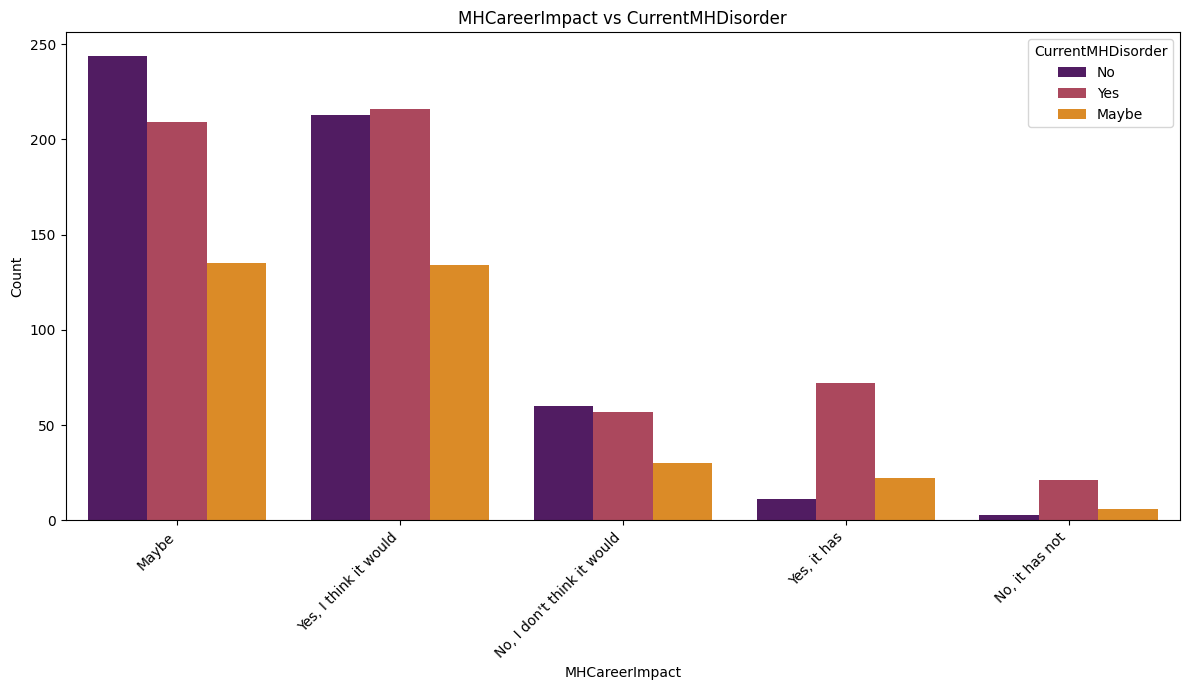

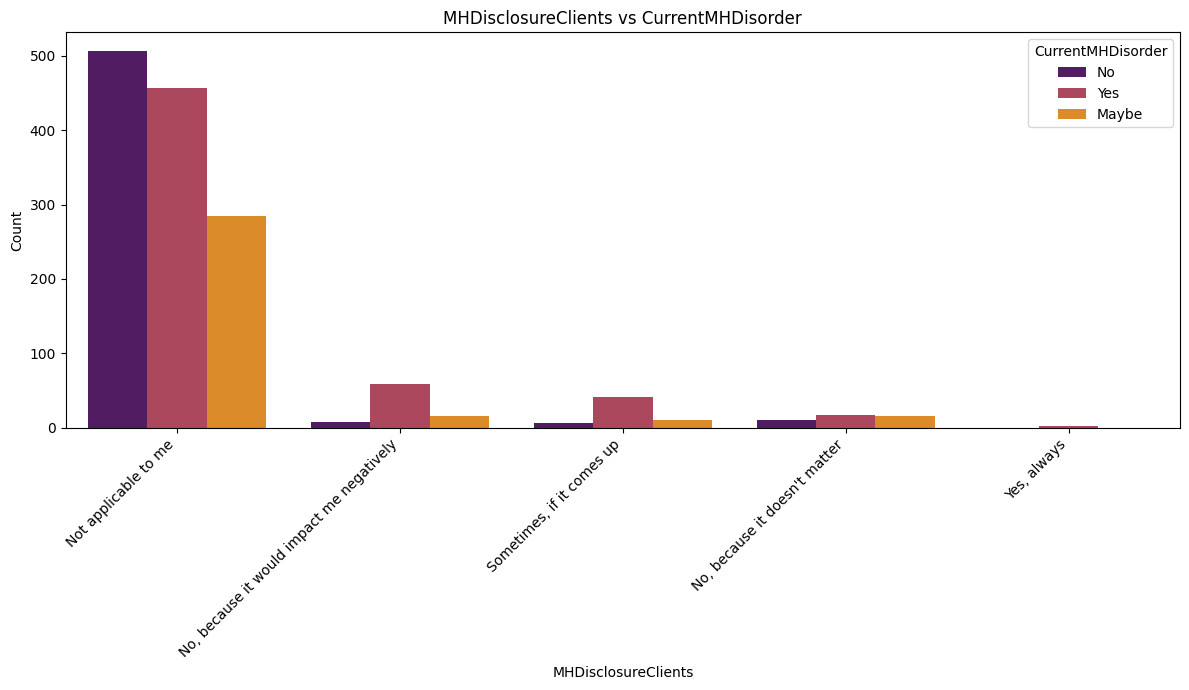

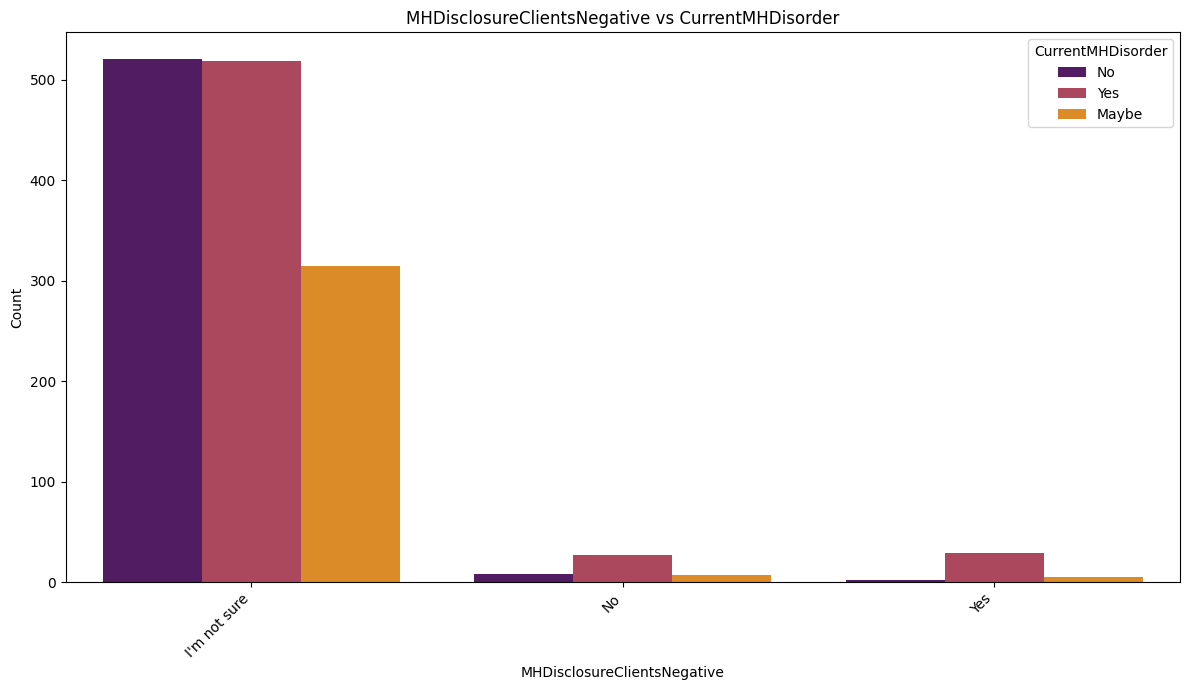

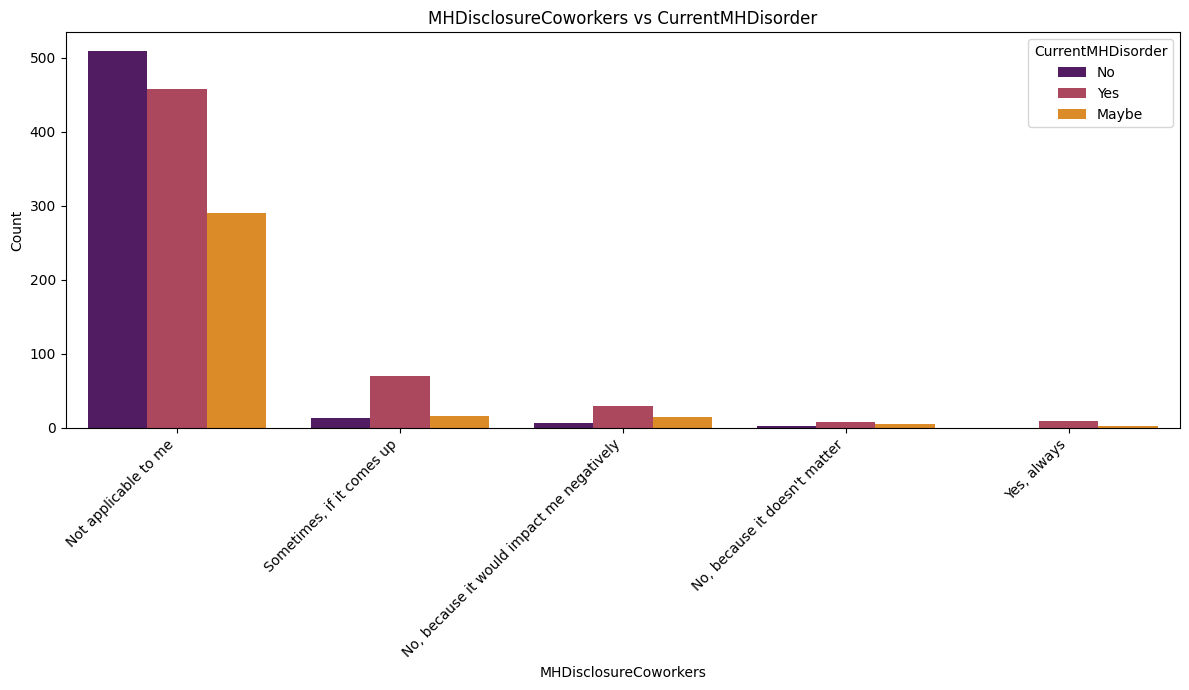

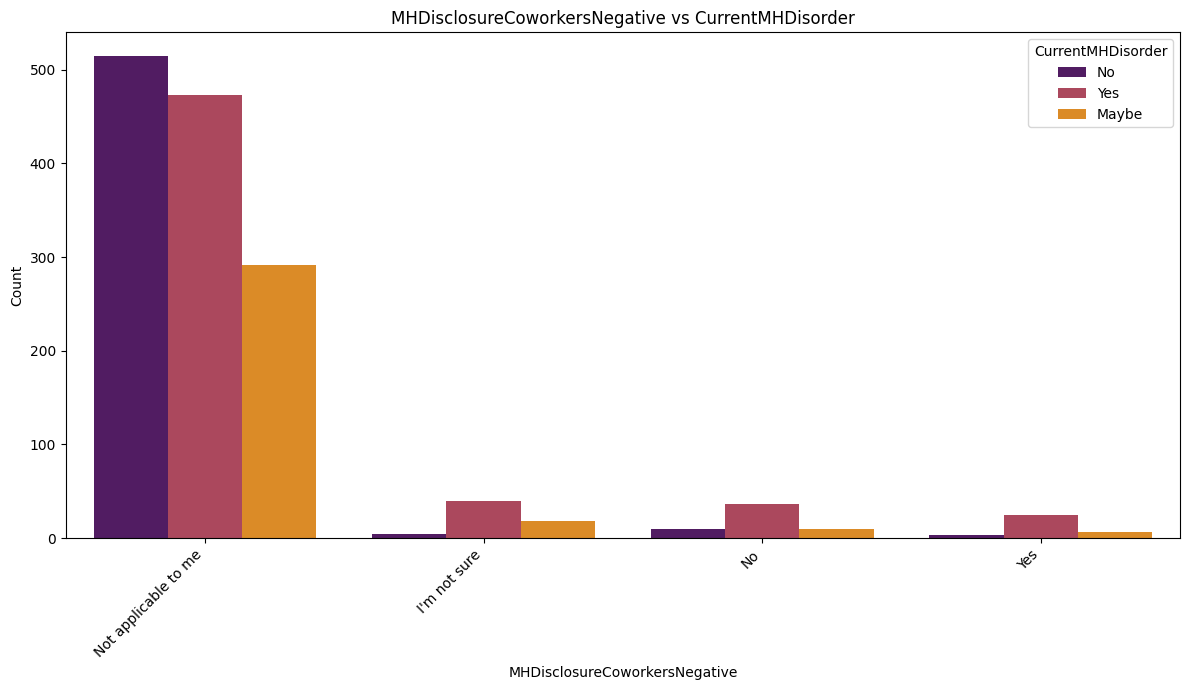

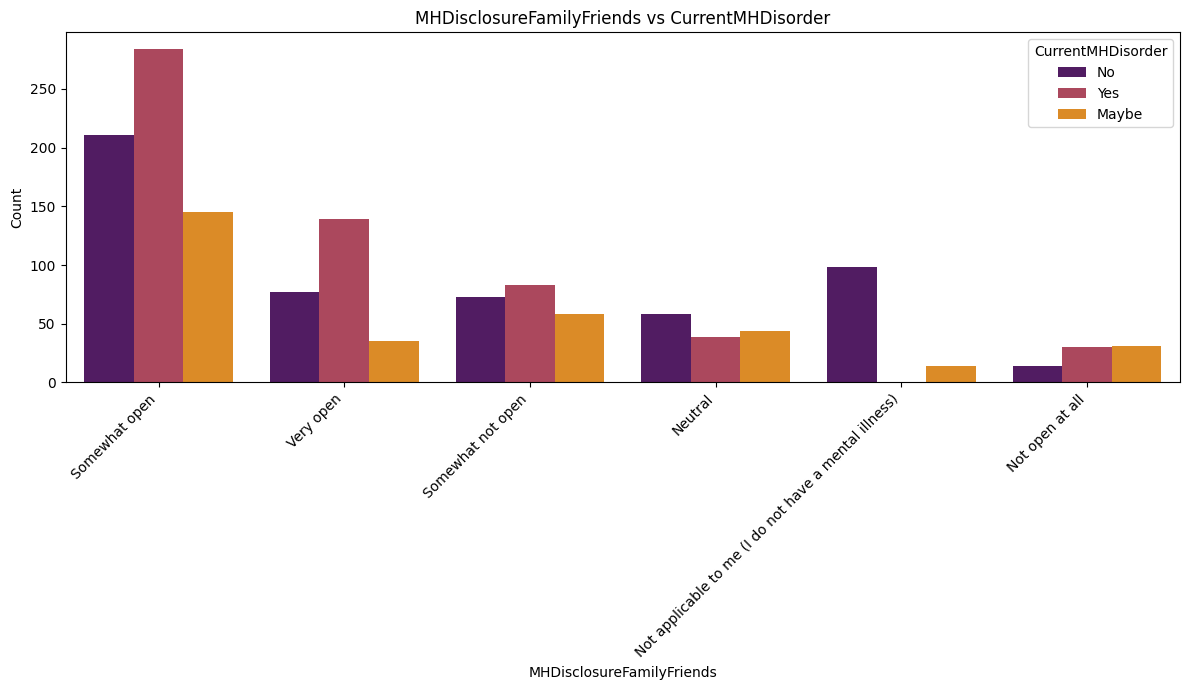

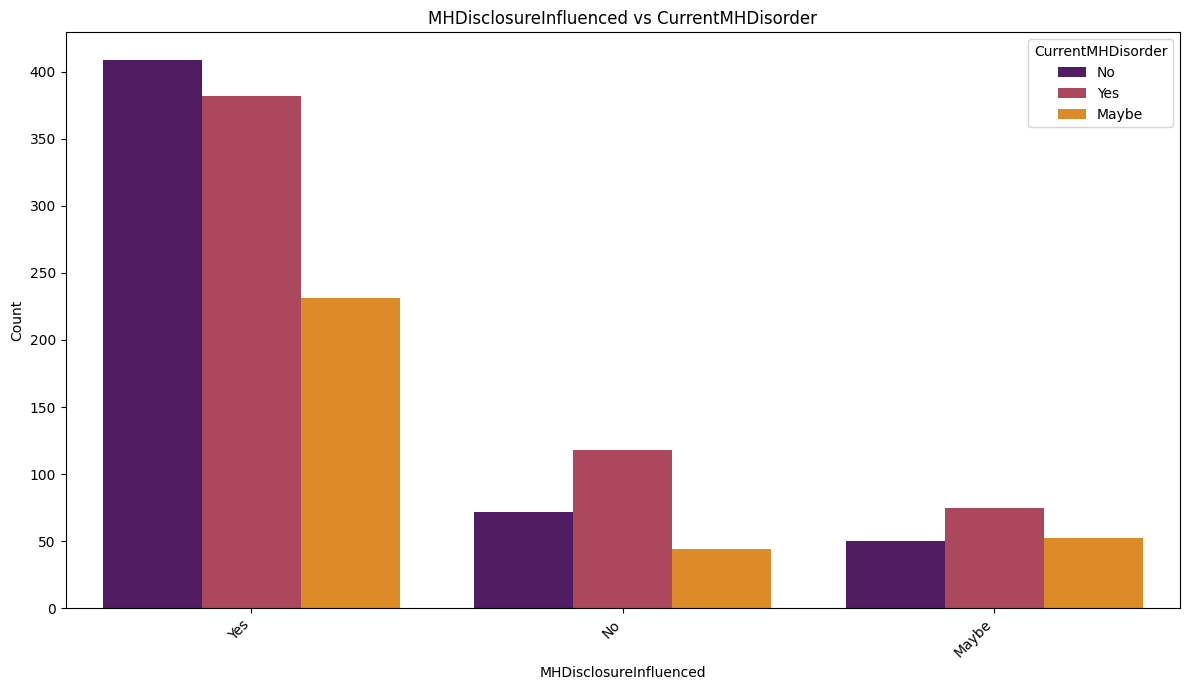

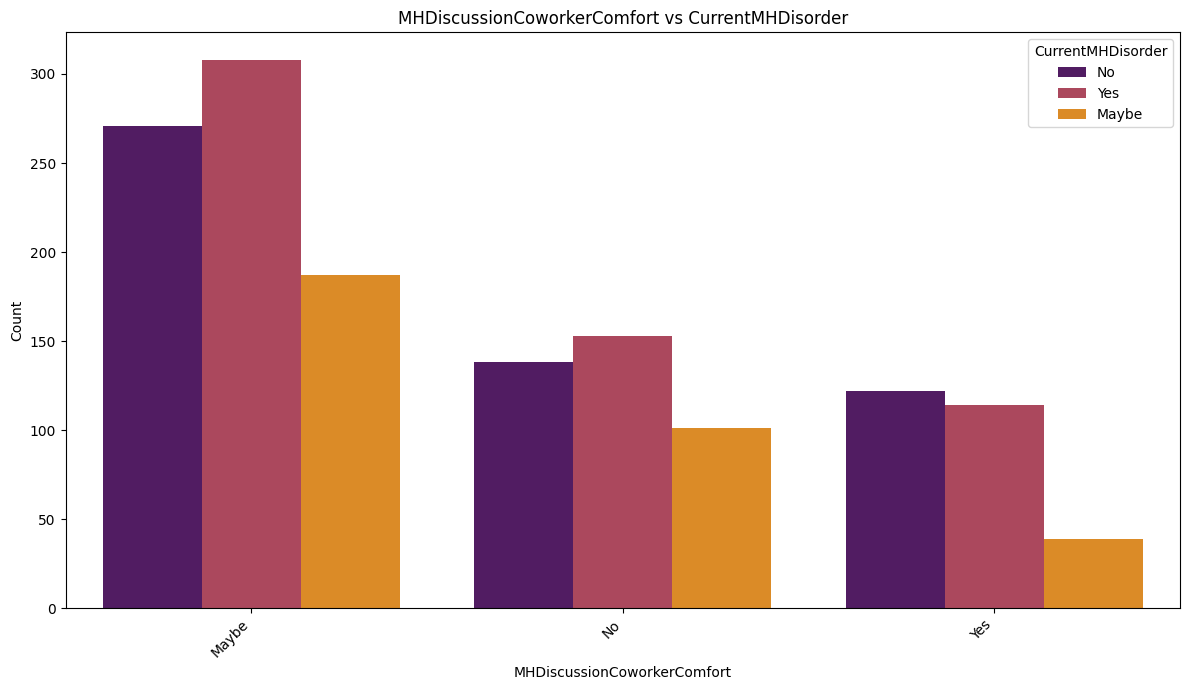

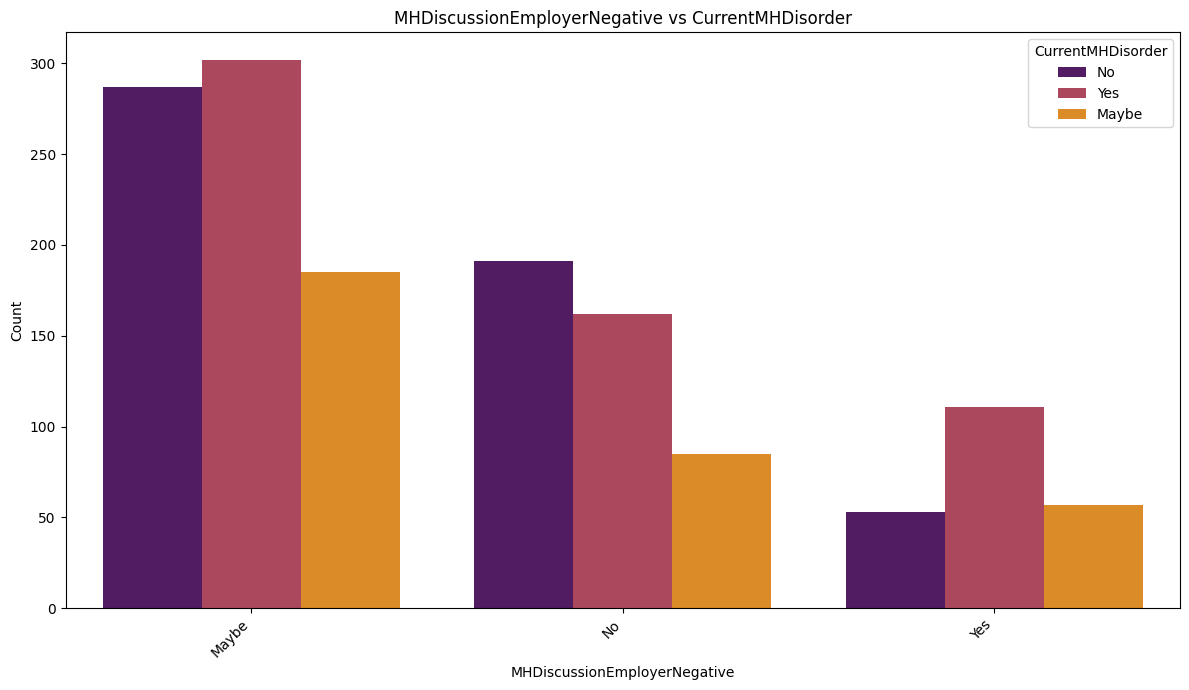

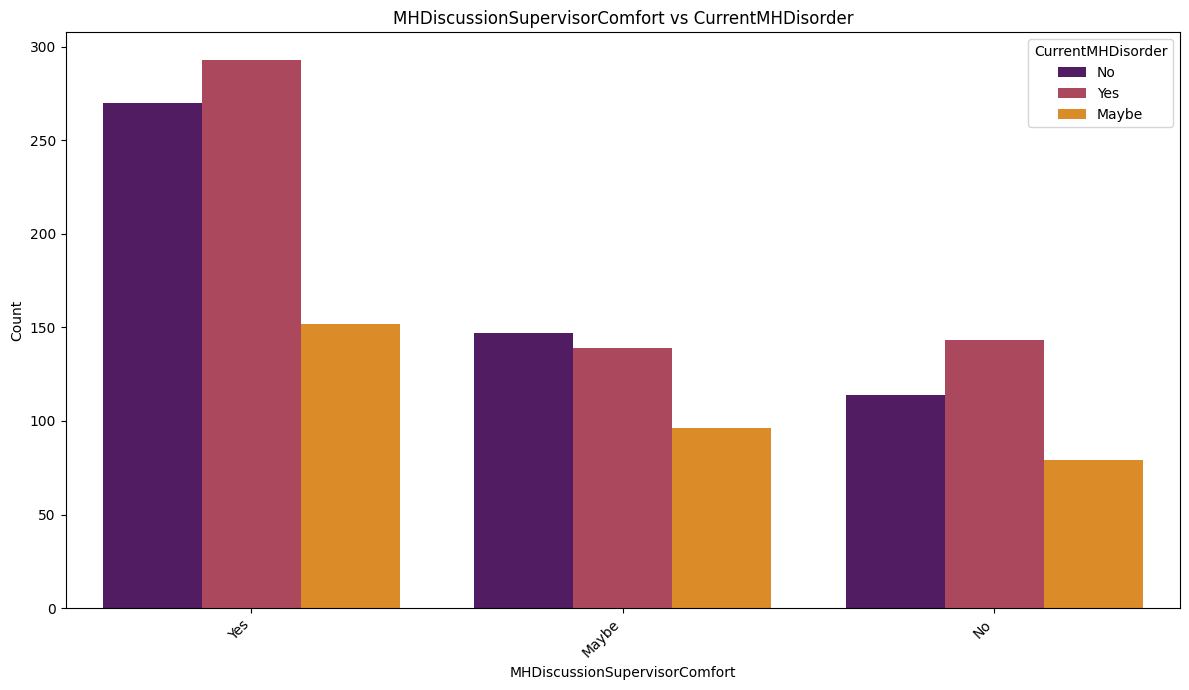

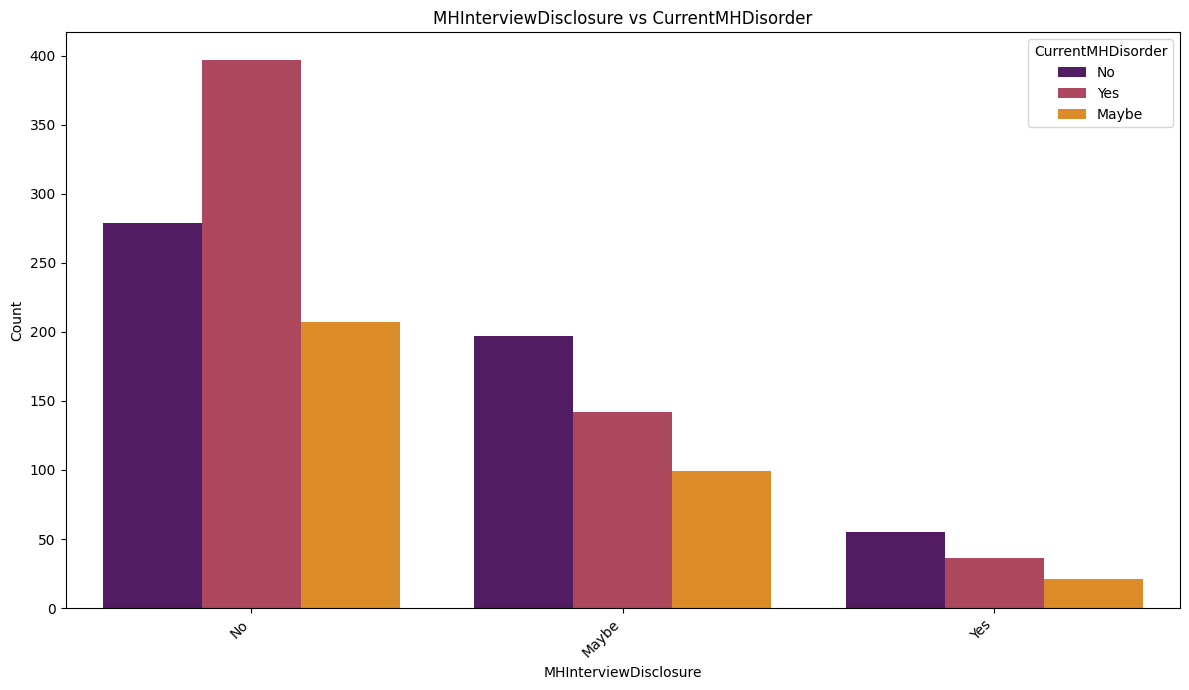

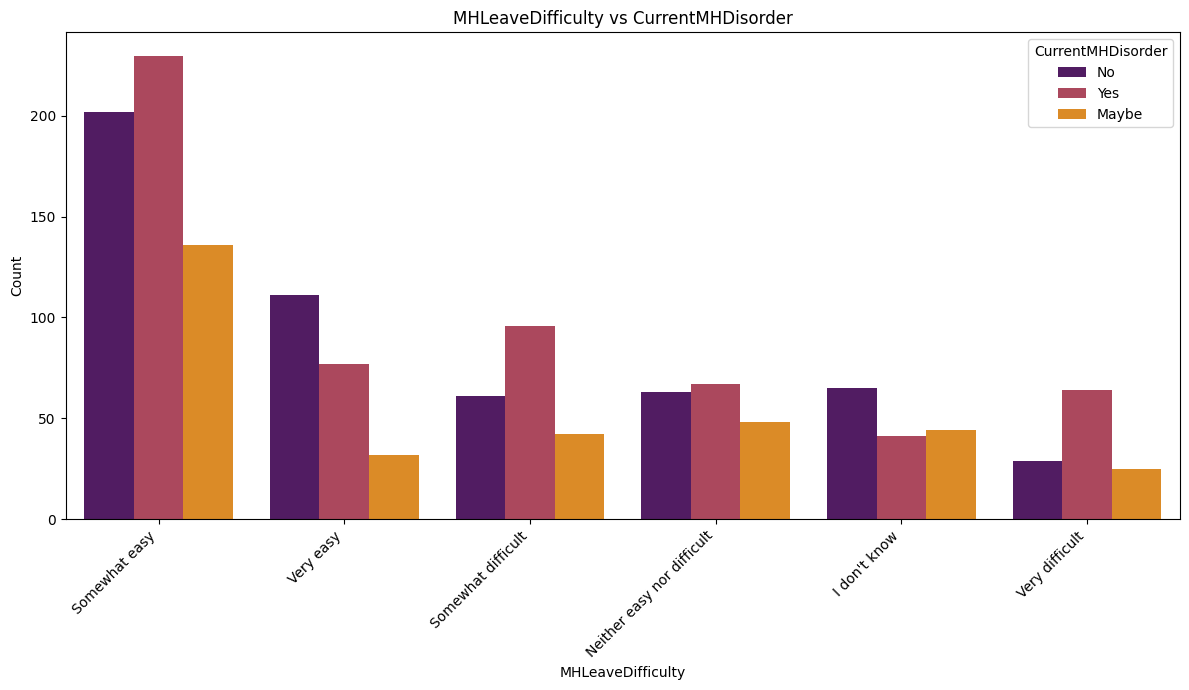

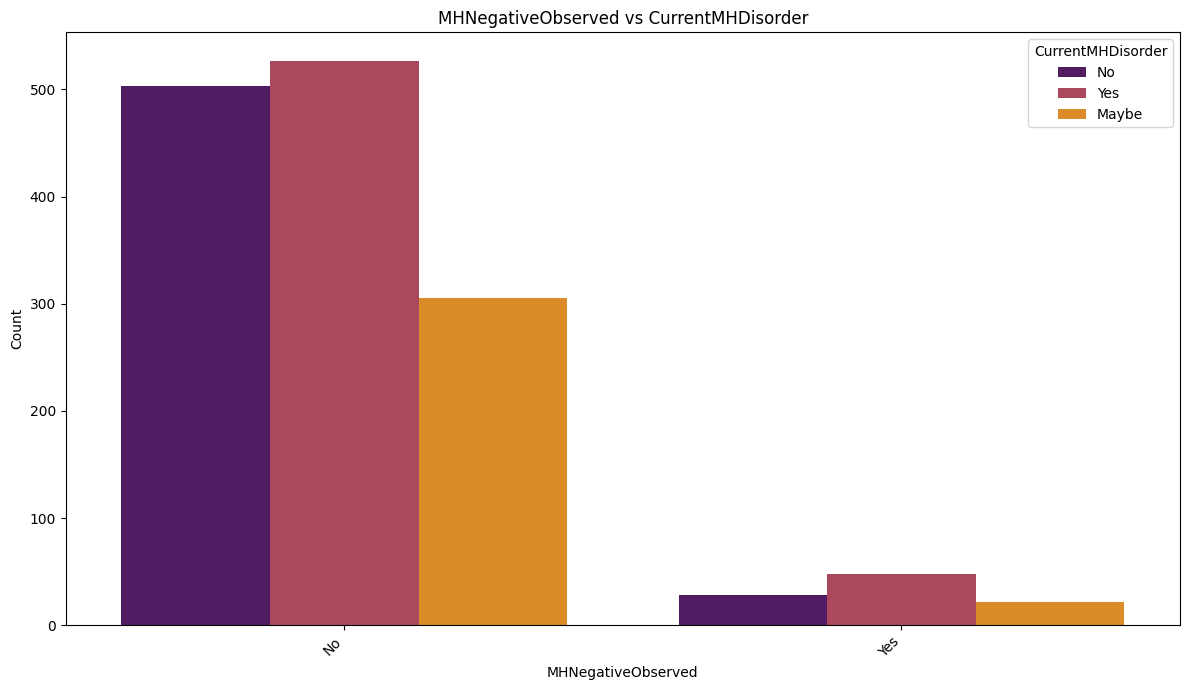

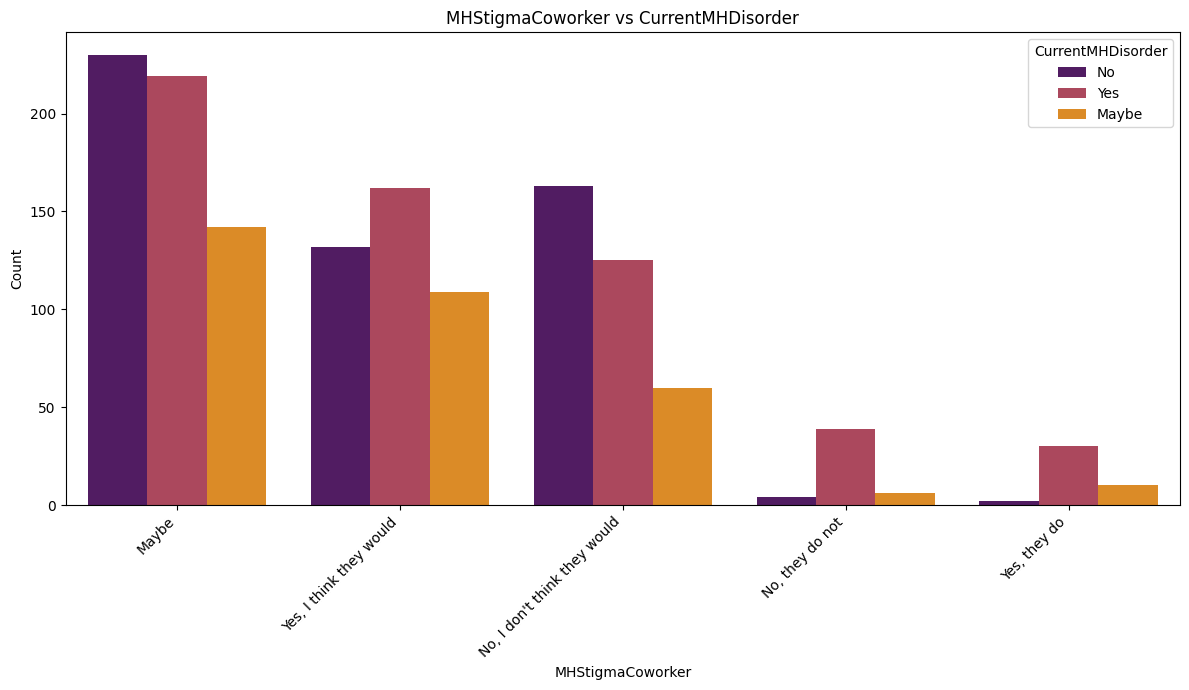

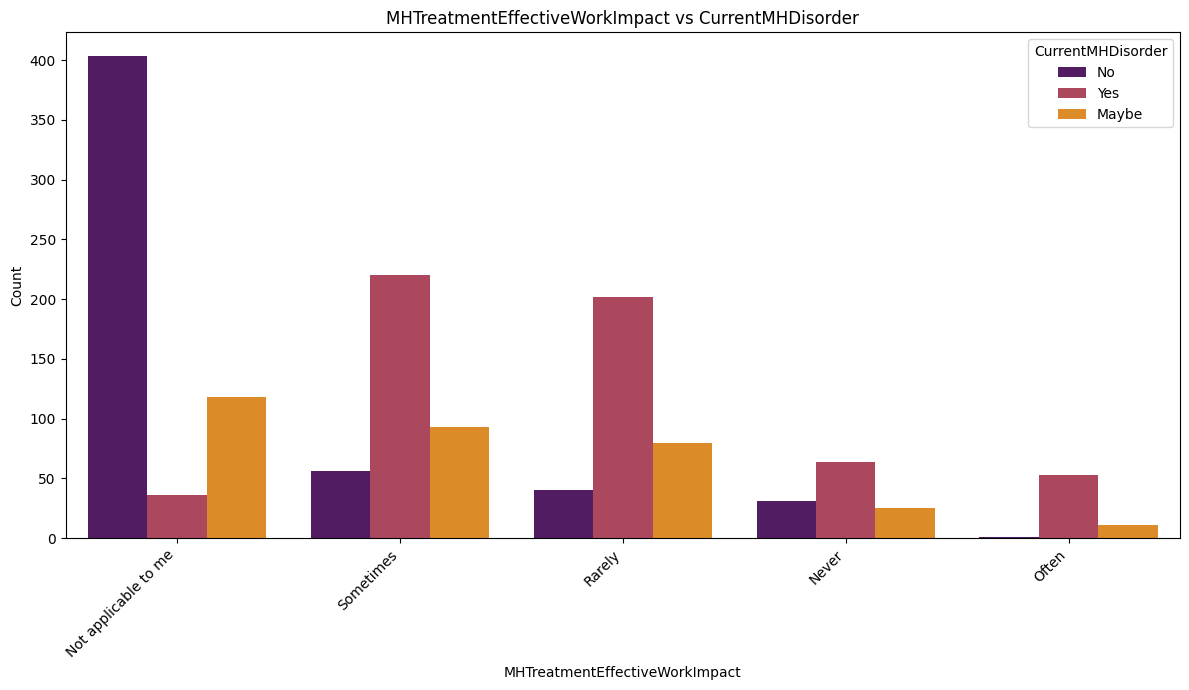

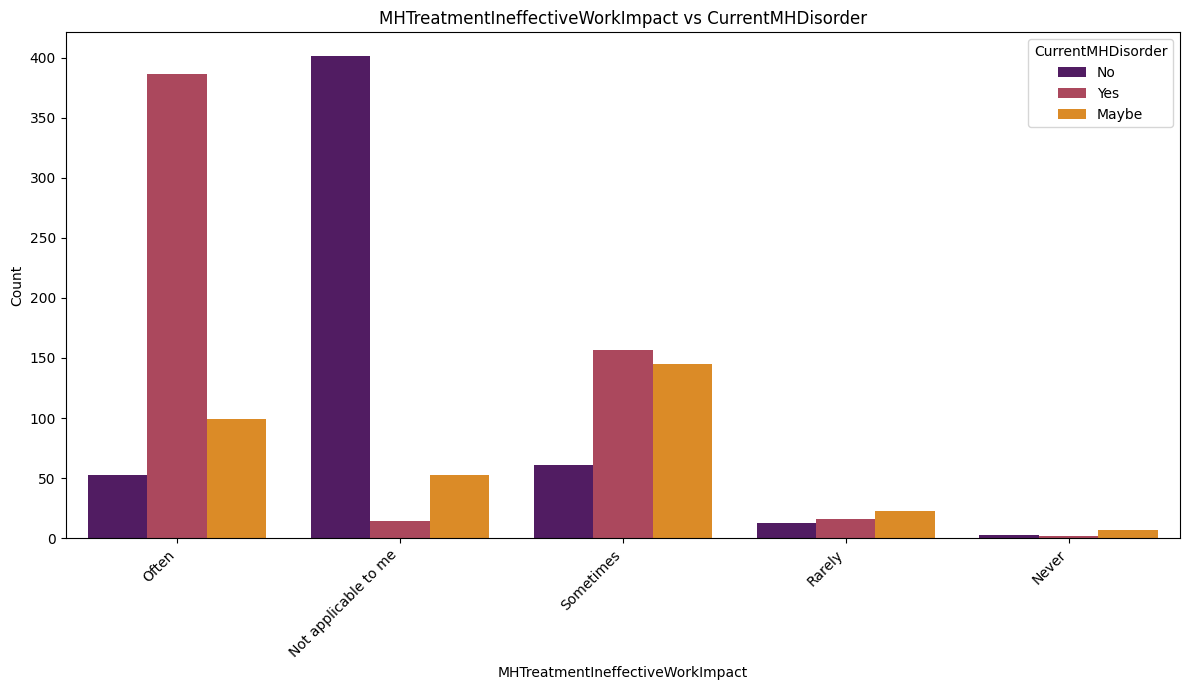

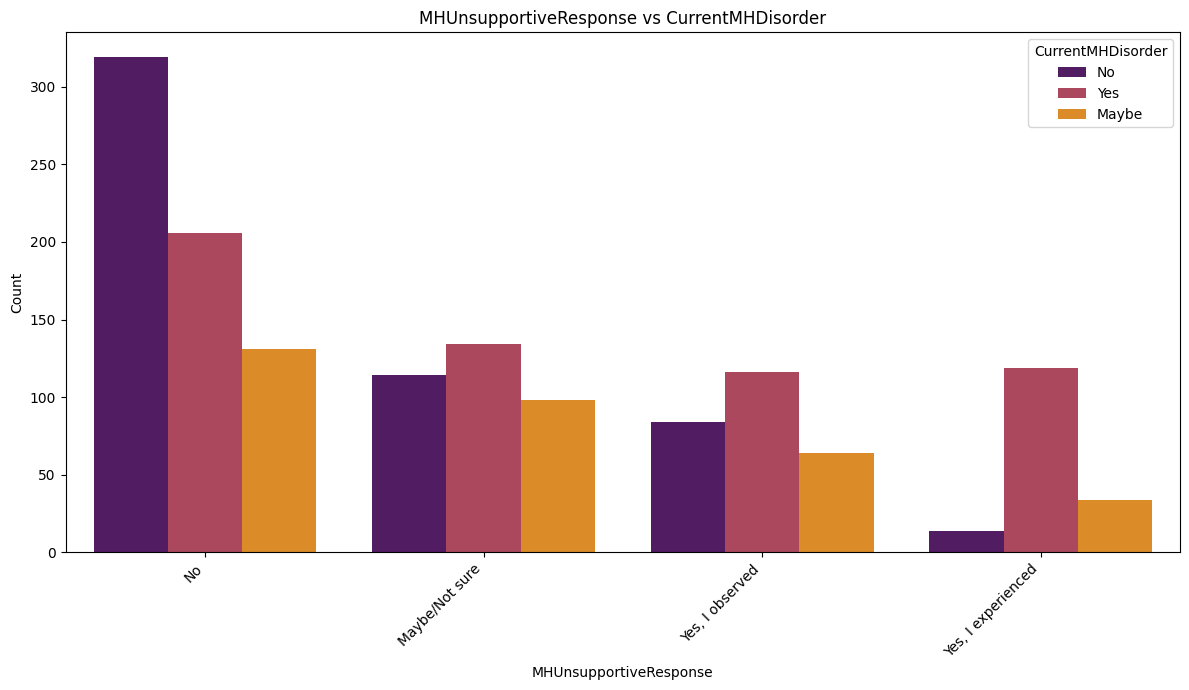

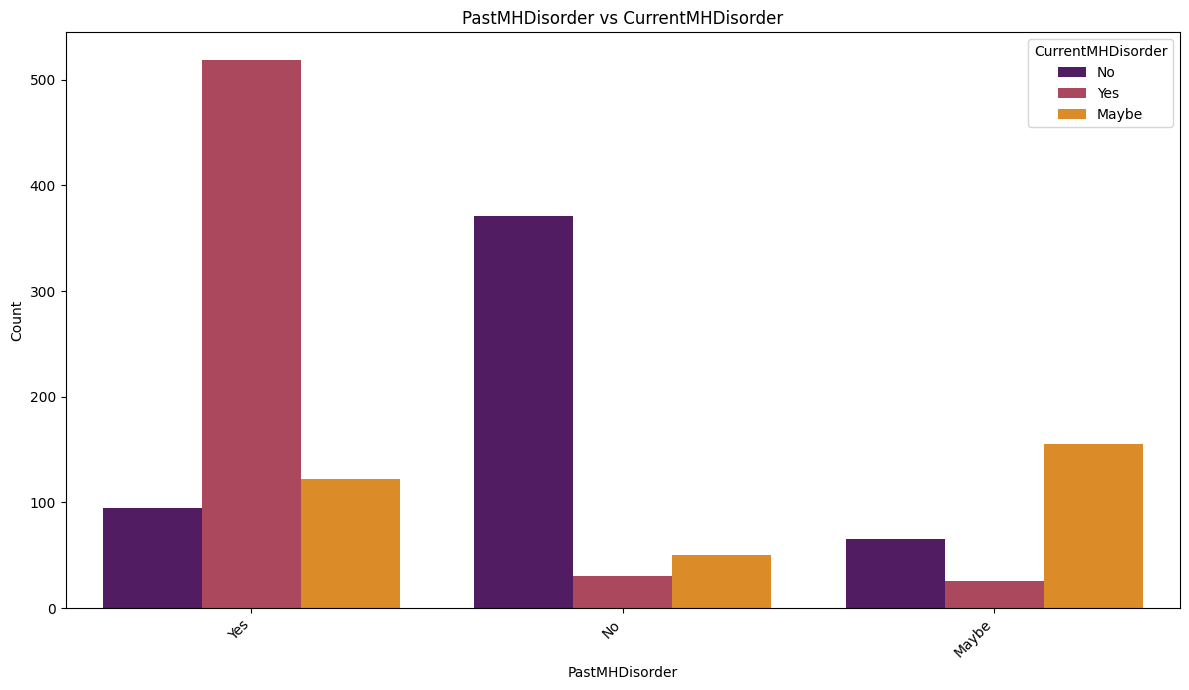

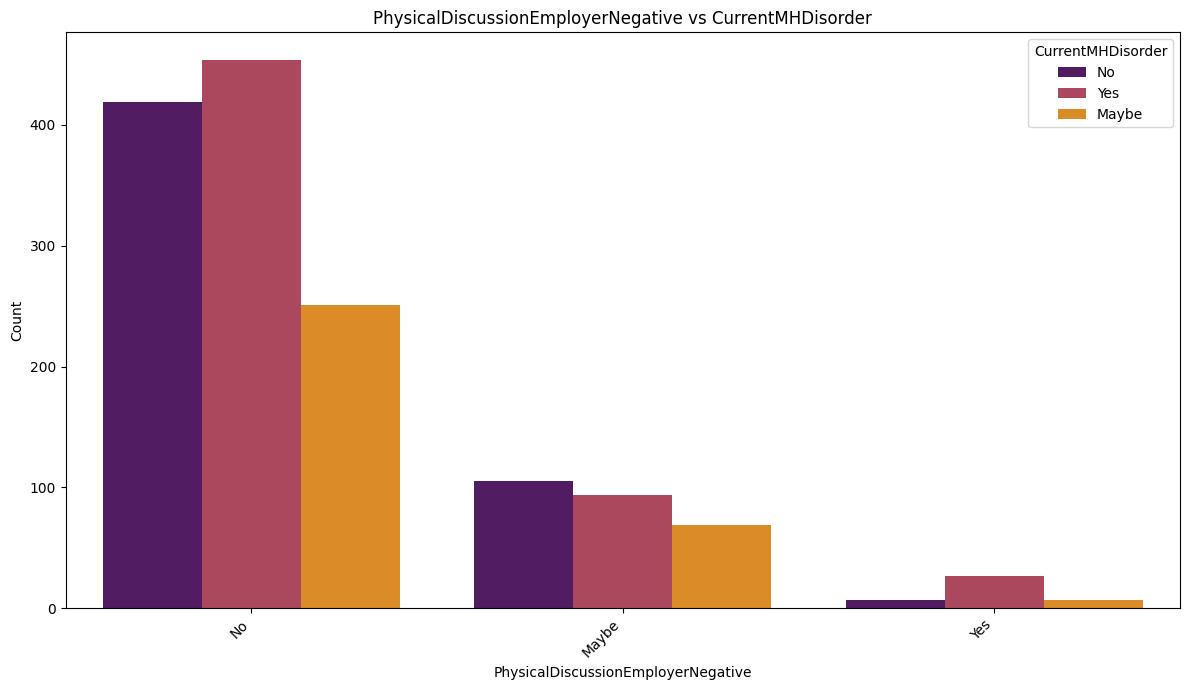

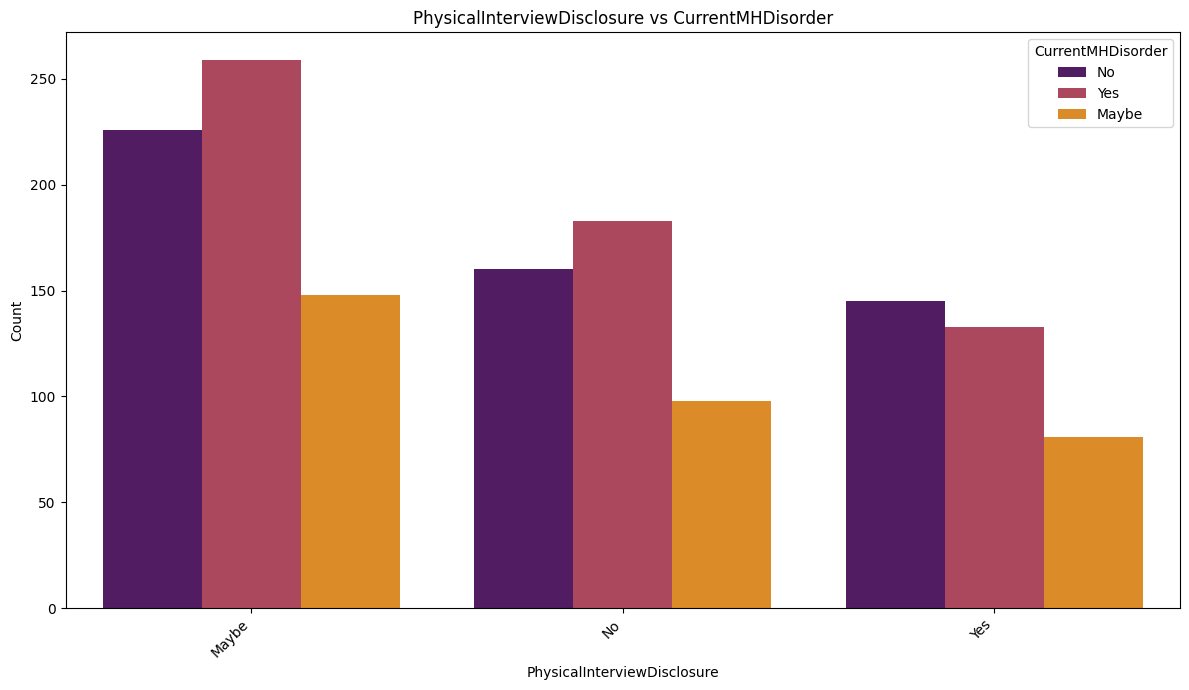

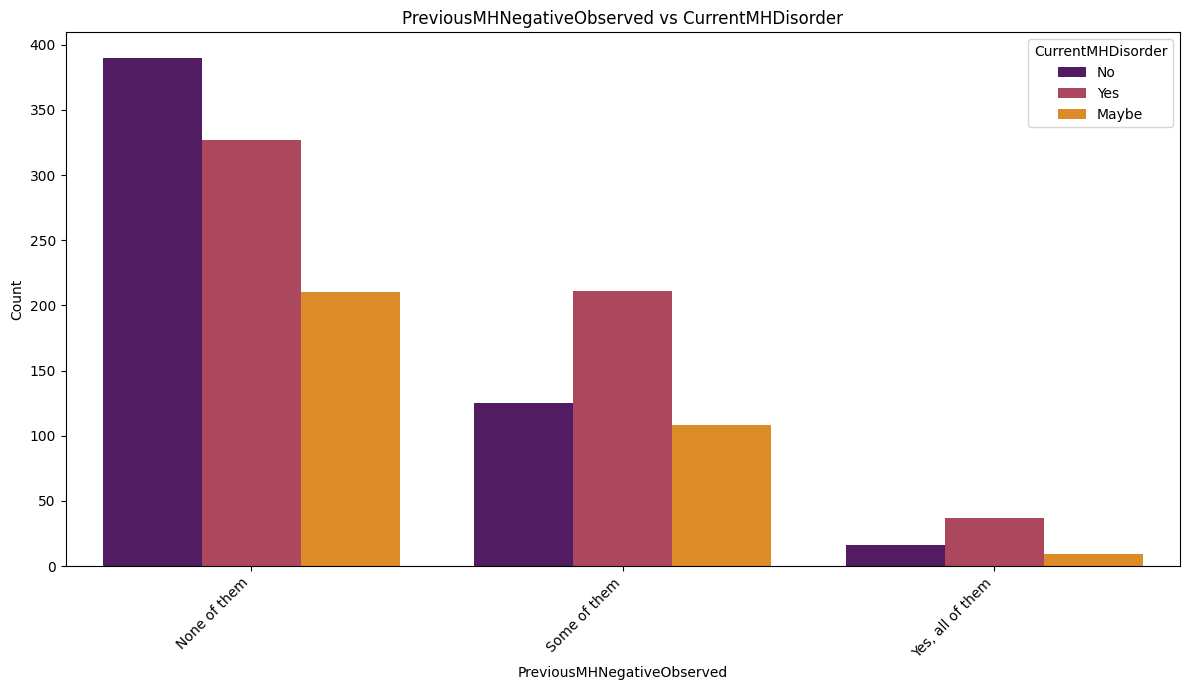

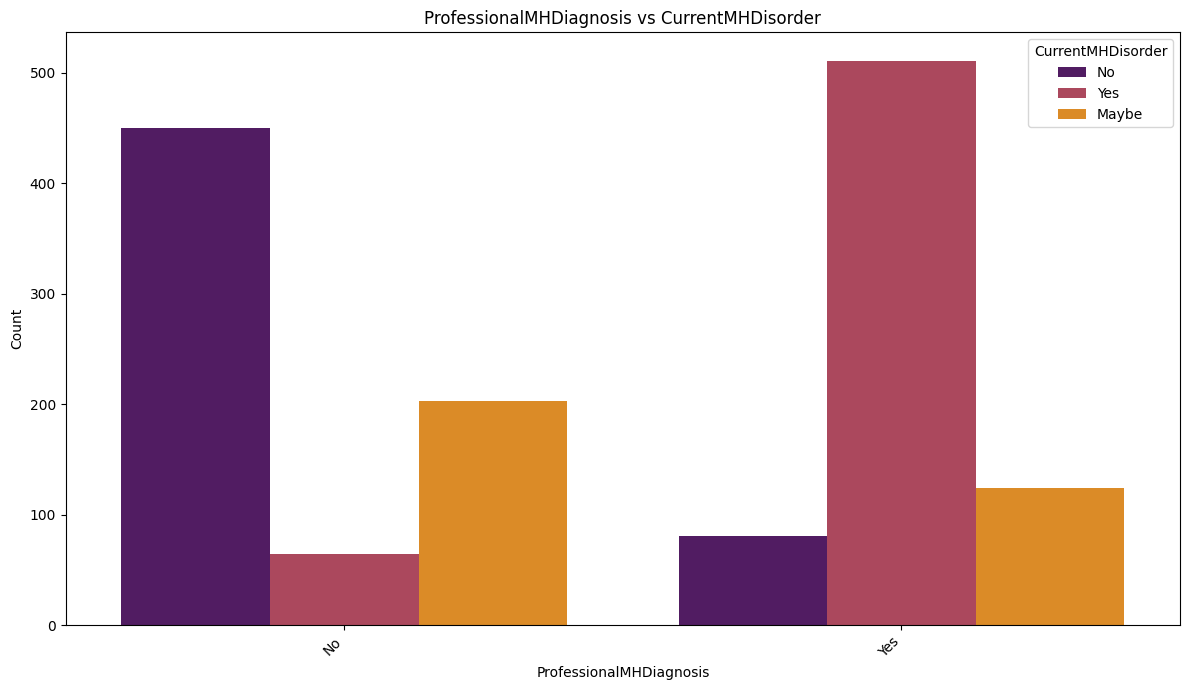

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


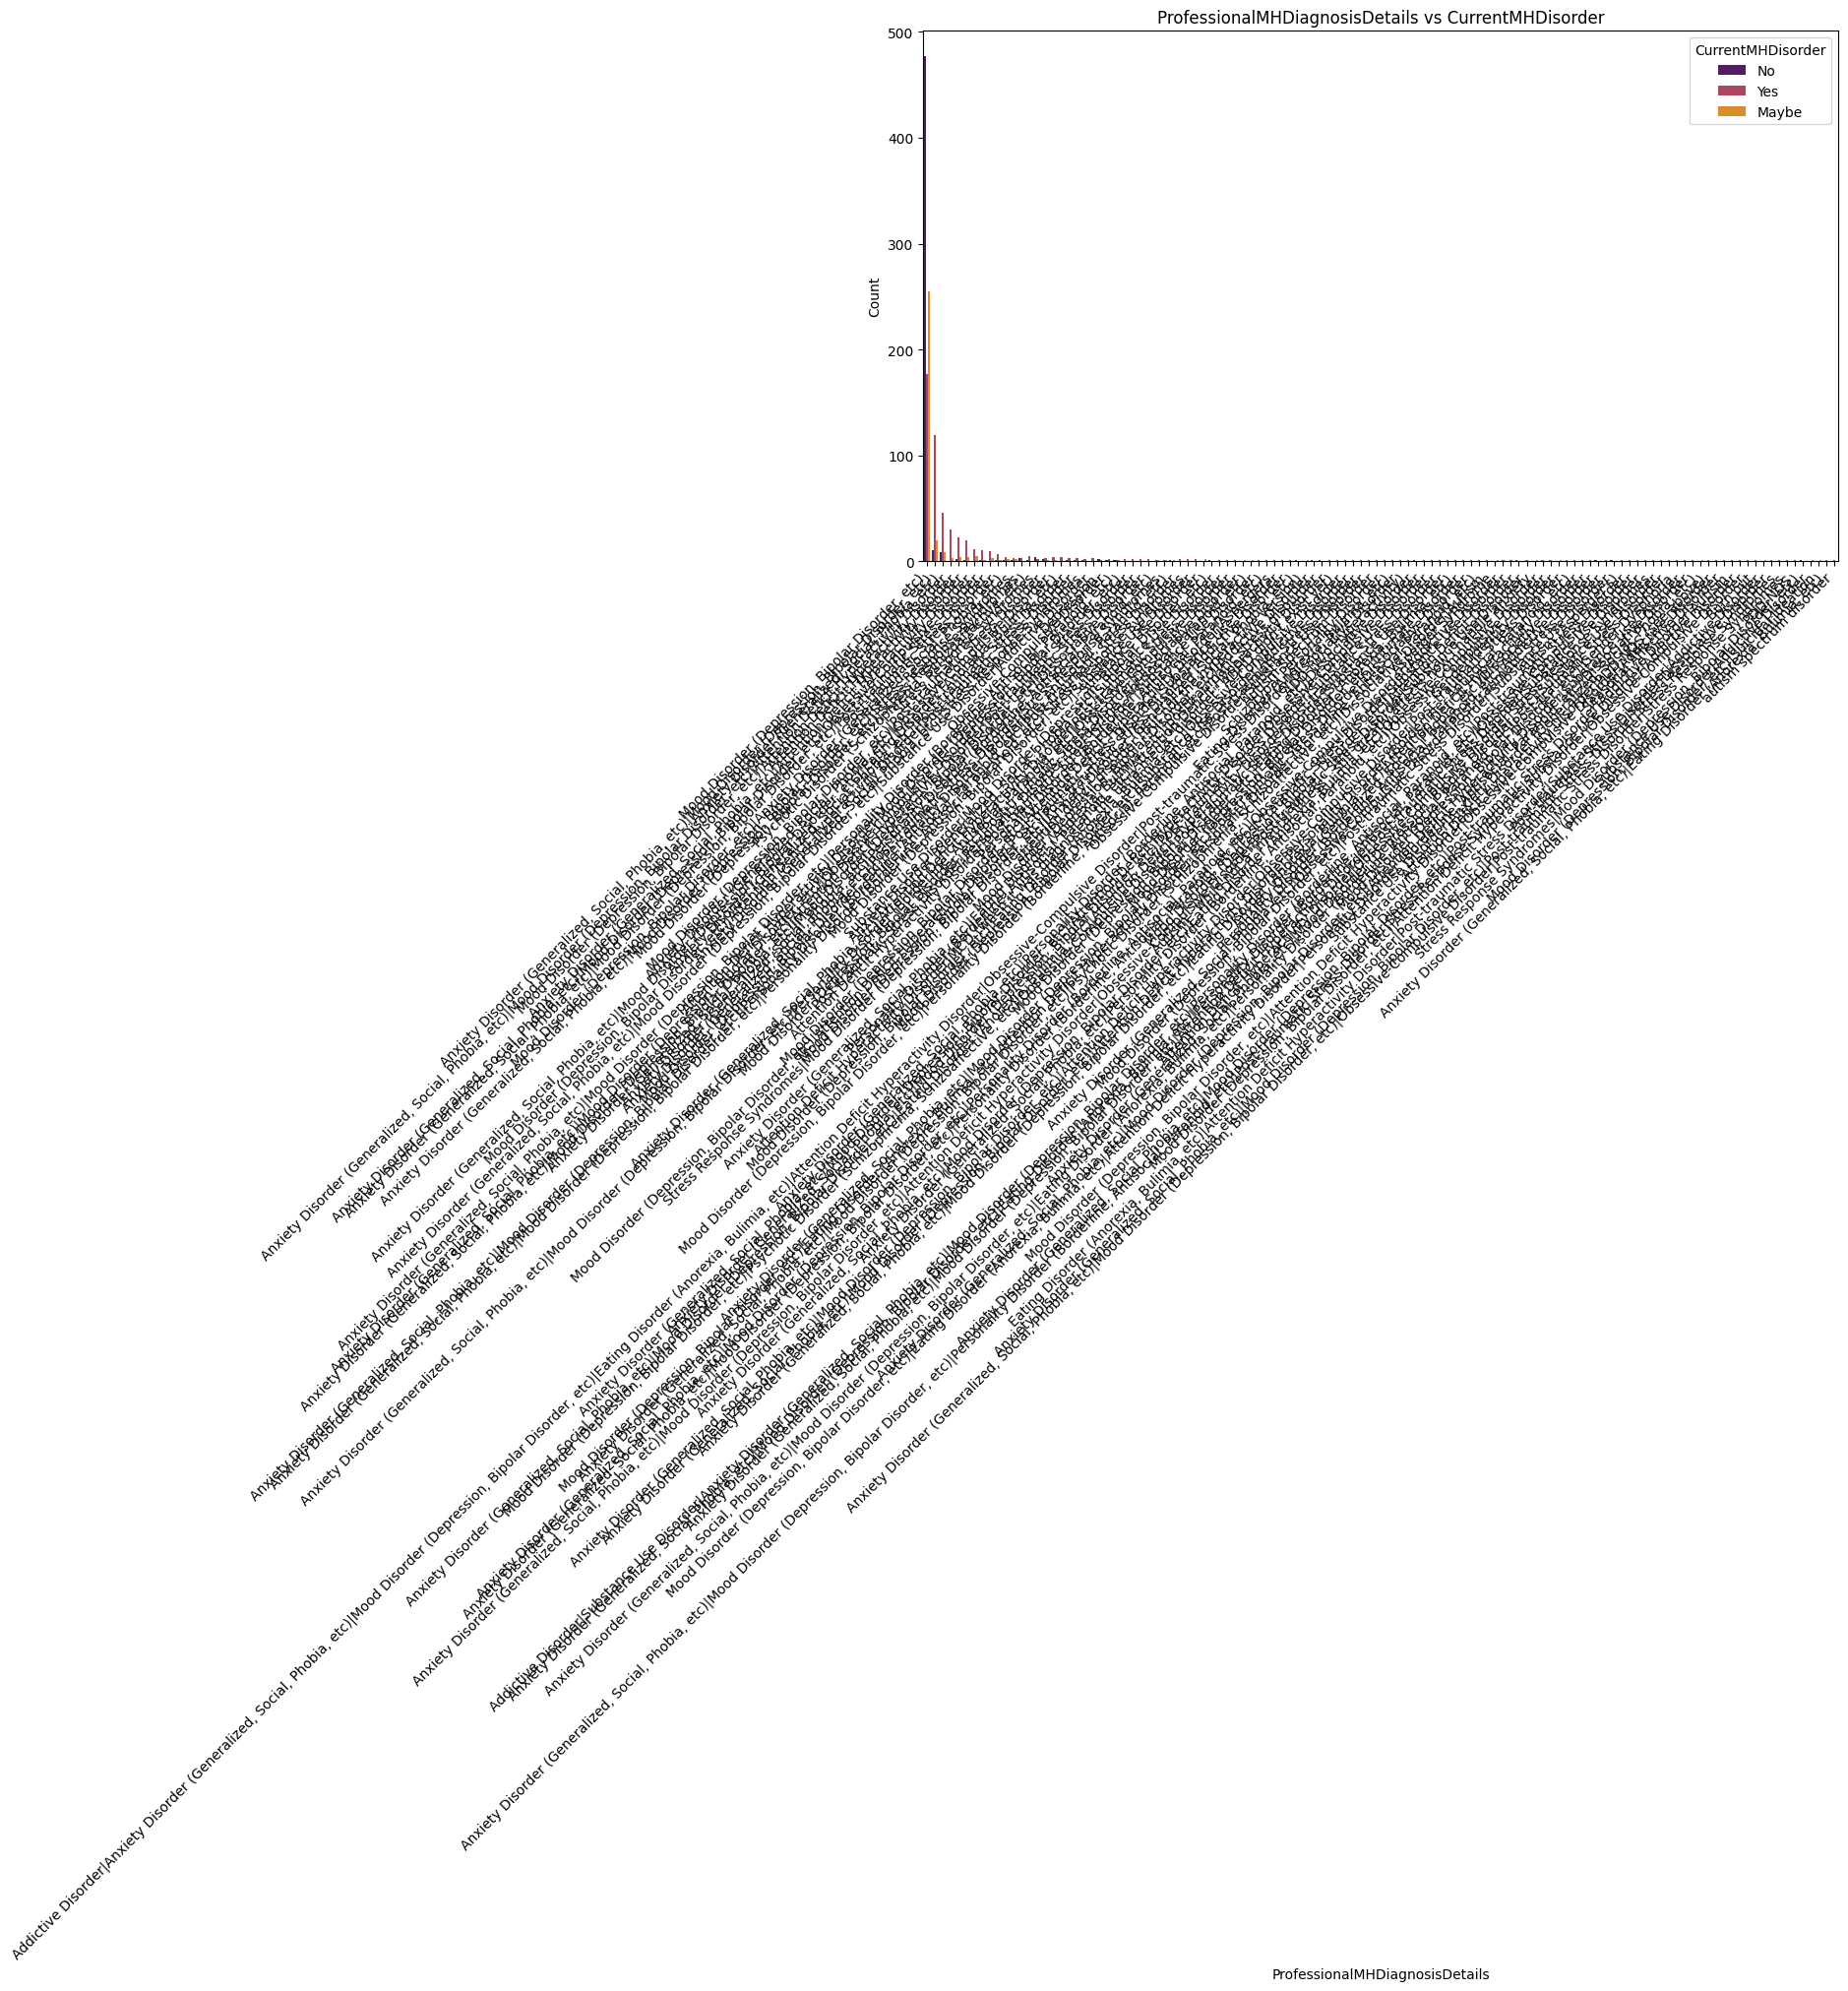

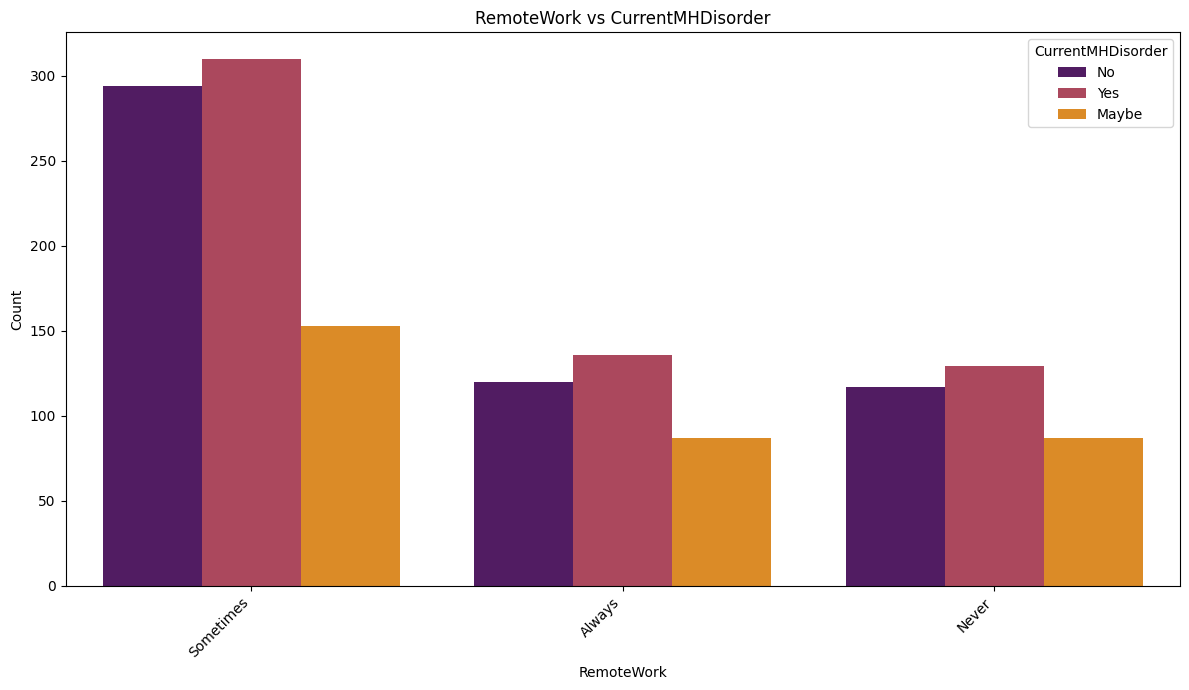

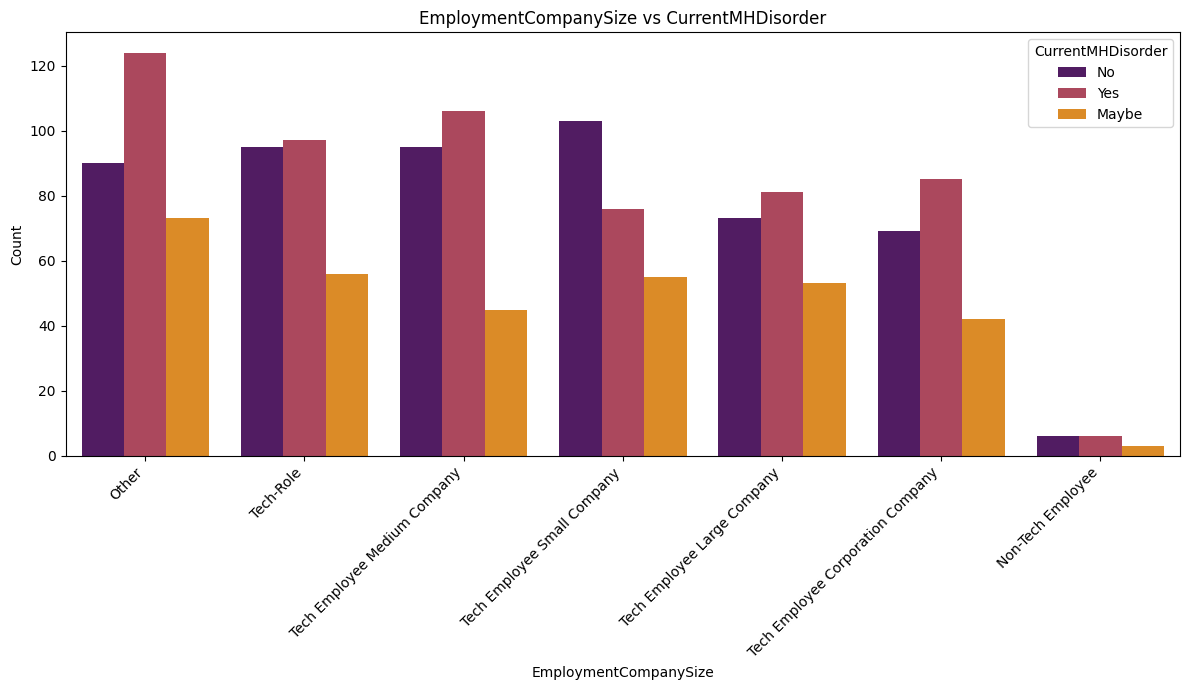

In [24]:
  # Get categorical columns
categorical_vs_target(df_cleaned,  categorical_cols=categorical_cols,target_variable_name="CurrentMHDisorder",)


c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable_name, y=col, data=df, palette='Set3')


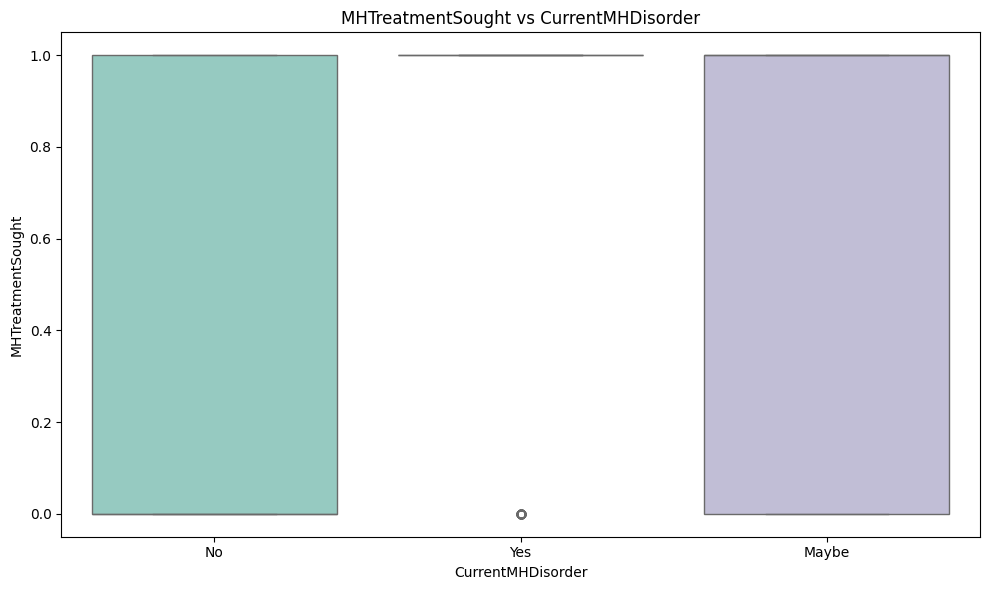

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable_name, y=col, data=df, palette='Set3')


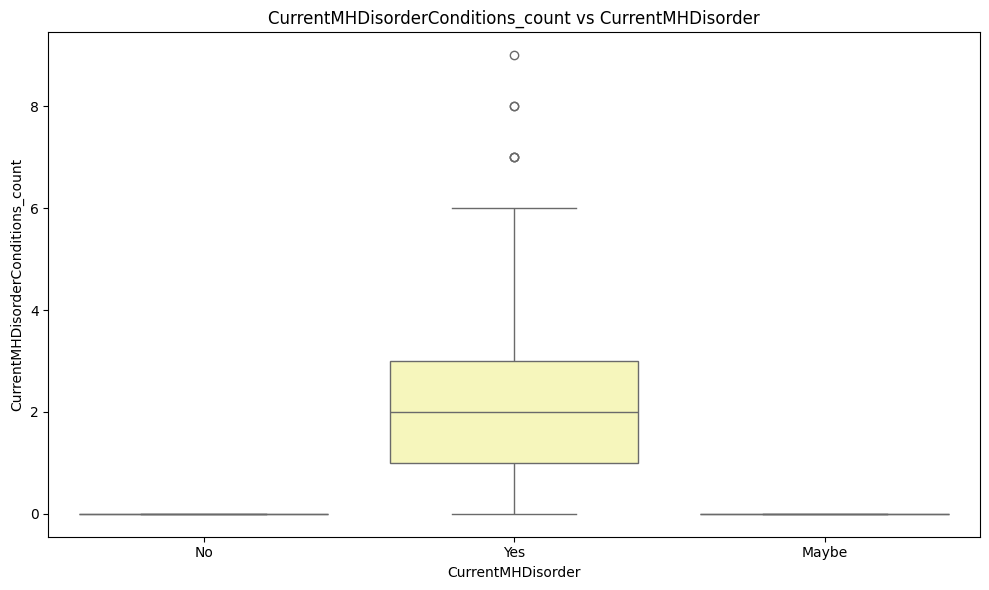

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable_name, y=col, data=df, palette='Set3')


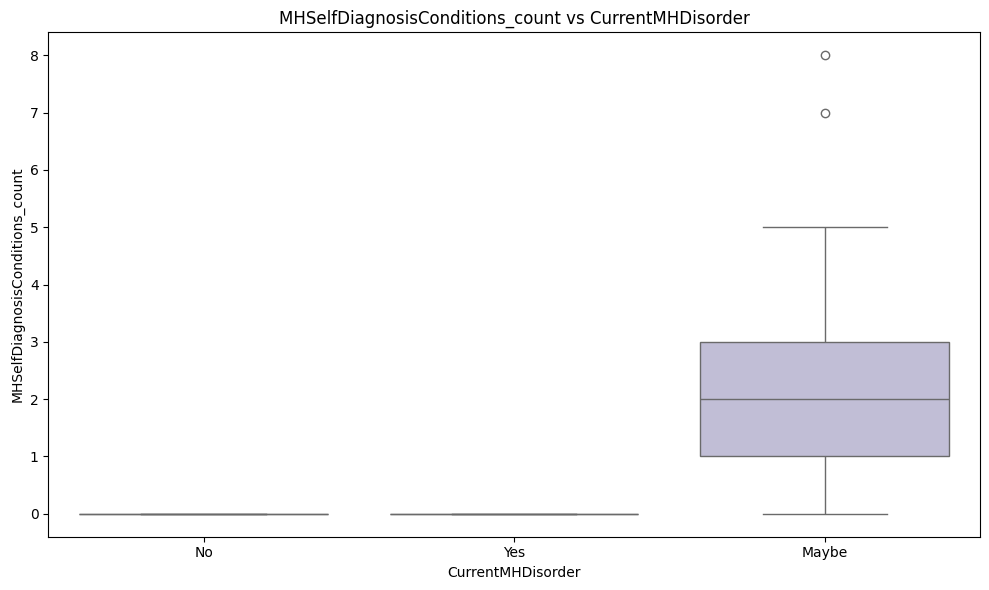

c:\Users\aswad\Desktop\NLP\Project\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\Predicting-and-Explaining-Mental-Health-of-Tech-Employees-using-SHAP\notebooks\..\src\visualizations.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable_name, y=col, data=df, palette='Set3')


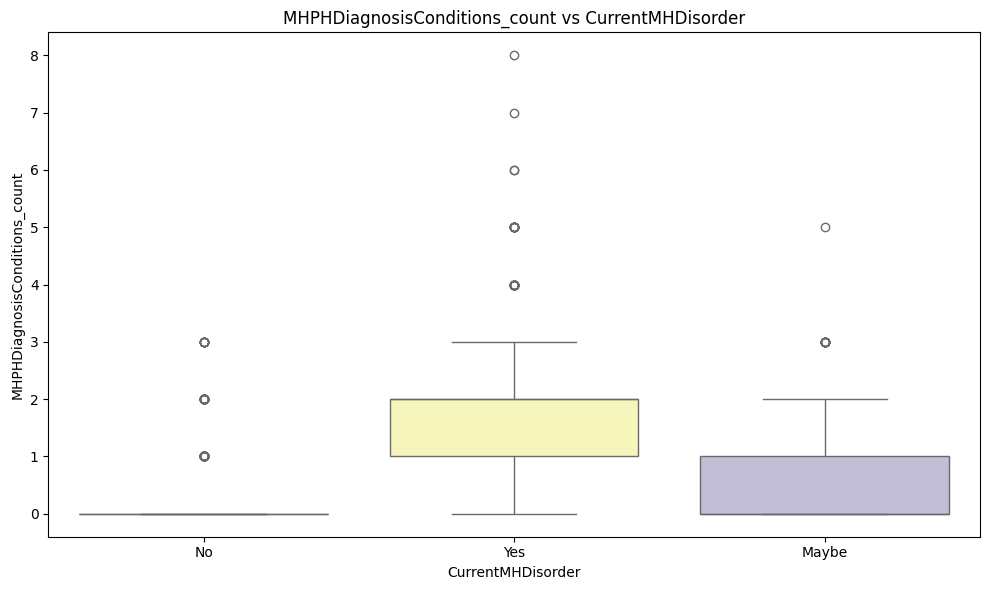

In [25]:
numerical_vs_target(df_cleaned, target_variable_name="CurrentMHDisorder")


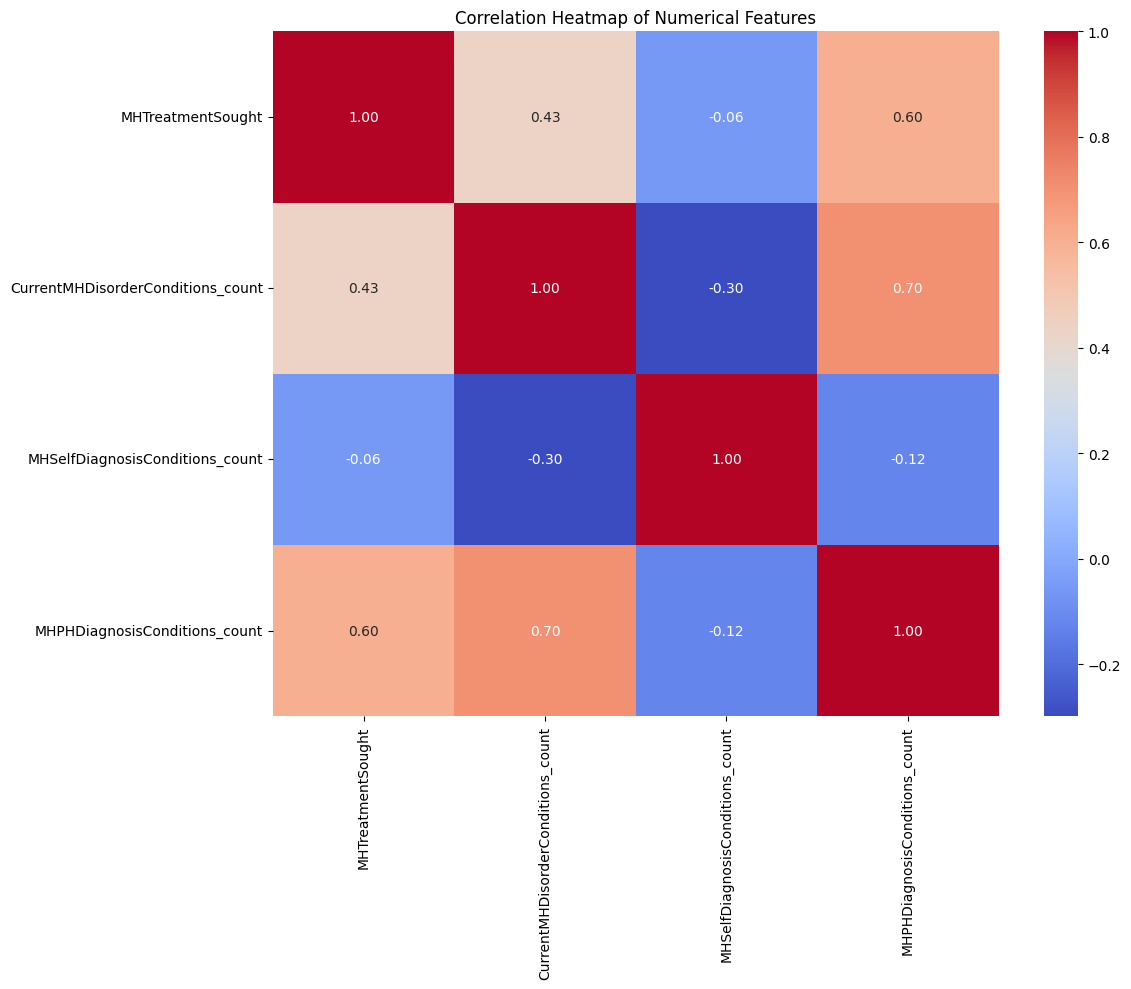

In [26]:
plot_correlation_heatmap(df_cleaned)

In [27]:
len(df_cleaned.columns.to_list())

43

In [87]:
df_cleaned.columns.to_list()

['Age_group',
 'CurrentMHDisorder',
 'FamilyMHHistory',
 'Gender',
 'MHBenefitsAwareness',
 'MHStigmaCoworker',
 'MHTreatmentEffectiveWorkImpact',
 'MHTreatmentIneffectiveWorkImpact',
 'MHTreatmentSought',
 'MHUnsupportiveResponse',
 'PastMHDisorder',
 'PhysicalDiscussionEmployerNegative',
 'PhysicalInterviewDisclosure',
 'PreviousMHNegativeObserved',
 'ProfessionalMHDiagnosis',
 'CurrentMHDisorderConditions_count',
 'MHSelfDiagnosisConditions_count',
 'MHPHDiagnosisConditions_count',
 'EmploymentCompanySize']

In [88]:
# Dropping Unnecessary Columns
drop_cols = [
    # 'ProfessionalMHDiagnosisDetails',
#                 'RemoteWork',
#                 'StateLive',
#                 'StateWork',
#                 'CountryLive',
#                 'CountryWork','MHBenefitsAwareness',
#  'MHCareerImpact',
#  'MHDisclosureClients',
#  'MHDisclosureClientsNegative',
#  'MHDisclosureCoworkers',
#  'MHDisclosureCoworkersNegative',
#  'MHDisclosureFamilyFriends',
#  'MHDisclosureInfluenced',
#  'MHDiscussionCoworkerComfort',
#  'MHDiscussionEmployerNegative',
#  'MHDiscussionSupervisorComfort',
#  'MHInterviewDisclosure',
#  'MHLeaveDifficulty',
#  'MHNegativeObserved',
 
#   'EmployerMHAnonymity',
#  'EmployerMHBenefits',
#  'EmployerMHDiscussion',
#  'EmployerMHResources',
#  'EmployerMHVsPhysical',
 'CurrentMHDisorderConditions_count',
 'MHSelfDiagnosisConditions_count',
 'MHPHDiagnosisConditions_count',
 'EmploymentCompanySize'
 ]
df_cleaned = df_cleaned.drop(columns=drop_cols)
print("Unnecessary columns dropped.")

Unnecessary columns dropped.


In [89]:
len(df_cleaned.columns.to_list())

15

In [90]:
print("\n--- Exploratory Data Analysis Completed ---")


--- Exploratory Data Analysis Completed ---


In [91]:
# Target Variable Encoding
# --- Label Encoding ---
le = LabelEncoder()

target_variable = df_cleaned["CurrentMHDisorder"]
print(
    f"Target variable '{target_variable.name}' unique values: {target_variable.unique()}")
print(f"Data type of '{target_variable.name}': {target_variable.dtype}")

Target variable 'CurrentMHDisorder' unique values: ['No' 'Yes' 'Maybe']
Data type of 'CurrentMHDisorder': object


In [92]:
target_encoded = le.fit_transform(target_variable)
target_encoded_series = pd.Series(target_encoded, name='target_encoded')
print("Target variable encoded.")
print("Label Encoding Mapping:")
for original_label, encoded_value in zip(le.classes_, le.transform(le.classes_)):
    print(f"{original_label}: {encoded_value}")
    

Target variable encoded.
Label Encoding Mapping:
Maybe: 0
No: 1
Yes: 2


In [93]:
len(df_cleaned.columns.to_list())

15

In [94]:
# Encoding Categorical Features
categorical_df = df_cleaned.select_dtypes(exclude='number').drop(
    columns='CurrentMHDisorder',)
numerical_df = df_cleaned.select_dtypes(exclude=['object', 'category'])

encoded_categorical = encode_categorical_columns(categorical_df=categorical_df)
print("Categorical features encoded.")

Categorical features encoded.


In [95]:
# --- Data Concatination  ---
print("\n--- Data Splitting and Scaling ---")
X = pd.concat((encoded_categorical, numerical_df), axis=1)
y = target_encoded


--- Data Splitting and Scaling ---


In [96]:
# # --- Data Scaling   ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [97]:
# --- Data Splitting  ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Dev size: {len(X_dev)}")
print(f"Test size: {len(X_test)}")

Train size: 1074
Dev size: 179
Test size: 180


In [98]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


def gets_models():
    tuned_models = {

        "Logistic Regression (Tuned)": {
            "model": LogisticRegression(max_iter=1000, solver='saga', random_state=42),
            "params": {
                'C': [0.01, 0.1, 1.0, 10.0],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }
        },
        "Random Forest (Tuned)": {
            "model": RandomForestClassifier(random_state=42),
            "params": {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20],
                'max_features': ['sqrt', 'log2'],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },


        "Decision Tree Classifier (Tuned)": {
            "model": DecisionTreeClassifier(random_state=42),
            "params": {
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'criterion': ['gini', 'entropy']
            }
        },
        "Gradient Boosting Classifier (Tuned)": {
            "model": GradientBoostingClassifier(random_state=42),
            "params": {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 4, 5, 7],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }

        },
        "AdaBoost Classifier (Tuned)": {
            "model": AdaBoostClassifier(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 1.0]
            }
        }, "XGBoost (Tuned)": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
            "params": {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.3]
            }
        },

    }

    non_tuned_models = {
        "Logistic Regression (Baseline)": {
            "model": LogisticRegression(),
            "params": {}
        },
        "Random Forest Classifier (Baseline)": {
            "model": RandomForestClassifier(n_estimators=60, random_state=42),
            "params": {}
        },
        "Decision Tree Classifier": {
            "model": DecisionTreeClassifier(random_state=42),
            "params": {}
        },

        "Gradient Boosting Classifier": {
            "model": GradientBoostingClassifier(random_state=42),
            "params": {}
        },
        "AdaBoost Classifier": {
            "model": AdaBoostClassifier(),
            "params": {}
        },
        "XGBoost Classifier": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
            "params": {}
        }
    }

    return tuned_models, non_tuned_models

In [99]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from collections import defaultdict

def randomized_search_and_evaluate(X_train, y_train, X_dev, y_dev, X_test, y_test, n_iter=20):
    results = defaultdict(dict)
    tuned_models, non_tuned_models = gets_models()

    # --- Non-Tuned Models ---
    print("\n Training Non-Tuned Models...")
    for name, model_info in non_tuned_models.items():
        model = model_info['model']
        model.fit(X_train, y_train)
        results[name] = evaluate_model(name, model, X_train, y_train, X_dev, y_dev, X_test, y_test, "Default (No tuning)")

    # --- Tuned Models ---
    print("\n Training Tuned Models with RandomizedSearchCV...")
    for name, model_info in tuned_models.items():
        model = model_info['model']
        param_grid = model_info['params']

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            cv=3,
            verbose=1,
            scoring='f1_macro',
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        results[name] = evaluate_model(name, best_model, X_train, y_train, X_dev, y_dev, X_test, y_test, search.best_params_)

    return results

def evaluate_model(name, model, X_train, y_train, X_dev, y_dev, X_test, y_test, best_params):
    """Helper to evaluate model on train/dev/test."""
    y_pred_train = model.predict(X_train)
    y_pred_dev = model.predict(X_dev)
    y_pred_test = model.predict(X_test)

    return {
        "model": model,
        "best_params": best_params,
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "report_train": classification_report(y_train, y_pred_train, output_dict=False),
        "accuracy_dev": accuracy_score(y_dev, y_pred_dev),
        "report_dev": classification_report(y_dev, y_pred_dev, output_dict=False),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "report_test": classification_report(y_test, y_pred_test, output_dict=False),
    }

def print_model_performance(results):
    print("\n Final Model Comparison:")
    for name, info in results.items():
        print(f"\n {name}")
        print(f"Best Params: {info['best_params']}")
        print(f"Train Accuracy: {info['accuracy_train']:.4f}")
        print(f"Dev Accuracy: {info['accuracy_dev']:.4f}")
        print(f"Test Accuracy: {info['accuracy_test']:.4f}")
        print("Classification Report (Test Set):")
        print(info['report_test'])

def plot_leaderboard(results):
    """Plot model leaderboard by Dev or Test Accuracy."""
    leaderboard = []
    for name, info in results.items():
        leaderboard.append({
            'Model': name,
            'Dev Accuracy': info['accuracy_dev'],
            'Test Accuracy': info['accuracy_test']
        })
    leaderboard = sorted(leaderboard, key=lambda x: x['Dev Accuracy'], reverse=True)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=[entry['Dev Accuracy'] for entry in leaderboard],
        y=[entry['Model'] for entry in leaderboard],
        palette="viridis"
    )
    plt.xlabel("Development Set Accuracy")
    plt.title("Model Leaderboard (by Dev Accuracy)")
    plt.xlim(0, 1)
    plt.show()
    
def plot_confusion_matrices(results, X_test, y_test):
    """Plot confusion matrices for all models."""
    for name, info in results.items():
        model = info['model']
        y_pred_test = model.predict(X_test)
        plot_confusion_matrix(y_test, y_pred_test, title=f"Confusion Matrix for {name}")

def plot_accuracy_comparison(results):
    """Plot Train, Dev, and Test Accuracies side-by-side separately for tuned and non-tuned models."""
    tuned_models, non_tuned_models = gets_models()

    # Separate results
    tuned_results = {name: info for name, info in results.items() if name in tuned_models}
    non_tuned_results = {name: info for name, info in results.items() if name in non_tuned_models}

    def plot_group(group_results, title_suffix):
        models = []
        train_acc = []
        dev_acc = []
        test_acc = []

        for name, info in group_results.items():
            models.append(name)
            train_acc.append(info['accuracy_train'])
            dev_acc.append(info['accuracy_dev'])
            test_acc.append(info['accuracy_test'])

        x = range(len(models))

        plt.figure(figsize=(12, 7))
        width = 0.25  # width of each bar

        plt.bar([i - width for i in x], train_acc, width=width, label='Train Accuracy', color='skyblue')
        plt.bar(x, dev_acc, width=width, label='Dev Accuracy', color='lightgreen')
        plt.bar([i + width for i in x], test_acc, width=width, label='Test Accuracy', color='salmon')

        plt.xlabel("Models")
        plt.ylabel("Accuracy")
        plt.title(f"Train vs Dev vs Test Accuracy Comparison ({title_suffix})")
        plt.xticks(x, models, rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    # Plot separately
    if tuned_results:
        plot_group(tuned_results, "Tuned Models")
    if non_tuned_results:
        plot_group(non_tuned_results, "Non-Tuned Models")


def shap_explain_model(results, X_sample):
    """Explain the top model using SHAP values."""
    print("\n Running SHAP Explainability...")

    # Pick the best model by dev accuracy
    best_model_name = max(results, key=lambda x: results[x]['accuracy_dev'])
    best_model = results[best_model_name]['model']
    
    print(f"Explaining {best_model_name}")

    try:
        explainer = shap.Explainer(best_model, X_sample)
    except Exception as e:
        # For tree-based models (like RandomForest)
        explainer = shap.TreeExplainer(best_model)

    shap_values = explainer(X_sample)

    shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns.to_list(),plot_type="bar",)

    

In [100]:
# 1. Train and Evaluate
results = randomized_search_and_evaluate(X_train, y_train, X_dev, y_dev, X_test, y_test)



 Training Non-Tuned Models...


c:\Users\aswad\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\aswad\envs\nlp\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Training Tuned Models with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\aswad\envs\nlp\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\aswad\envs\nlp\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\aswad\envs\nlp\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [101]:
# 2. Print Text Summary
print_model_performance(results)



 Final Model Comparison:

 Logistic Regression (Baseline)
Best Params: Default (No tuning)
Train Accuracy: 0.7393
Dev Accuracy: 0.7654
Test Accuracy: 0.7278
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.60      0.44      0.51        41
           1       0.78      0.81      0.79        67
           2       0.73      0.82      0.77        72

    accuracy                           0.73       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.72      0.73      0.72       180


 Random Forest Classifier (Baseline)
Best Params: Default (No tuning)
Train Accuracy: 0.9972
Dev Accuracy: 0.7486
Test Accuracy: 0.7333
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.56      0.49      0.52        41
           1       0.82      0.75      0.78        67
           2       0.75      0.86      0.80        72

    accuracy                          

C:\Users\aswad\AppData\Local\Temp\ipykernel_28456\2236647992.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


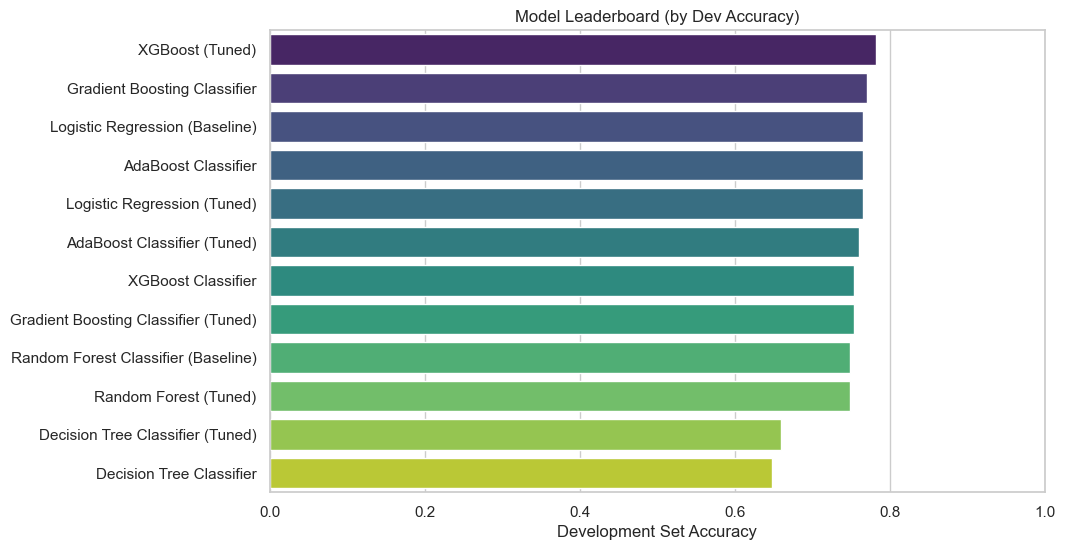

In [102]:
plot_leaderboard(results)

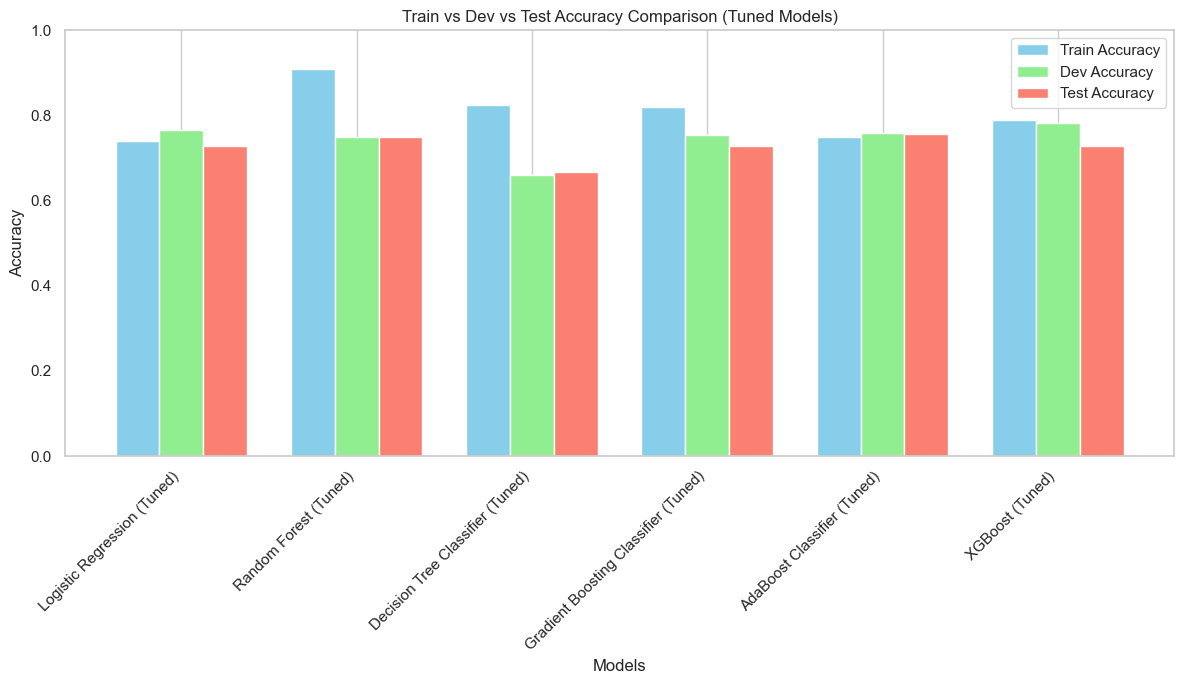

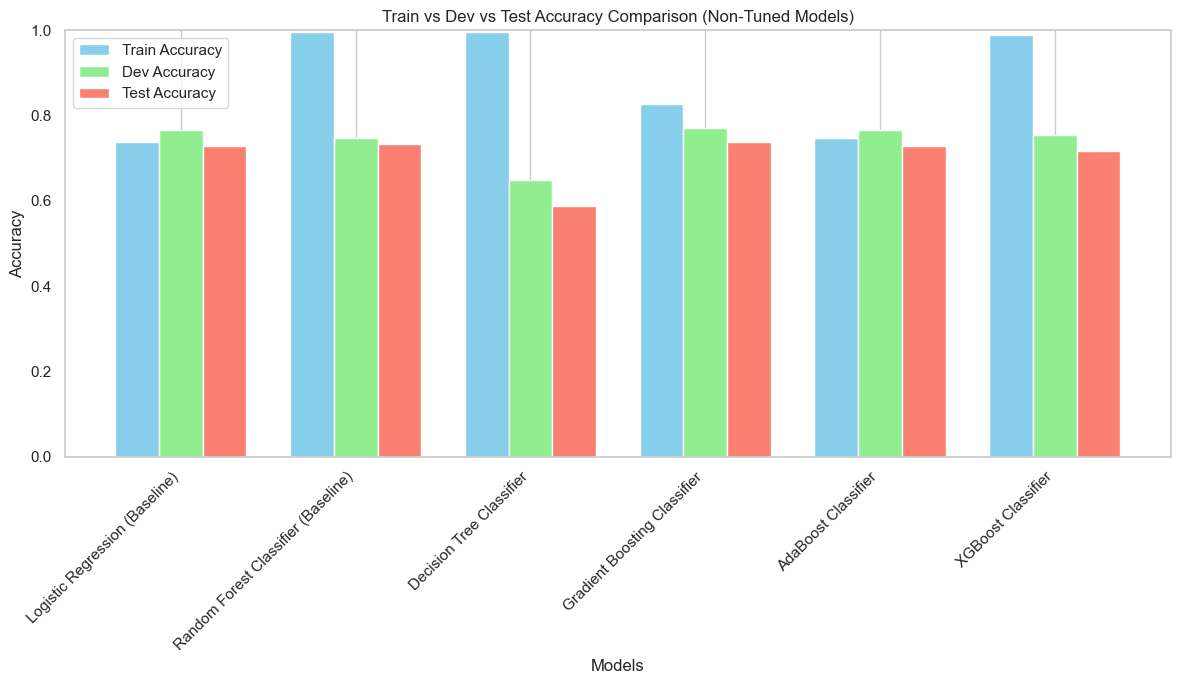

In [103]:
# 4. Accuracy Comparison (new plot!) 
plot_accuracy_comparison(results)

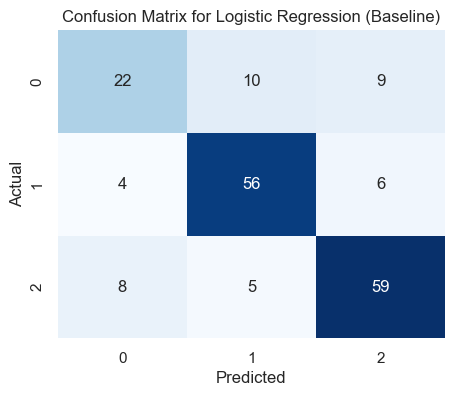

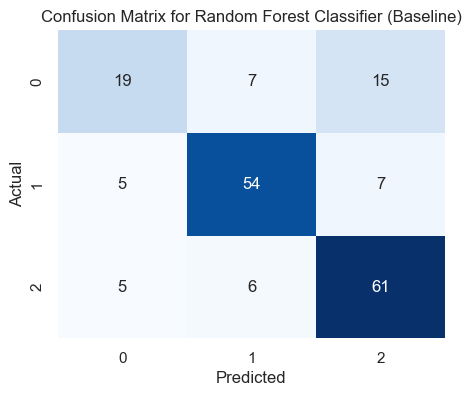

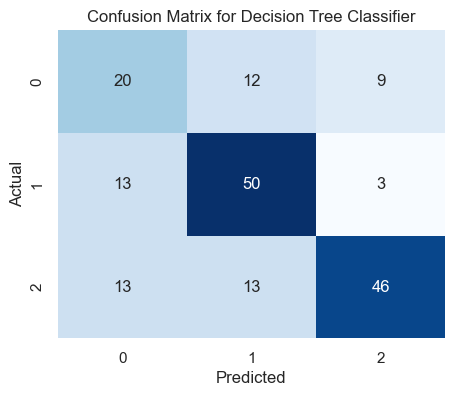

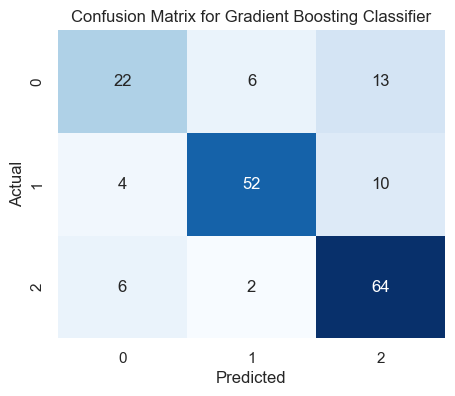

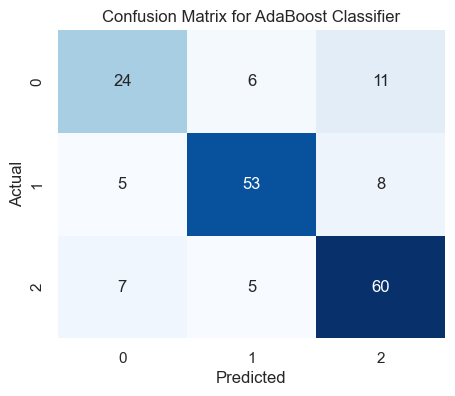

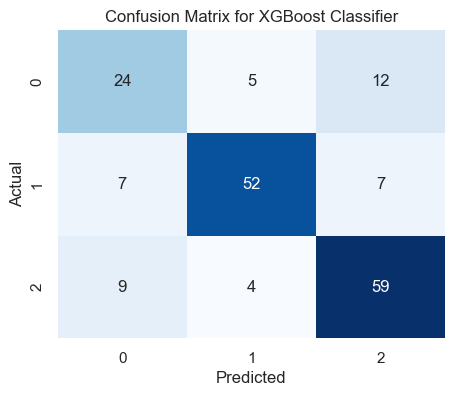

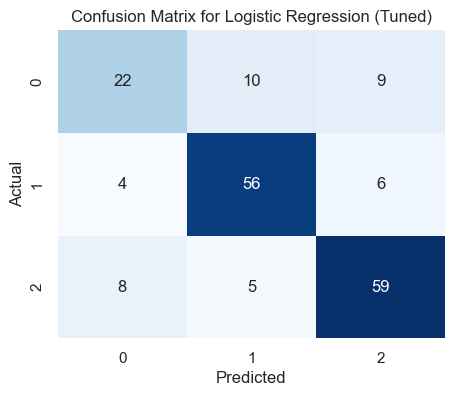

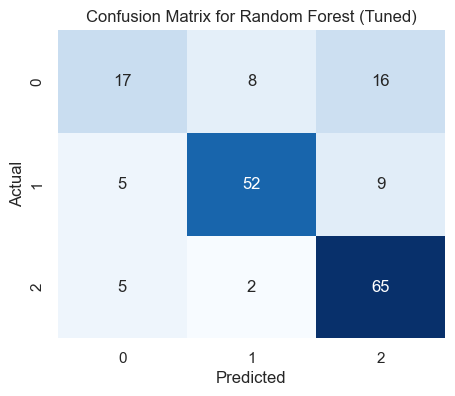

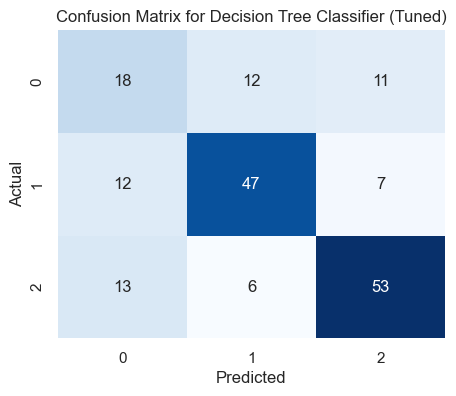

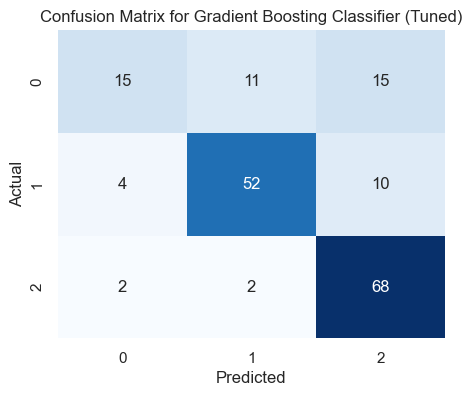

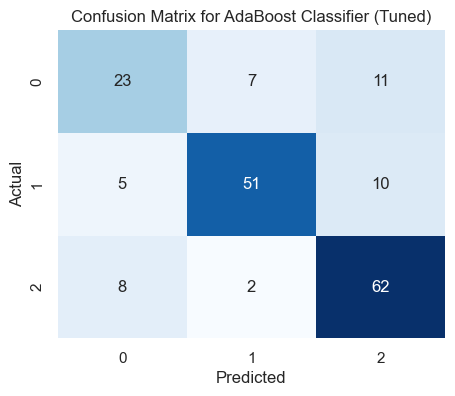

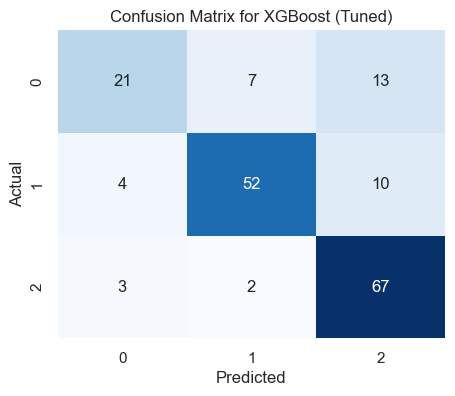

In [104]:
plot_confusion_matrices(results, X_dev, y_dev)



 Running SHAP Explainability...
Explaining XGBoost (Tuned)


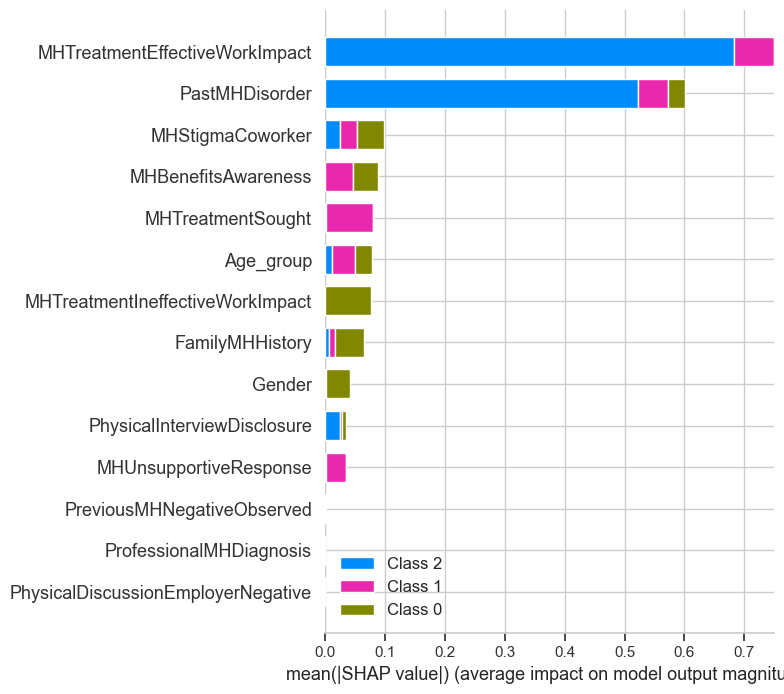

In [105]:
# 5. SHAP Explain Top Model (X_sample can be a small subset of your dev or test set)
shap_explain_model(results, X[:100])  # Using first 100 samples from dev set for SHAP explanation